#**EDA and Feature Generation**
## shops, items, item_categories

Andreas Theodoulou and Michael Gaidis (June, 2020)

#**0. Mount Google Drive (Local File Storage/Repo For Colab)**

In [ ]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1. Configure Environment and Load Data Files**

In [ ]:
# python libraries/modules used throughout this notebook (with some holdovers from other, similar notebooks)
'''
NOTE: selecting a group of code lines and pressing ctrl-/ will toggle commenting of the code lines, for fast and easy disabling/enabling of stuff
'''

# pandas data(database) storage, EDA, and manipulation
import pandas as pd
### pandas formatting
### Adjust as per your preferences.  Here's what I find works well when using a FHD monitor with a full-screen browser window containing my IPynb notebook:
# pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
# pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
# pd.set_option("display.width", 250)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
# pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
### Here's what I find works well for this particular IPynb, when using a FHD laptop monitor with a full-screen browser window containing my IPynb notebook:
pd.set_option("display.max_rows",120)     # Override pandas choice of how many rows to show, so, for example, we can see the full 84-row item_category dataframe instead of the first few rows, then ...., then the last few rows
pd.set_option("display.max_columns",26)   # Similar to row code above, we can show more columns than default  
pd.set_option("display.width", 230)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle

# pd.set_option("display.precision", 3)  # Nah, this is helpful, but below is even better
# Try to convince pandas to print without decimal places if a number is actually an integer (helps keep column width down, and highlights data types), or with precision = 3 decimals if a float
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

# Pandas additional enhancements
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ipynb magic command to allow interactive matplotlib graphics in ipynb notebook
%matplotlib inline  
# a useful reference of contrasting color choices to use when plotting multiple things on a single axis
pltcolors = ['blue','red','green','black','darkorange','fuchsia','teal','gold','violet','olive','firebrick','gray','cyan','sienna','dodgerblue','lime','darkorchid','deeppink','turquoise','tan']
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from IPython.display import Javascript      # used to properly code the creation of sns heatmaps in IPynb with Google Colab
from IPython.display import display_html    # used to print out side-by-side dataframes, for example

# computations
import numpy as np
from scipy import sparse
from numba import jit, njit, prange  # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas series or dataframes)
#  If you want Numba to throw an error if it cannot compile a function in a way that speeds up your code, pass the argument nopython=True (e.g. @jit(nopython=True))
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html
# can also do np.vectorize (see pandas 1.0.3 documentation section on enhancing speed of pandas operations)

# file operations
import os
import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz
import pickle
import json
from urllib.parse import urlunparse
from pathlib import Path

# misc. python enhancements
# note: for a quick look at what's available for magic commands in this ipynb, enter this into a code cell: '%quickref'
import re
import string
from itertools import product
from collections import OrderedDict
import time
import datetime
from time import sleep, localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()


# Specialized packages
# -- for network analysis / graphs / clustering (a reasonable alternative to pca, tSNE, or Knn clustering when number of dimensions is huge)
import networkx as nx
from networkx.algorithms import community, cluster
# -- NLP packages ... for now, as of 5/29/20, only using the lemmatizer, due to the 
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

# ML packages
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# !pip install catboost
# from catboost import CatBoostRegressor
# %tensorflow_version 2.x
# import tensorflow as tf
# import keras as K

# # List of the modules we need to version-track for reference
modules = ['pandas','matplotlib','numpy','scipy','numba','seaborn','sklearn','tensorflow','keras','catboost','pip','nltk','networkx']
print(f'done: {strftime("%a %X %x")}')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
done: Tue 21:23:55 06/16/20


In [ ]:
#  Except for fast-loading (large filesize) feather format files, 
#   the data is coming from a public repo on GitHub at github.com/migai/Kag that has been synced to my local repo on Google Drive

'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
OUT_OF_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final"   # place > 100MB files here, because they won't sync with GitHub

traintest_loaded = True   # set this to True if you plan to load the .ftr or the .csv.gz version of the traintest dataframe, and skip the calculations below that generated it
ftr_file_load_employed = True #False #True  # set to True if you wish to load the .ftr version or the .csv.gz version... it's faster, but its a 10x larger file, and won't work in the GitHub repo push


# if using large feather file for fast loading, use the routine here
#   note that this is too large to push to GitHub, so if you want to go this route, 
#   you'll first have to load (more slowly) the 'data_output/traintest.csv.gz' file 
#   with pandas read_csv, and then store the file as feather type (outside your local GitHub repo)
#   Or, you can just recreate the dataframe by running the first few code cells that do merging and data manipulation
# load feather files manually for now
if (traintest_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    traintest = pd.read_feather('traintest.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: traintest (from ftr)")
    print(traintest.head(2))

'''
############################################################
############################################################
'''

data_files = []
# List of the data files (path relative to GitHub master), to be loaded into pandas DataFrames
if (traintest_loaded and not ftr_file_load_employed):
    data_files = [ "data_output/traintest.csv.gz" ]
                
data_files += [  #"readonly/final_project_data/shops.csv",
                #"data_output/shops_transl.csv",
                "data_output/shops_augmented.csv",
                "data_output/shops_new.csv",
               
                #"readonly/final_project_data/items.csv",
                #"data_output/items_transl.csv",
                "data_output/items_augmented.csv",
                #"data_output/items_new.csv",
                #"data_output/items_clustered_22170.csv.gz",
               
                #"readonly/final_project_data/item_categories.csv",
                #"data_output/item_categories_transl.csv",
                "data_output/item_categories_augmented.csv",
                #"readonly/en_50k.csv",
               
                "readonly/final_project_data/sales_train.csv.gz",
                #"data_output/sales_train_cleaned.csv.gz",
               
                #"readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/test.csv.gz"
                ]


# Dict of helper code files, to be loaded and imported {filepath : import_as}
code_files = {}  # not used at this time; example dict = {"helper_code/kaggle_utils_at_mg.py" : "kag_utils"}


# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai"
repo_name = 'Kag'
branch_name = 'master'
base_url = os.path.join(git_hub_url, repo_name, branch_name)

if data_files:
    print('\n\ncsv files source directory: ', end='')
    %cd "{GDRIVE_REPO_PATH}"

    print("\nLoading csv Files from Google Drive repo into Colab...\n")

    # Loop to load the data files into appropriately-named pandas DataFrames
    for path_name in data_files:
        filename = path_name.rsplit("/")[-1]
        data_frame_name = filename.split(".")[0]
        exec(data_frame_name + " = pd.read_csv(path_name)")
        # if data_frame_name == 'sales_train':
        #     sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
        print(f'DataFrame {data_frame_name}, shape = {eval(data_frame_name).shape} :')
        print(eval(data_frame_name).head(2))
        print("\n")
else: 
    %cd "{GDRIVE_REPO_PATH}"
    
print(f'\nDataFrame Loading Complete: {strftime("%a %X %x")}\n')

ftr files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final
Loading ftr Files from Google Drive (outside repo) into Colab... 

Data Frame: traintest (from ftr)
   day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                  item_name  it_test  item_category_id   item_category_name  it_cat_test item_cat3 item_cat4         shop_name sh_cat  \
0    0  Tue    1     0    0       2      0     99      1        2      991    3d action puzzle dinosaur tyrannosaurus    False                67  Gifts - Development         True     Gifts     Gifts  Adygea TC "Mega"   Mega   
1    0  Tue    1     0    0       2      0   2599      1        2     1472  assassin creed 3 xbox 360 russian version    False                23     Games - XBOX 360         True     Games      Xbox  Adygea TC "Mega"   Mega   

   sh_test district    city  
0     True    South  Adygea  
1     True    South  Adygea  


csv files source directory:

#**2. Merge data sets and create day, week, quarter, and season feature columns**

In [1]:
def clean_merge_augment(day0 = datetime.datetime(2013,1,1),
                        delete_rows = [2909818,2909401,2326930,2257299,1163158,484683],
                        merge_shops = {0: 57, 1: 58, 11: 10},
                        delete_shops = []):
    """
    Parameters:
    day0 = datetime.datetime object representing the day you wish to use as your reference when creating time-based features
    delete_rows = list of integer row numbers that you wish to delete from the sales_train data set
    merge_shops = dictionary of integer shop_id key:value pairs where shop(=key) is merged into shop(=value)
    delete_shops = list of integer shop_id numbers that you wish to fully delete from the sales_train data set
        # looks like it could be safe to delete these shops from sales_train: [8, 13, 23, 32, 33, 40]
        # should probably delete categories 8, 80 (= 'tickets') and probably 81,82 (= 'net carriers')

    Global Variables: this function assumes you have the following pandas dataframes available globally:
    1) unaltered sales_train
    2) unaltered test
    3) items_augmented (contains 'item_id', 'item_tested', 'item_category_id', and 'orig_eng_name_transl')
    4) item_categories_augmented ('item_category_id','en_cat_name','item_cat_tested','item_category3','item_category4')
    5) shops_augmented ('shop_id', 'en_shop_name', 'shop_city', 'shop_federal_district',  'shop_city_population',  'shop_tested')
    6) shops_new ('shop_id', 'shop_type', 'fd_popdens',  'fd_gdp')

    This function does the following:
    1) cleans (deletes) outlier rows from the training set that appear to be erroneous or irrelevant entries
    2) merge 3 shops into other shops where it appears that the sales_train set simply has different names for the 
        same shop at different time periods (shop 0 absorbed by 57; shop 1 absorbed by 58, shop 11 absorbed by 10)
    3) optionally delete shops entirely from the sales_train data set (e.g., for irrelevant shops)
    4) append the test set rows to the sales_train rows, using a date of November 1, 2015 for test
    5) adjust the 'date' column on the merged dataset to be in datetime format, so it looks like a string of format: 'YYYY-M-D'
    6) merge the aforementioned data sets into the merged sales_train + test DataFrame

    Then, creates and inserts new time-based feature columns as follows:
    Given a dataframe with a 'date' column containing strings like '2015-10-30', create new time-series columns:
    1. 'day'    = integer value of day number, starting at day = 0 for parameter day0, and incrementing by calendar day number (not by transaction day number)... 
                    Thus, 'day' may not include all possible integers from start to finish.  It only assigns integer values (based on the calendar) to days when 
                    there are transactions in the input dataframe --> if the input dataframe has no transactions on a particular day, that day's 'calendar' integer 
                    value will not be present in the column (will be = 0)
    2. 'DoW'    = day of week = 3-character text string of weekday by name (Sun, Mon, ...)
    3. 'DoM'    = day of month = 1-31
    4. 'week'   = integer value of week number, with week = 0 at time= parameter day0.  However, unlike 'day', the 'week' number is aligned not to start at day0, but rather
                    so that there is a full 'week' of 7 days that ends on Oct. 31, 2015 (the final day of training data).  This results in week = 0 having only 5 days in it.
                    n.b., the final week of October, 2015 is assigned 'week' number = 147.  Artifically assigning test to Nov. 1, 2015 results in test week = 148
    5. 'month'  = renamed from "date_block_num" of original data set (no changes).  Integer values from 0 to 33 represent the months starting at day0.  Test month=34 is Nov. 2015.
    6. 'qtr'    = quarter = integer number of 3-month chunks of time, aligned with the end of October, 2015.  day0 is included in 'qtr' = 0, but 'qtr'=0 only contains 1 month (Jan 2013) of data due to the alignment
                    The months of August, Sept, Oct 2015 form 'qtr' = 11.  "qtr" in this sense is just 3-month chunks... it is not the traditional Q1,Q2,Q3,Q4 beginning Jan 1, but instead is more like
                    date_block_num in that it is monotonically increasing integers, incremented every 3 months such that #11 ends at the end of our training data
    7. 'season' = integer number of 3-month chunks of time, reset each year (allowed values = 0,1,2,3)... not quite the same as spring-summer-winter-fall, or Q1,Q2,Q3,Q4, but instead shifted to 
                    better capture seasonal spending trends aligned in particular with high December spending
                    2 = Dec 1 to Feb 28 (biggest spending season), 3 = Mar 1 to May 31, 0 = June 1 to Aug 30 (lowest spending season), 1 = Sept 1 to Nov 30

    Finally, drop the date column from the dataframe, and sort the dataframe by ['day','shop_id','item_id']  (original dataframe seems to be sorted by month, but unsorted within each month)

    returns: the cleaned/dated/merged/feature-augmented DataFrame
    """

    print(f'Shape of original sales_train data set = {sales_train.shape}')

    # remove outlier rows from training set (first make a DataFrame copy so we can reuse sales_train later, if we need to)
    sales_train_cleaned = sales_train.copy(deep=True)
    print('Rows being deleted:')
    for i in sorted(delete_rows, reverse=True):   # delete the rows in reverse order to be sure we don't run into issues with indexing
        print(f'  {i}')
        sales_train_cleaned.drop(sales_train_cleaned.index[i],inplace=True)
    print(f'Shape of sales_train_cleaned after {len(delete_rows)} outlier rows were removed: {sales_train_cleaned.shape}')
    
    # Merge the 3 shops we are nearly certain must correctly fit into the other shops' dropout regions:
    sales_train_cleaned.shop_id = sales_train_cleaned.shop_id.replace(merge_shops)
    print(f'Shape of sales_train_cleaned after merging shops as in {merge_shops}: {sales_train_cleaned.shape}')

    # Remove irrelevant shops entirely from the sales_train_cleaned DataFrame:
    if delete_shops:
        sales_train_cleaned = sales_train_cleaned.query('shop_id != @delete_shops')
        print(f'Shape of sales_train_cleaned after deleting shops {delete_shops}: {sales_train_cleaned.shape}')

    # sales_train_cleaned = sales_train_cleaned[sales_train_cleaned.shop_id != 9]
    # sales_train_cleaned = sales_train_cleaned[sales_train_cleaned.shop_id != 13]
    # print(f'Shape of sales_train_cleaned after removal of shops: {sales_train_cleaned.shape})
    # print(f'{sales_train_cleaned.shop_id.nunique()} shops remaining in sales_train_cleaned DataFrame: {sorted(sales_train_cleaned.shop_id.unique())})

    sales_train_cleaned = sales_train_cleaned.astype({'date_block_num':np.int8,'shop_id':np.int8,'item_id':np.int16,
                                                    'item_price':np.float32,'item_cnt_day':np.int16}).reset_index(drop=True)

    # merge dataframes so we optionally include test elements in our EDA and feature generation
    test_prep = test.copy(deep=True)
    test_prep['date_block_num'] = 34
    test_prep['date'] = '1.11.2015' #pd.Timestamp(year=2015, month=11, day=1)
    sales_traintest_cleaned = sales_train_cleaned.append(test_prep).fillna(0)

    traintest = sales_traintest_cleaned.merge(items_augmented[['item_id','item_category_id','item_tested','item_name']],on='item_id',how='left').reset_index(drop=True)
    traintest = traintest.merge(item_categories_augmented[['item_category_id','en_cat_name','item_cat_tested','item_category3','item_category4']],on='item_category_id',how='left').reset_index(drop=True)
    traintest = traintest.merge(shops_augmented[['shop_id', 'en_shop_name', 'shop_city', 'shop_federal_district', 'shop_tested']], on='shop_id',how='left').reset_index(drop=True)  
    traintest = traintest.merge(shops_new[['shop_id', 'shop_type']], on='shop_id',how='left').reset_index(drop=True)
    traintest = traintest[['date', 'date_block_num', 'item_price', 'item_cnt_day', 'shop_id', 'item_id', 'item_name', 'item_tested', 'item_category_id', 'en_cat_name', 'item_cat_tested',
                                'item_category3', 'item_category4', 'en_shop_name', 'shop_type','shop_tested', 'shop_federal_district', 'shop_city']]
    traintest.columns = ['date', 'month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id', 'item_category_name', 'it_cat_test', 'item_cat3', 'item_cat4', 
                            'shop_name', 'sh_cat', 'sh_test', 'district', 'city']
    traintest.item_name.astype(str)
    print(f'Shape of traintest after merging: {traintest.shape}')
        
    # Add in the time-based feature columns
    traintest.date =  pd.to_datetime(traintest.date, dayfirst=True, infer_datetime_format=True)
    traintest.insert(1,'day', traintest.date.apply(lambda x: (x - day0).days))
    traintest.insert(2,'DoW', traintest.date.apply(lambda x: x.strftime('%a')))  # lambda x: (x.weekday()+1)%7 )  # 0=Sun, 1=Mon, ... 6= Sat   # use x.strftime('%A') to get full text string of day (Sunday, Monday, ...)
    traintest.insert(3,'DoM', traintest.date.apply(lambda x: x.day))
    traintest.insert(4,'week', (traintest.day+2) // 7 )             # add the 2 days so we have end of a week coinciding with end of training data Oct. 31, 2015
    traintest.insert(5,'qtr', (traintest.month + 2) // 3 )          # add the 2 months so we have end of a quarter aligning with end of training data Oct. 31, 2015
    traintest.insert(6,'season', (traintest.month + 2) % 4 ) 
    traintest.drop('date',axis=1,inplace=True)
    traintest = traintest.sort_values(['day','shop_id','item_id']).reset_index(drop=True)  # note that the train dataset is sorted by month, but nothing obvious within the month; we sort it here for consistent results in calculations below
    print(f'Shape of traintest after creating time-based feature columns: {traintest.shape}')
    print(f'traintest DataFrame creation done: {strftime("%a %X %x")}\n')
    return traintest

print(f'\nDone: {strftime("%a %X %x")}\n')

NameError: ignored

In [2]:
if not traintest_loaded:
    print(f'traintest dataframe creation started: {strftime("%a %X %x")}\n')
    traintest = clean_merge_augment()

    # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    %cd "{OUT_OF_REPO_PATH}"
    traintest.to_feather('traintest.ftr')
    print("traintest.ftr feather file stored on google drive, outside repo")
    %cd "{GDRIVE_REPO_PATH}"
    # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    compression_opts = dict(method='gzip',
                            archive_name='traintest.csv')  
    traintest.to_csv('data_output/traintest.csv.gz', index=False, compression=compression_opts)
    print("traintest.csv.gz file stored on google drive in data_output directory")
    print(f'traintest file save done: {strftime("%a %X %x")}')

display(traintest[traintest.week == 102].tail(2))

# Copy in case we screw up tt; don't want to recreate traintest
tt = traintest.copy(deep=True)

print(f'\ntraintest done: {strftime("%a %X %x")}')

NameError: ignored

#**3. What shops are critical for items or item_categories that are rarely sold?**
(i.e., can we delete any shops because they are irrelevant?)

In [ ]:
print(f'Start: {strftime("%a %X %x")}')
test_items = test.sort_values(['item_id','shop_id']).item_id.unique()
test_item_df = pd.DataFrame({'item_id':test_items, 'n_shops':np.NaN, 'shops':np.NaN, 'item_cat':np.NaN, 'cat_name':np.NaN})

ttq = tt[tt.month < 34].copy(deep=True)
ttq = ttq[['day','shop_id','item_id','item_category_id','sales']]
ttq = ttq[ttq.item_id.isin(test_items)]

test_item_df.item_cat = test_item_df.item_id.apply(lambda x: items_augmented.at[x,'item_category_id'])
test_item_df.cat_name = test_item_df.item_cat.apply(lambda x: item_categories_augmented.at[x,'en_cat_name'])
cat_counts = test_item_df.item_cat.value_counts().to_frame().reset_index().rename(columns={'index':'item_cat_id', 'item_cat':'n_test_items_in_cat'})
test_item_df.shops = test_item_df.item_id.apply(lambda x: ttq.query('item_id == @x').shop_id.unique())
test_cats = test_item_df.sort_values('item_cat').item_cat.unique()
test_cats_df = pd.DataFrame({'item_cat_id':test_cats,'n_shops_selling_cat':np.NaN, 'item_cat_shops':np.NaN})
test_cats_df = test_cats_df.merge(cat_counts, on='item_cat_id', how='left')

ttcq = tt[tt.month < 34].copy(deep=True)
ttcq = ttcq.groupby(['shop_id','item_category_id']).agg({'sales':'sum'}).reset_index()
ttcq = ttcq[ttcq.item_category_id.isin(test_cats)]
print(f'\nttcq DataFrame, shape: {ttcq.shape}')
display(ttcq.head())

test_cats_df.item_cat_shops = test_cats_df.item_cat_id.apply(lambda x: ttcq.query('item_category_id == @x').shop_id.unique())
test_item_df.n_shops = test_item_df.shops.apply(lambda x: len(x))
test_cats_df.n_shops_selling_cat = test_cats_df.item_cat_shops.apply(lambda x: len(x))
test_cats_df['cat_name'] = test_cats_df.item_cat_id.apply(lambda x: item_categories_augmented.at[x,'en_cat_name'])

print(f'\ntest_item_df DataFrame, shape: {test_item_df.shape}    nunique item_ids: {test_item_df.item_id.nunique()}')
display(test_item_df.head())
print(f'\ntest_cats_df DataFrame, shape: {test_cats_df.shape}    nunique cat_ids: {test_cats_df.item_cat_id.nunique()}')
display(test_cats_df.head())
print(f'Done: {strftime("%a %X %x")}')

Start: Tue 21:24:00 06/16/20

ttcq DataFrame, shape: (2643, 3)


shop_id  item_category_id  sales
0        2                 2    355
1        2                 3    527
3        2                 5     50
4        2                 6    329
5        2                 7     76


test_item_df DataFrame, shape: (5100, 5)    nunique item_ids: 5100


item_id  n_shops                                                                                                                                                                                                      shops  \
0       30       48                  [6, 8, 13, 19, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 35, 37, 41, 42, 43, 46, 50, 54, 7, 15, 16, 44, 56, 10, 12, 24, 25, 38, 45, 47, 51, 53, 59, 4, 14, 57, 5, 18, 52, 58, 3, 2, 17, 48]   
1       31       51      [6, 7, 14, 15, 16, 18, 19, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 41, 42, 43, 44, 45, 51, 52, 54, 12, 24, 38, 46, 50, 4, 13, 23, 56, 59, 8, 10, 53, 57, 58, 2, 3, 5, 47, 17, 49, 39, 34, 48]   
2       32       51      [27, 28, 38, 42, 46, 54, 14, 25, 31, 44, 59, 6, 13, 16, 19, 21, 29, 35, 51, 52, 57, 4, 45, 3, 18, 23, 26, 37, 58, 56, 15, 30, 24, 53, 7, 32, 41, 43, 8, 5, 50, 10, 12, 22, 47, 17, 2, 49, 48, 33, 39]   
3       33       52  [27, 54, 7, 19, 44, 29, 50, 57, 6, 45, 2, 24, 28, 47, 51, 16, 25, 8, 56, 15, 31, 23, 41, 46, 38, 42, 26, 37, 18, 32, 53, 35, 21, 5, 30, 12, 43, 58, 13, 14, 52, 59, 10, 17, 4, 3, 22, 49, 39, 48, 34, 36]   
4       38       31                                                                                 [19, 54, 24, 13, 6, 25, 44, 59, 52, 15, 27, 30, 33, 58, 56, 31, 28, 12, 46, 57, 4, 26, 48, 39, 51, 47, 42, 10, 22, 16, 45]   

   item_cat            cat_name  
0        40         Movie - DVD  
1        37     Movie - Blu-Ray  
2        40         Movie - DVD  
3        37     Movie - Blu-Ray  
4        41  Cinema - Collector


test_cats_df DataFrame, shape: (62, 5)    nunique cat_ids: 62


item_cat_id  n_shops_selling_cat  \
0            0                    3   
1            2                   51   
2            3                   54   
3            5                   50   
4            6                   53   

                                                                                                                                                                                                      item_cat_shops  \
0                                                                                                                                                                                                       [25, 38, 57]   
1               [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   
2  [2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   
3                  [2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   
4       [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59]   

   n_test_items_in_cat                    cat_name  
0                    1  PC - Headsets / Headphones  
1                   10           Accessories - PS3  
2                   28           Accessories - PS4  
3                    4        Accessories - PSVita  
4                    9      Accessories - XBOX 360

Done: Tue 21:25:08 06/16/20


Items item_id n_shops item_cat 
 
 count 
 5.1e+03 
 5.1e+03 
 5.1e+03 
 
 
 mean 
 1.1e+04 
 26 
 46 
 
 
 std 
 6.3e+03 
 18 
 17 
 
 
 min 
 30 
 0 
 0 
 
 
 25% 
 5.4e+03 
 8 
 37 
 
 
 50% 
 1.1e+04 
 28 
 43 
 
 
 75% 
 1.6e+04 
 44 
 58 
 
 
 max 
 2.2e+04 
 55 
 83 
 
        Item Categories item_cat_id n_shops_selling_cat n_test_items_in_cat 
 
 count 
 62 
 62 
 62 
 
 
 mean 
 42 
 43 
 82 
 
 
 std 
 24 
 21 
 1.4e+02 
 
 
 min 
 0 
 1 
 1 
 
 
 25% 
 23 
 48 
 8 
 
 
 50% 
 40 
 52 
 33 
 
 
 75% 
 63 
 55 
 1e+02 
 
 
 max 
 83 
 56 
 7.7e+02

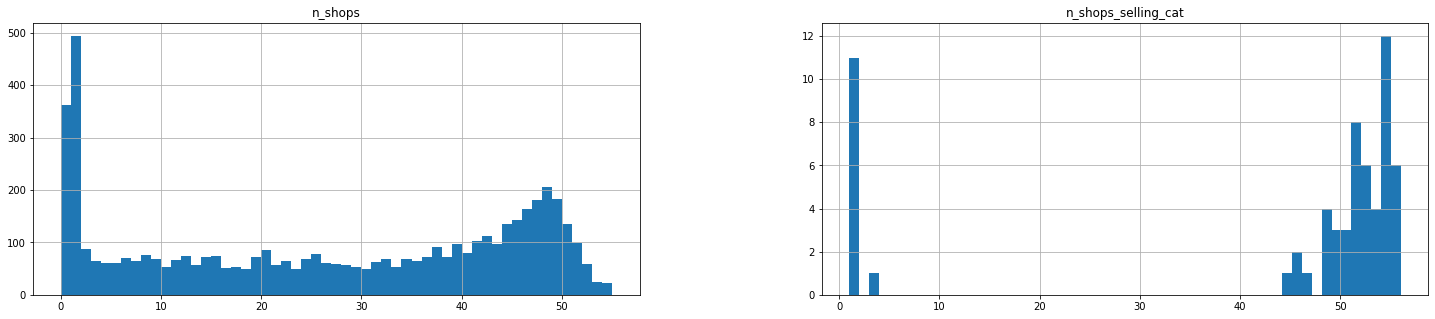

In [ ]:
df1_styler = test_item_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Items').format("{:.2g}")
df2_styler = test_cats_df.describe().style.set_table_attributes("style='display:inline'").set_caption('Item Categories').format("{:.2g}")

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0" + "\xa0\xa0\xa0" +
             df2_styler._repr_html_(), raw=True)


#display(test_item_df.describe())
fig = plt.figure(figsize=(25,5)) 
axItem = fig.add_subplot(1,2,1)
axCat = fig.add_subplot(1,2,2)
nit = test_item_df.hist('n_shops', bins=55, ax=axItem)
ncat = test_cats_df.hist('n_shops_selling_cat', bins=56, ax=axCat)

# many items in test set (> 350) have 0 shops selling them, and nearly 500 have only 1 shop selling them (out of 5100 possible)
# several categories (11) have only 1 shop selling them; one category has only 3 shops selling it

In [ ]:
# How many times to the "partially open" (i.e., closed before month 34) and "untested" shops show up in the low count item and category shop sellers?

partial = [8, 9, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]  # untested shops that don't show sales over the full range of days in months 0 to 33

def color_badlist_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for shops in the 'partial' list
    and black otherwise
    """
    color = 'red' if val in partial else 'black'
    return 'color: %s' % color


part_cat_shop = test_cats_df[test_cats_df.n_shops_selling_cat < 4].copy(deep=True)
print(f'before explode: {part_cat_shop.shape}')
part_cat_shop = part_cat_shop.explode('item_cat_shops').reset_index(drop=True)
print(f'after explode: {part_cat_shop.shape}')
display(part_cat_shop.head(15))
pcs_vc = part_cat_shop.item_cat_shops.value_counts().to_frame().reset_index().rename(columns={'index':'shop_id', 'item_cat_shops':'n_appearances_in_low_n_shops_item_categories'})
s = pcs_vc.style.applymap(color_badlist_red)
display(s)

# 55 is a very important shop regarding sales of items in strange categories --> need to either combine these categories with other categories, or do something to help 55


before explode: (12, 5)
after explode: (14, 5)


item_cat_id  n_shops_selling_cat item_cat_shops  n_test_items_in_cat                           cat_name
0             0                    3             25                    1         PC - Headsets / Headphones
1             0                    3             38                    1         PC - Headsets / Headphones
2             0                    3             57                    1         PC - Headsets / Headphones
3             9                    1             12                    8                  Delivery of goods
4            26                    1             55                    2            Games Android - Digital
5            27                    1             55                    1                Games MAC - Digital
6            31                    1             55                  277                 Games PC - Digital
7            34                    1             55                    5    Payment cards - Live! (Numeral)
8            36                    1             55                    2    Payment card - Windows (figure)
9            44                    1             55                    7        Books - Audiobooks (figure)
10           54                    1             55                   38                    Books - Digital
11           74                    1             55                    1             Program - MAC (figure)
12           76                    1             55                   61  Program - Home & Office (Digital)
13           78                    1             55                   49    Programs - Educational (figure)

In [ ]:
def highlight_partial(s, color='red'):
    """
    highlight the partially-open shops in a Series or DataFrame
    """
    attr = f'color: {color}'
    is_partial = s.isin(partial)
    return pd.Series([attr if v else '' for v in is_partial])

partial_shops_items = OrderedDict({2:{},3:{},6:{}})
for nmax in [2,3,6]:
    partial_shops_items[nmax]['df'] = test_item_df[test_item_df.n_shops < (nmax + 1)].copy(deep=True)
    partial_shops_items[nmax]['shape_before_explode'] = partial_shops_items[nmax]['df'].shape
    partial_shops_items[nmax]['df'] = partial_shops_items[nmax]['df'].explode('shops').sort_values(['n_shops','item_id'])
    partial_shops_items[nmax]['shape_after_explode'] = partial_shops_items[nmax]['df'].shape
    partial_shops_items[nmax]['df']['item_name'] = partial_shops_items[nmax]['df'].item_id.apply(lambda x: items_augmented.at[x, 'item_name']).reset_index(drop=True)
    partial_shops_items[nmax]['df_vc_s'] = partial_shops_items[nmax]['df'].shops.value_counts().to_frame().reset_index().rename(columns={'index':'shop_id', 'shops':f'n_appearances_in_nmax{nmax}_shops_items'})
    included_shops = partial_shops_items[nmax]['df_vc_s'].shop_id.unique()
    #partial_shops_items[nmax]['df_vc_s'] = partial_shops_items[nmax]['df_vc_s'].style.apply(highlight_partial, subset='shop_id')
    partial_shops_items[nmax]['included_partial_shops'] = [x for x in partial if x in included_shops]
    partial_shops_items[nmax]['not_included_partial_shops'] = [x for x in partial if x not in included_shops]

    print(f'For fewer than {nmax+1} shops selling a particular item:')
    print(f'    shape before explode: {partial_shops_items[nmax]["shape_before_explode"]}')
    print(f'    shape after explode:  {partial_shops_items[nmax]["shape_after_explode"]}')
    print(f'    partially-active shops involved in selling items that are sold from fewer than {nmax+1} shops: {partial_shops_items[nmax]["included_partial_shops"]}')
    print(f'    partially-active shops NOT involved in selling items that are sold from fewer than {nmax+1} shops: {partial_shops_items[nmax]["not_included_partial_shops"]}\n')

# nmax_styler = {}
# displ = ""
# for nmax in [2,3,6]:
#     nmax_styler[nmax] = partial_shops_items[nmax]['df'].describe().style.set_table_attributes("style='display:inline'").set_caption(f'n_shops < {nmax+1}').format("{:.2g}")
#     displ += nmax_styler[nmax]._repr_html_() + "\xa0\xa0\xa0" + "\xa0\xa0\xa0"
# display_html(displ, raw=True)

nmax_styler = {}
displ = ""
for nmax in [2,3,6]:
    nmax_styler[nmax] = partial_shops_items[nmax]['df_vc_s'].style.apply(highlight_partial, subset='shop_id').set_table_attributes("style='display:inline'").set_caption(f'n_shops < {nmax+1}')
    displ += nmax_styler[nmax]._repr_html_() + "\xa0\xa0\xa0" + "\xa0\xa0\xa0"
display_html(displ, raw=True)

# looks like it could be safe to delete these shops from sales_train: [8, 13, 23, 32, 33, 40]

For fewer than 3 shops selling a particular item:
    shape before explode: (944, 5)
    shape after explode:  (1031, 5)
    partially-active shops involved in selling items that are sold from fewer than 3 shops: [9, 20, 29, 43, 51, 54]
    partially-active shops NOT involved in selling items that are sold from fewer than 3 shops: [8, 13, 17, 23, 27, 30, 32, 33, 40]

For fewer than 4 shops selling a particular item:
    shape before explode: (1008, 5)
    shape after explode:  (1223, 5)
    partially-active shops involved in selling items that are sold from fewer than 4 shops: [9, 17, 20, 27, 29, 30, 43, 51, 54]
    partially-active shops NOT involved in selling items that are sold from fewer than 4 shops: [8, 13, 23, 32, 33, 40]

For fewer than 7 shops selling a particular item:
    shape before explode: (1199, 5)
    shape after explode:  (2187, 5)
    partially-active shops involved in selling items that are sold from fewer than 7 shops: [9, 17, 20, 27, 29, 30, 43, 51, 54]
    parti

n_shops < 3 shop_id n_appearances_in_nmax2_shops_items 
 
 0 
 55 
 399 
 
 
 1 
 25 
 51 
 
 
 2 
 31 
 35 
 
 
 3 
 9 
 21 
 
 
 4 
 6 
 21 
 
 
 5 
 20 
 19 
 
 
 6 
 12 
 17 
 
 
 7 
 42 
 13 
 
 
 8 
 19 
 9 
 
 
 9 
 46 
 7 
 
 
 10 
 22 
 6 
 
 
 11 
 57 
 6 
 
 
 12 
 21 
 6 
 
 
 13 
 4 
 6 
 
 
 14 
 28 
 5 
 
 
 15 
 15 
 5 
 
 
 16 
 56 
 5 
 
 
 17 
 5 
 4 
 
 
 18 
 24 
 4 
 
 
 19 
 44 
 3 
 
 
 20 
 37 
 3 
 
 
 21 
 18 
 2 
 
 
 22 
 35 
 2 
 
 
 23 
 26 
 2 
 
 
 24 
 47 
 2 
 
 
 25 
 54 
 2 
 
 
 26 
 10 
 2 
 
 
 27 
 7 
 1 
 
 
 28 
 3 
 1 
 
 
 29 
 59 
 1 
 
 
 30 
 14 
 1 
 
 
 31 
 16 
 1 
 
 
 32 
 29 
 1 
 
 
 33 
 43 
 1 
 
 
 34 
 48 
 1 
 
 
 35 
 50 
 1 
 
 
 36 
 51 
 1 
 
 
 37 
 2 
 1 
 
        n_shops < 4 shop_id n_appearances_in_nmax3_shops_items 
 
 0 
 55 
 399 
 
 
 1 
 25 
 77 
 
 
 2 
 31 
 61 
 
 
 3 
 20 
 37 
 
 
 4 
 9 
 32 
 
 
 5 
 6 
 29 
 
 
 6 
 12 
 28 
 
 
 7 
 42 
 20 
 
 
 8 
 46 
 15 
 
 
 9 
 28 
 15 
 
 
 10 
 22 
 14 
 
 
 11 
 57 
 13 
 
 
 12 
 19 
 12 
 
 
 13 
 21 
 11 
 
 
 14 
 56 
 10 
 
 
 15 
 4 
 9 
 
 
 16 
 24 
 8 
 
 
 17 
 15 
 6 
 
 
 18 
 54 
 5 
 
 
 19 
 37 
 5 
 
 
 20 
 10 
 4 
 
 
 21 
 5 
 4 
 
 
 22 
 18 
 4 
 
 
 23 
 59 
 3 
 
 
 24 
 44 
 3 
 
 
 25 
 35 
 3 
 
 
 26 
 38 
 3 
 
 
 27 
 47 
 3 
 
 
 28 
 27 
 2 
 
 
 29 
 53 
 2 
 
 
 30 
 51 
 2 
 
 
 31 
 7 
 2 
 
 
 32 
 48 
 2 
 
 
 33 
 14 
 2 
 
 
 34 
 26 
 2 
 
 
 35 
 16 
 2 
 
 
 36 
 30 
 2 
 
 
 37 
 2 
 2 
 
 
 38 
 45 
 1 
 
 
 39 
 17 
 1 
 
 
 40 
 43 
 1 
 
 
 41 
 41 
 1 
 
 
 42 
 50 
 1 
 
 
 43 
 29 
 1 
 
 
 44 
 3 
 1 
 
        n_shops < 7 shop_id n_appearances_in_nmax6_shops_items 
 
 0 
 55 
 399 
 
 
 1 
 25 
 202 
 
 
 2 
 31 
 179 
 
 
 3 
 42 
 89 
 
 
 4 
 20 
 83 
 
 
 5 
 6 
 78 
 
 
 6 
 9 
 67 
 
 
 7 
 12 
 67 
 
 
 8 
 28 
 65 
 
 
 9 
 57 
 43 
 
 
 10 
 21 
 41 
 
 
 11 
 22 
 39 
 
 
 12 
 46 
 35 
 
 
 13 
 56 
 33 
 
 
 14 
 19 
 31 
 
 
 15 
 54 
 28 
 
 
 16 
 18 
 24 
 
 
 17 
 47 
 23 
 
 
 18 
 24 
 20 
 
 
 19 
 27 
 19 
 
 
 20 
 35 
 18 
 
 
 21 
 26 
 16 
 
 
 22 
 15 
 15 
 
 
 23 
 44 
 14 
 
 
 24 
 37 
 14 
 
 
 25 
 48 
 13 
 
 
 26 
 52 
 13 
 
 
 27 
 16 
 12 
 
 
 28 
 38 
 11 
 
 
 29 
 4 
 11 
 
 
 30 
 45 
 11 
 
 
 31 
 50 
 11 
 
 
 32 
 39 
 10 
 
 
 33 
 10 
 10 
 
 
 34 
 14 
 9 
 
 
 35 
 5 
 9 
 
 
 36 
 2 
 8 
 
 
 37 
 53 
 7 
 
 
 38 
 7 
 6 
 
 
 39 
 58 
 5 
 
 
 40 
 51 
 5 
 
 
 41 
 41 
 4 
 
 
 42 
 29 
 3 
 
 
 43 
 17 
 3 
 
 
 44 
 30 
 3 
 
 
 45 
 34 
 3 
 
 
 46 
 36 
 3 
 
 
 47 
 43 
 3 
 
 
 48 
 49 
 3 
 
 
 49 
 3 
 3 
 
 
 50 
 59 
 3

#**4. Zero-Sales Days**
(when is the shop active vs. closed (shuttered) or not yet open for business?)

In [ ]:
# Establish which shops have consecutive zero-sales days, and how long zero-sales periods extend

day_shop = tt.query('month < 34').groupby(['day','shop_id','item_id']).agg({'sh_test':'mean','it_test':'mean',
                'item_category_id':'mean','it_cat_test':'mean','month':'mean', 'DoM':'mean','price':'count','sales':'sum'}).reset_index()
day_shop.rename(columns={'price':'n_transactions_per_day'}, inplace=True)
print(f'Number of days in training period: {(datetime.datetime(2015,11,1) - datetime.datetime(2013,1,1)).days}')
print(f'Shape of day_shop DataFrame: {day_shop.shape}')
display(day_shop.describe())
print('\n')
display(day_shop.head())

Number of days in training period: 1034
Shape of day_shop DataFrame: (2935815, 11)


day  shop_id    item_id  item_category_id   month     DoM  n_transactions_per_day   sales
count 2935815  2935815    2935815           2935815 2935815 2935815                 2935815 2935815
mean  457.239   33.303 10,197.194            40.001  14.570  15.853                   1.000   1.241
std   286.899   16.147  6,324.292            17.101   9.423   8.923                   0.003   2.179
min         0        2          0                 0       0       1                       1     -22
25%       212       22       4476                28       7       8                       1       1
50%       427       31       9343                40      14      16                       1       1
75%       703       48      15684                55      23      24                       1       1
max      1033       59      22169                83      33      31                       2     669

day  shop_id  item_id  sh_test  it_test  item_category_id  it_cat_test  month  DoM  n_transactions_per_day  sales
0    0        2      991     True    False                67         True      0    1                       1      1
1    0        2     1472     True    False                23         True      0    1                       1      1
2    0        2     1905     True     True                30         True      0    1                       1      1
3    0        2     2920     True    False                21         True      0    1                       1      2
4    0        2     3320     True    False                19         True      0    1                       1      1

In [ ]:
zero_sale = pd.DataFrame({'shop_id':day_shop.sort_values('shop_id').shop_id.unique(), 'n_active':np.NaN, 'n_inactive':np.NaN, 'active_days':np.NaN, 'inactive_days':np.NaN})
zero_sale.active_days = zero_sale.shop_id.apply(lambda x: day_shop[day_shop.shop_id == x].day.unique())
zero_sale.n_active = zero_sale.active_days.apply(lambda x: len(x))
zero_sale.n_inactive = 1034 - zero_sale.n_active
zero_sale.inactive_days = zero_sale.active_days.apply(lambda x: [i for i in range(1034) if i not in x])
display(zero_sale.head())
ivc = zero_sale.n_inactive.value_counts().to_frame().reset_index().rename(columns={'index':'num_days_inactive', 'n_inactive':'num_shops_inactive_this_many_days'})
print(f'\n{ivc.num_shops_inactive_this_many_days.sum()} shops in list\n')
ivc

shop_id  n_active  n_inactive  \
0        2      1018          16   
1        3      1028           6   
2        4      1010          24   
3        5       996          38   
4        6      1031           3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                   active_days  \
0                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, ...]   
1                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   
2                                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 119, 120, 121, ...]   
3  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, ...]   
4                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   

                                                                                                                                    inactive_days  
0                                                                              [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 539, 724]  
1                                                                                                                    [0, 365, 537, 593, 730, 735]  
2                            [0, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 365, 730]  
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]  
4                                                                                                                                   [0, 365, 730]


57 shops in list



num_days_inactive  num_shops_inactive_this_many_days
0                   3                                 10
1                   1                                  3
2                   2                                  3
3                   4                                  3
4                   5                                  3
5                   0                                  2
6                   6                                  2
7                   8                                  2
8                1020                                  2
9                 208                                  2
10                 22                                  1
11                577                                  1
12                449                                  1
13                 16                                  1
14                444                                  1
15                 20                                  1
16                917                                  1
17                135                                  1
18                702                                  1
19                 24                                  1
20               1025                                  1
21                285                                  1
22                159                                  1
23                256                                  1
24                833                                  1
25                483                                  1
26                 36                                  1
27                 38                                  1
28                361                                  1
29                426                                  1
30                 21                                  1
31                950                                  1
32                120                                  1
33                851                                  1
34                 10                                  1

In [ ]:
def get_continuous(arry, allowed_split=1):
    sequences = np.split(arry, np.array(np.where(np.diff(arry) > allowed_split)[0]) + 1)
    l = []
    for s in sequences:
        if len(s) > 1:
            l.append((np.min(s), np.max(s))) #, np.max(s)-np.min(s)+1))
        else:
            l.append((s[0]))
    return(l)


# sh48np = zero_sale[zero_sale.shop_id == 48].inactive_days.sort_values().to_numpy()[0]
# print(get_continuous(sh48np,1))

def closed(inactive_ranges,tup_idx,daynum):
    r = 0
    if len(inactive_ranges) > 0:
        if type(inactive_ranges[-tup_idx]) == tuple:
            if inactive_ranges[-tup_idx][tup_idx] == daynum:
                r = inactive_ranges[-tup_idx][1] - inactive_ranges[-tup_idx][0] + 1
    return r

def dropout(inactive_ranges):
    r = []
    if len(inactive_ranges) > 0:
        for i in inactive_ranges:
            if type(i) == tuple:
                if ((i[0] != 0 ) & (i[1] != 1033)):
                    r.append(i)
    return r


zero_sale['inactive_ranges'] = zero_sale.inactive_days.apply(lambda x: [] if len(x)==0 else get_continuous(np.sort(x),1))
zero_sale['early_close'] = zero_sale.inactive_ranges.apply(lambda x: closed(x,1,1033))
zero_sale['late_open'] = zero_sale.inactive_ranges.apply(lambda x: closed(x,0,0))
zero_sale['dropouts'] = zero_sale.inactive_ranges.apply(lambda x: dropout(x))

display(zero_sale.head())

shop_id  n_active  n_inactive  \
0        2      1018          16   
1        3      1028           6   
2        4      1010          24   
3        5       996          38   
4        6      1031           3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                   active_days  \
0                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, ...]   
1                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   
2                                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 119, 120, 121, ...]   
3  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, ...]   
4                                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]   

                                                                                                                                    inactive_days               inactive_ranges  early_close  late_open     dropouts  
0                                                                              [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 539, 724]          [(25, 38), 539, 724]            0          0   [(25, 38)]  
1                                                                                                                    [0, 365, 537, 593, 730, 735]  [0, 365, 537, 593, 730, 735]            0          0           []  
2                            [0, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 365, 730]      [0, (98, 118), 365, 730]            0          0  [(98, 118)]  
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]                     [(0, 37)]            0         38           []  
4         

In [ ]:
# look at crossover from closing of store 23 to opening of 55, around days 117-120
tt2355 = tt.query('(shop_id == 23) | (shop_id == 55)')
tt2355 = tt2355.query('(day > 114) & (day < 123)')
print(tt2355.shape)
display(tt2355.head())
it23 = sorted(tt2355.query('shop_id==23').item_id.unique())
cat23 = sorted(tt2355.query('shop_id==23').item_category_id.unique())
it55 = sorted(tt2355.query('shop_id==55').item_id.unique())
cat55 = sorted(tt2355.query('shop_id==55').item_category_id.unique())

# looks like shops 23 and 55 aren't closely related in the items they sell, 
#   even though they close/open within a day or two of each other

(246, 23)


day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                                                            item_name  it_test  item_category_id                  item_category_name  \
423015  115  Fri   26    16    1       1      3    199      1       23      700  1c cognitive collection interactive driving simulator gorodus sda rule 2013 dvd box    False                77               Program - Educational   
423016  115  Fri   26    16    1       1      3    299      1       23      971                                                       30 second to mar beautiful lie     True                55      Music - CD of local production   
423017  115  Fri   26    16    1       1      3    699      1       23     1470                                            assassin creed 3 pc jewel russian version    False                30         Games PC - Standard Edition   
423018  115  Fri   26    16    1       1      3    999      1       23     1939                                                bioshock infinite pc russian subtitle    False                28  Games PC - Additional publications   
423019  115  Fri   26    16    1       1      3   5590      1       23     2219                        corel pinnacle system studio ultimate collection v16 software    False                75       Program - For home and office   

        it_cat_test item_cat3 item_cat4                        shop_name sh_cat  sh_test district    city  
423015         True  Software        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423016         True     Music     Music  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423017         True     Games        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423018         True     Games        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow  
423019         True  Software        PC  Moscow TK "Budenovsky" (pav.A2)   Mall    False  Central  Moscow

#**5. EDA related to spiky sales from online stores**

In [ ]:
# spikes in online stores:  9, 12, 20, 55 (and 40?)
# what items are being sold, and on what days, when spikes go > 400?, and is it the first time that item is sold?
# should probably delete categories 8, 80 (= 'tickets') and probably 81,82 (= 'net carriers')

@njit
def get_first_index_nb(A, k):
    for i in range(len(A)):
        if A[i] == k:
            return i
    return -1

# '''
# Create tt_online DataFrame to hold training info from online shops 9, 12, 20, 55
# But only keeping the "spiky" sales of over 200 units per transaction
# '''

keepcols= ['day', 'DoW','DoM','month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id','item_category_name', 'it_cat_test','shop_name','sh_test']
tt_online = tt[keepcols].copy(deep=True)
tt_online.shop_name = tt_online.shop_name.apply(lambda x: x[:10])
tt_online.item_name = tt_online.item_name.astype(str).apply(lambda x: x[:30])
#tt_online = tt_online[tt_online.item_category_id == 83]
tt_online = tt_online[(tt_online.shop_id == 9) | (tt_online.shop_id == 12) | (tt_online.shop_id == 20) | (tt_online.shop_id ==55)]
tt_online = tt_online[tt_online.sales > 35]
tt_online = tt_online[tt_online.sales <= 50]
spiky_sales_items = tt_online.item_id.unique()
print(f"Item IDs present in the online shops' spikes: {spiky_sales_items}")

# first occurence of spiky items in the sales_train data ... turns out not to be terribly well correlated with the spikes in the online shops
print(f'\nFirst occurences of spiky items in sales_train data set (item_id  row_num)')
for osid in spiky_sales_items:
    print(osid, get_first_index_nb(tt.item_id.to_numpy(), int(osid)))

# all items sold by online shops with sales 35 to 50 per transaction
print(f'\nAll items sold by online shops with 35 to 50 units sold per transaction:')
tt_online

Item IDs present in the online shops' spikes: [15038 22076  2808  1516  3740  3734  3732  6457 13617 13620  1511 11370
  3707   805 13811  7004 11369 11373  8060 19319  9242  9241  9243  9396
 15275 19439  6504 19436  1556 20405  1548  3025 19446  3931  4392  5917
 20956 13345  1568  1875  1385  4894  1544  3730 11365  1816  9251  9247
  3351  9252  9253  9244  9245  9255 13246  6503 11526 16843]

First occurences of spiky items in sales_train data set (item_id  row_num)
15038 9955
22076 400520
2808 117
1516 735289
3740 889511
3734 889509
3732 889508
6457 247718
13617 827563
13620 826065
1511 1092193
11370 42876
3707 1138106
805 1156255
13811 522777
7004 1451496
11369 40032
11373 35793
8060 1515766
19319 93571
9242 1826712
9241 1825866
9243 1830389
9396 1728424
15275 1550439
19439 2032099
6504 1960094
19436 2029258
1556 2139557
20405 2137894
1548 2152772
3025 1616447
19446 2045556
3931 2184594
4392 2340514
5917 1119173
20956 1580936
13345 169
1568 2507621
1875 1760199
1385 2049639
4894

day  DoW  DoM  month     price  sales  shop_id  item_id                       item_name  it_test  item_category_id                  item_category_name  it_cat_test   shop_name  sh_test
153443     41  Mon   11      1       390     40       12    15038  metodmaterialy 1c trade manage    False                49     Books - Methodical materials 1C         True  Shop Onlin     True
400744    108  Fri   19      3   397.337     48       12    22076  eador lord of world pc jewel r    False                30         Games PC - Standard Edition         True  Shop Onlin     True
434229    118  Mon   29      3       999     50       12     2808  diablo iii pc jewel russian ve     True                30         Games PC - Standard Edition         True  Shop Onlin     True
752862    218  Wed    7      7       299     37       12     1516  assassin creed iv black flag c    False                30         Games PC - Standard Edition         True  Shop Onlin     True
759143    220  Fri    9      7       299     40       12     1516  assassin creed iv black flag c    False                30         Games PC - Standard Edition         True  Shop Onlin     True
889787    259  Tue   17      8 3,492.333     45       12     3740  grand theft auto v special edi    False                19                         Games - PS3         True  Shop Onlin     True
892455    260  Wed   18      8 2,548.082     49       12     3734  grand theft auto v xbox 360 ru     True                23                    Games - XBOX 360         True  Shop Onlin     True
944654    277  Sat    5      9 2,591.959     43        9     3732  grand theft auto v ps3 russian     True                19                         Games - PS3         True  Itinerant     False
944655    277  Sat    5      9 2,598.957     37        9     3734  grand theft auto v xbox 360 ru     True                23                    Games - XBOX 360         True  Itinerant     False
944725    277  Sat    5      9   598.977     40        9     6457      simcity pc russian version     True                30         Games PC - Standard Edition         True  Itinerant     False
949747    278  Sun    6      9 2,598.974     38        9     3732  grand theft auto v ps3 russian     True                19                         Games - PS3         True  Itinerant     False
949893    278  Sun    6      9       399     40        9    13617  mug angry bird green pig 3d 40    False                69                   Gifts - Souvenirs         True  Itinerant     False
949896    278  Sun    6      9       399     36        9    13620  mug angry bird red bird 3d 400    False                69                   Gifts - Souvenirs         True  Itinerant     False
1095385   325  Fri   22     10   770.429     49       12     1511  assassin creed iv black flag s    False                28  Games PC - Additional publications         True  Shop Onlin     True
1095403   325  Fri   22     10       240     50       12    11370                 delivery moscow     True                 9                   Delivery of goods         True  Shop Onlin     True
1138455   339  Fri    6     11 3,186.775     40       12     3707  gran turismo 6 anniversary edi     True                19                         Games - PS3         True  Shop Onlin     True
1159108   344  Wed   11     11       100     36       55      805  1c enterprise 83 practical dev     True                54                     Books - Digital         True  Digital st     True
1190006   353  Fri   20     11       399     40       12    13811  legend number 17 dvd and avtof    False                40                         Movie - DVD         True  Shop Onlin     True
1454062   423  Fri   28     13   951.778     36       12     7004        thief pc russian version     True                28  Games PC - Additional publications         True  Shop Onlin     True
1507248   440  Mon   17     14   344.750     40       12    11369                   delivery mail     True    

In [ ]:
# common items in shops 50, 51
# since these shops are so similar, what items do they sell, and can we get clues on how to possibly cluster certain items better?

@njit
def get_first_index_nb(A, k):
    for i in range(len(A)):
        if A[i] == k:
            return i
    return -1

# '''
# Create tt_5051 DataFrame to hold training info from shops 50 and 51
# '''

keepcols= ['day', 'DoW','DoM','month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id','item_category_name', 'it_cat_test','shop_name','sh_test']
tt_5051 = tt[keepcols].copy(deep=True)
tt_5051.shop_name = tt_5051.shop_name.apply(lambda x: x[:10])
tt_5051.item_name = tt_5051.item_name.astype(str).apply(lambda x: x[:30])
#tt_online = tt_online[tt_online.item_category_id == 83]
tt_5051 = tt_5051[(tt_5051.shop_id == 50) | (tt_5051.shop_id == 51)]
tt_5051 = tt_5051[tt_5051.sales > 25]
#tt_5051 = tt_5051[tt_5051.sales <= 50]
sales_items_5051 = tt_5051.item_id.unique()
print(f"Item IDs present in the online shops' spikes: {sales_items_5051}")

# first occurence of spiky items in the sales_train data ... turns out not to be terribly well correlated with the spikes in the online shops
print(f'\nFirst occurences of spiky items in sales_train data set (item_id  row_num)')
for osid in sales_items_5051:
    print(osid, get_first_index_nb(tt.item_id.to_numpy(), int(osid)))

print(f'\nAll items sold by shops 50 and 51 with over 25 units sold per transaction:')
tt_5051

Item IDs present in the online shops' spikes: [ 6738 14826 16787  2808  3732  3734  1849  6675  2814  3733  3731 20949]

First occurences of spiky items in sales_train data set (item_id  row_num)
6738 269024
14826 4348
16787 575945
2808 117
3732 889508
3734 889509
1849 1019495
6675 1116306
2814 1584849
3733 2154616
3731 2578530
20949 417474

All items sold by shops 50 and 51 with over 25 units sold per transaction:


day  DoW  DoM  month      price  sales  shop_id  item_id                       item_name  it_test  item_category_id                    item_category_name  it_cat_test   shop_name  sh_test
273303    70  Tue   12      2        699     36       50     6738  starcraft ii heart of swarm ad     True                30           Games PC - Standard Edition         True  Tyumen SC      True
547339   155  Wed    5      5        199     30       50    14826  mtg ru basic edition 2013 boos    False                65               Gifts - Games (compact)         True  Tyumen SC      True
578689   164  Fri   14      5  2,501.941     34       50    16787   some of u ps3 russian version     True                19                           Games - PS3         True  Tyumen SC      True
589256   167  Mon   17      5        999     30       50     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC      True
612599   174  Mon   24      5    971.727     33       50     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC      True
636996   182  Tue    2      6        999     33       50     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC      True
742144   214  Sat    3      7        999     45       50     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC      True
746038   215  Sun    4      7        735     31       51     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC     False
851719   247  Thu    5      8        999     43       50     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC      True
894053   260  Wed   18      8  2,523.157     89       50     3732  grand theft auto v ps3 russian     True                19                           Games - PS3         True  Tyumen SC      True
894054   260  Wed   18      8  2,519.250     40       50     3734  grand theft auto v xbox 360 ru     True                23                      Games - XBOX 360         True  Tyumen SC      True
894134   260  Wed   18      8       2184     31       51     3732  grand theft auto v ps3 russian     True                19                           Games - PS3         True  Tyumen SC     False
911112   265  Mon   23      8  2,587.056     36       50     3732  grand theft auto v ps3 russian     True                19                           Games - PS3         True  Tyumen SC      True
948018   277  Sat    5      9        999     41       50     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC      True
952645   278  Sun    6      9        735     31       51     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC     False
991785   291  Sat   19      9        735     29       51     2808  diablo iii pc jewel russian ve     True                30           Games PC - Standard Edition         True  Tyumen SC     False
1021491  301  Tue   29      9       1199     41       50     1849  battlefield 4 limited edition     False                28    Games PC - Additional publications         True  Tyumen SC      True
1118856  332  Fri   29     10 18,337.826     46       50     6675  sony playstation 4 500 gb blac     True                12                   Game consoles - PS4         True  Tyumen SC      True
1588456  469  Tue   15     15    879.244     41       50     2814  diablo iii reaper of soul addi    False                28    Games PC - Additional publications         True  Tyumen SC      True
2158934  687  Wed   19     22  3,084.714     28       50     3733  gr

##Stuff

In [ ]:
# Group by day and shop_id to get each shop's sales by day
print(f'tt DataFrame: shape = {tt.shape}')
display(tt.head(3))
day_shop = tt.groupby(['day','shop_id']).agg({'month':'mean', 'week':'mean','DoM':'mean','sales':'sum'}).reset_index()
print(f'\nday_shop DataFrame: shape = {day_shop.shape}')
display(day_shop.head())

tt DataFrame: shape = (3150043, 23)


day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                         item_name  it_test  item_category_id           item_category_name  it_cat_test item_cat3 item_cat4  \
0    0  Tue    1     0    0       2      0     99      1        2      991           3d action puzzle dinosaur tyrannosaurus    False                67          Gifts - Development         True     Gifts     Gifts   
1    0  Tue    1     0    0       2      0   2599      1        2     1472         assassin creed 3 xbox 360 russian version    False                23             Games - XBOX 360         True     Games      Xbox   
2    0  Tue    1     0    0       2      0    249      1        2     1905  bestseller grand theft auto san andreas pc jewel     True                30  Games PC - Standard Edition         True     Games        PC   

          shop_name sh_cat  sh_test district    city  
0  Adygea TC "Mega"   Mega     True    South  Adygea  
1  Adygea TC "Mega"   Mega     True    South  Adygea  
2  Adygea TC "Mega"   Mega     True    South  Adygea


day_shop DataFrame: shape = (47270, 6)


day  shop_id  month  week  DoM  sales
0    0        2      0     0    1     24
1    0        7      0     0    1     89
2    0        8      0     0    1     50
3    0       13      0     0    1     31
4    0       14      0     0    1     66

In [ ]:
# Pivot the data to get plottable columns
shop_ids = day_shop.shop_id.unique()

day_shop_piv = day_shop.pivot(index='day',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
print(f'day_shop_piv Shape: {day_shop_piv.shape}')
display(day_shop_piv.head())
print('\n')
display(day_shop_piv.describe())
print('\n\n')

# also create a version of the table, using scaled versions of all districts, for easier comparison
qt = day_shop_piv.quantile(0.999)
sc = MinMaxScaler((0,100))
day_shop_piv_sc = day_shop_piv.copy(deep=True)
for sh in shop_ids:
    day_shop_piv_sc[sh] = day_shop_piv_sc[sh].clip(0,qt[sh])
    day_shop_piv_sc[sh] = sc.fit_transform(day_shop_piv_sc[sh].to_numpy().reshape(-1,1))
display(day_shop_piv_sc.head())
print('\n')
display(day_shop_piv_sc.describe())

day_shop_piv Shape: (1035, 58)


day  2  3   4  5   6   7   8  9  10  12  13  14  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
0    0 24  0   0  0   0  89  50  0   0   0  31  66  ...   0   0   0   0 136   0   0 415   0   0   0   0   0
1    1 76 64 166  0 173 208 138  0  31   0  34 105  ... 153   0   0 231 147 119 149 709   0 375   0   0 155
2    2 96 43 142  0 187 158 121  0  30   1  61 123  ... 115   0   0 236 146 100 116 586   0 244 203 204 158
3    3 80 44 132  0 187 117 106  0  31   0  63 106  ... 139   0   0 206 121 115 104 495   0 171 352  39  92
4    4 72 29 116  0 144 125  99  0  34   0  41  80  ... 117   0   0 155  88  62 141 495   0 191 292 200 101

[5 rows x 58 columns]

day      2      3      4      5      6      7      8       9     10      12     13     14  ...     47     48     49     50     51     52     53      54     55     56      57     58     59
count    1035   1035   1035   1035   1035   1035   1035   1035    1035   1035    1035   1035   1035  ...   1035   1035   1035   1035   1035   1035   1035    1035   1035   1035    1035   1035   1035
mean      517 29.585 27.396 42.456 41.316 97.091 64.790  3.473  15.329 24.246  66.964 19.095 44.807  ... 65.350 24.067 16.512 73.660 47.118 48.062 59.572 179.507 61.244 75.439 147.644 85.068 47.336
std   298.923 19.923 16.273 25.698 24.828 49.380 36.557 14.988 158.881 13.862 116.793 21.970 27.373  ... 42.654 30.240 17.843 49.824 29.188 24.395 30.429 147.558 85.333 45.340  80.295 49.035 27.105
min         0      0      0      0      0      0      0     -1      -1      0      -2      0      0  ...      0      0      0      0      0      0      0      -1      0      0       0      0      0
25%   258.500     19     16     26 25.500     63     42      0       0     15       3      0     26  ...     35      0      0     36     26     32     39      80     26     44  95.500     57     28
50%       517     25     24     38     37     89     56      0       0     21      48     15     39  ...     52     16     14     60     42     43     53     158     45     64     134     77     41
75%   775.500     35     35     53     53    121     78      0       0     31      85     32     57  ...     86     41     26    100     63     59     73     253     74     96     182    103     58
max      1034    245    126    204    229    448    308    153    2279    116    2228    131    200  ...    347    218    149    397    169    229    263     818   1298    375     730    495    199

[8 rows x 58 columns]

day      2      3      4  5      6      7      8  9     10    12     13     14  ...     47  48  49     50     51     52     53     54  55     56     57     58     59
0    0 12.167      0      0  0      0 29.309 36.384  0      0     0 29.273 34.768  ...      0   0   0      0 81.587      0      0 54.193   0      0      0      0      0
1    1 38.529 53.333 83.954  0 46.182 68.498    100  0 31.074     0 32.106 55.313  ... 46.062   0   0 64.722 88.186 59.764 62.339 92.586   0    100      0      0 85.229
2    2 48.669 35.833 71.816  0 49.919 52.032 88.050  0 30.072 0.089 57.603 64.795  ... 34.621   0   0 66.123 87.586 50.222 48.533 76.524   0 79.783 28.761 44.782 86.878
3    3 40.557 36.667 66.758  0 49.919 38.530 77.135  0 31.074     0 59.491 55.839  ... 41.847   0   0 57.717 72.588 57.755 43.512 64.640   0 55.913 49.872  8.561 50.587
4    4 36.502 24.167 58.666  0 38.440 41.164 72.041  0 34.081     0 38.717 42.143  ... 35.224   0   0 43.428 52.791 31.138 58.992 64.640   0 62.453 41.371 43.904 55.536

[5 rows x 58 columns]

day       2      3       4      5      6      7      8     9      10    12     13      14  ...     47     48     49     50      51     52     53      54    55     56     57     58     59
count    1035    1035   1035    1035   1035   1035   1035   1035  1035    1035  1035   1035    1035  ...   1035   1035   1035   1035    1035   1035   1035    1035  1035   1035   1035   1035   1035
mean      517  14.975 22.825  21.469 20.885 25.899 21.335  2.517 0.713  24.288 5.843 18.008  23.598  ... 19.669 11.605 14.751 20.627  28.265 24.123 24.914  23.435 5.349 24.645 20.915 18.665 26.019
std   298.923   9.869 13.532  12.977 12.449 13.059 12.029 10.799 7.367  13.799 8.957 20.642  14.391  ... 12.810 14.555 15.766 13.892  17.504 12.150 12.667  19.241 7.289 14.696 11.352 10.695 14.856
min         0       0      0       0      0      0      0      0     0       0     0      0       0  ...      0      0      0      0       0      0      0       0     0      0      0      0      0
25%   258.500   9.632 13.333  13.149 12.900 16.818 13.831      0     0  15.036 0.266      0  13.696  ... 10.537      0      0 10.087  15.597 16.071 16.317  10.447 2.276 14.387 13.531 12.513 15.396
50%       517  12.674     20  19.218 18.718 23.758 18.442      0     0  21.050 4.256 14.165  20.545  ... 15.655  7.719 12.534 16.811  25.196 21.595 22.174  20.633 3.940 20.927 18.985 16.903 22.544
75%   775.500  17.744 29.167  26.804 26.812 32.301 25.687      0     0  31.074 7.536 30.218  30.027  ... 25.891 19.779 23.278 28.018  37.794 29.631 30.542  33.038 6.479 31.390 25.786 22.611 31.892
max      1034 100.000    100 100.000    100    100    100    100   100 100.000   100    100 100.000  ...    100    100    100    100 100.000    100    100 100.000   100    100    100    100    100

[8 rows x 58 columns]

In [ ]:
# Compare shop sales for the shops that were deleted/merged in sales_train_cln_mrg EDA
#   I had removed shop 9
#   I had removed shop 13
#   I had merged 0 into 57,  1 into 58,  and 11 into 10
cleaned_shops = [9,13,0,57,1,58,11,10]
print(shops_augmented.iloc[cleaned_shops,:])
print(shops_augmented[shops_augmented.shop_federal_district=='None'])

                        shop_name  shop_id                       en_shop_name  shop_city shop_category shop_federal_district  shop_city_population  shop_tested
9               Выездная Торговля        9                    Itinerant trade       None     Itinerant                  None                100000        False
13            Казань ТЦ "Бехетле"       13    Kazan shopping center "Bahetle"      Kazan          Mall                 Volga               1104738        False
0   !Якутск Орджоникидзе, 56 фран        0  ! Yakutsk Ordzhonikidze, 56 Franc    Yakutsk          Shop               Eastern                235600        False
57        Якутск Орджоникидзе, 56       57          Yakutsk Ordzhonikidze, 56    Yakutsk          Shop               Eastern                235600         True
1   !Якутск ТЦ "Центральный" фран        1       ! Yakutsk TC "Central" Franc    Yakutsk          Mall               Eastern                235600        False
58        Якутск ТЦ "Центральный"       

Plotted at: Tue 21:25:20 06/16/20



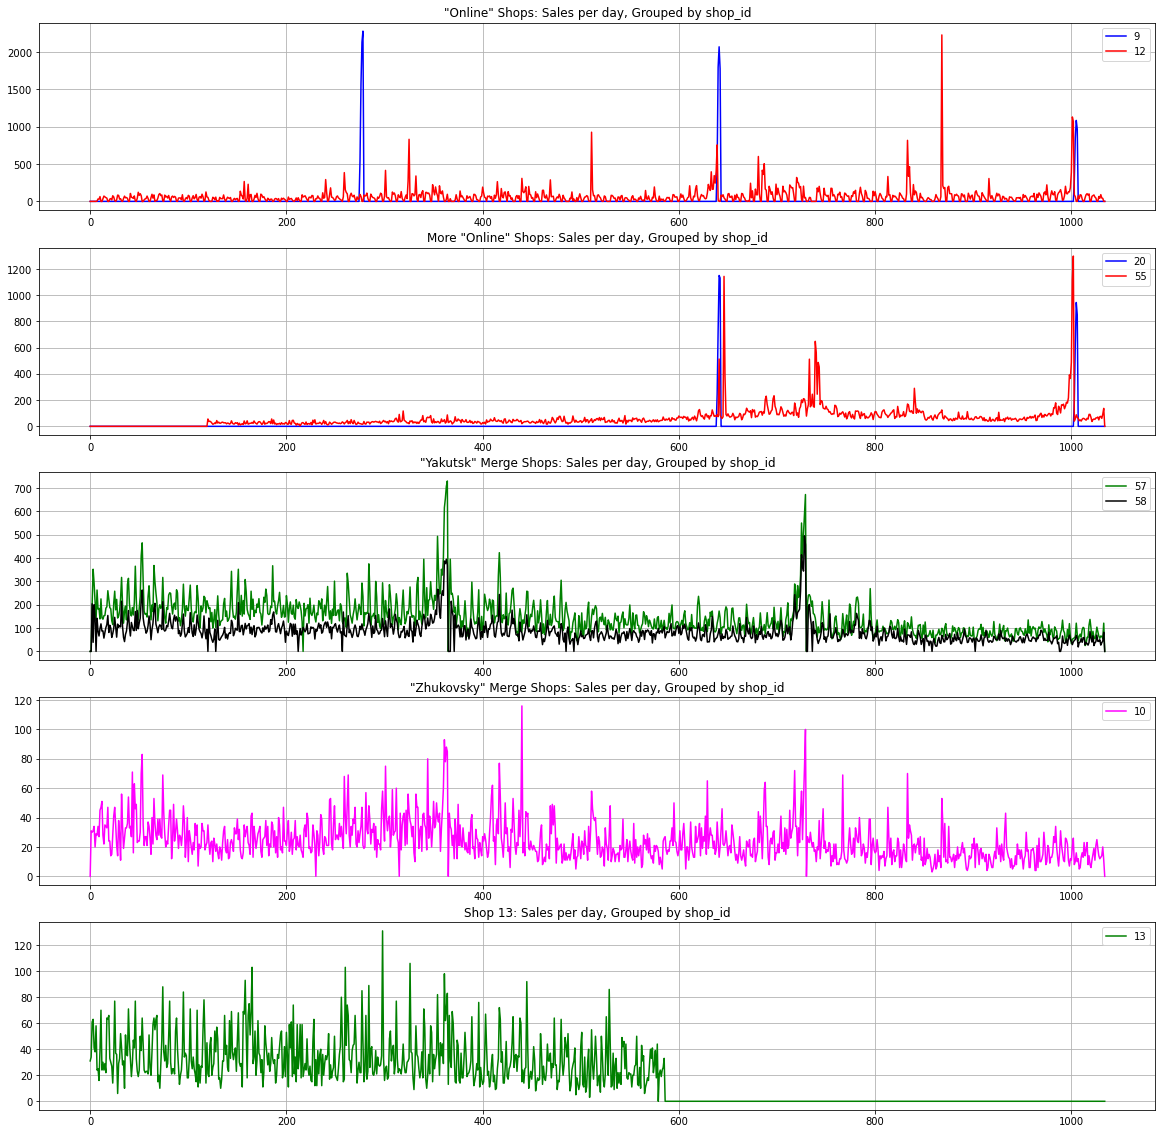

In [ ]:
'''
Line Plot Inputs & Parameters
'''
categories_online = [9,12] #[9,12,20,40,55]  # x-axis is index (time period)
categories_online2 = [20,55]
categories_yak = [57,58] #,58] #[0,57,1,58]
categories_z = [10] #10,11]
categories_13 = [13]
colors_online = pltcolors[:2]
colors_online2 = pltcolors[:2]
colors_yak = pltcolors[2:4]
colors_z = pltcolors[5]
colors_13 = pltcolors[2]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = False #(-10,1000)

print(f'Plotted at: {strftime("%a %X %x")}\n')

'''
Generate the Plots
'''
fig = plt.figure(figsize=(20,20)) 
axOnline = fig.add_subplot(5,1,1)
axOnline.set_title(f'"Online" Shops: Sales per day, Grouped by shop_id')
axOnline2 = fig.add_subplot(5,1,2)
axOnline2.set_title(f'More "Online" Shops: Sales per day, Grouped by shop_id')
axYak = fig.add_subplot(5,1,3)
axYak.set_title(f'"Yakutsk" Merge Shops: Sales per day, Grouped by shop_id')
axZ = fig.add_subplot(5,1,4)
axZ.set_title(f'"Zhukovsky" Merge Shops: Sales per day, Grouped by shop_id')
ax13 = fig.add_subplot(5,1,5)
ax13.set_title(f'Shop 13: Sales per day, Grouped by shop_id')

day_shop_piv.plot(y=categories_online, kind='line',color=colors_online,grid=True, ax=axOnline)
day_shop_piv.plot(y=categories_online2, kind='line',color=colors_online2,grid=True, ax=axOnline2)
day_shop_piv.plot(y=categories_yak, kind='line',color=colors_yak,grid=True, ax=axYak)
day_shop_piv.plot(y=categories_z, kind='line',color=colors_z,grid=True, ax=axZ)
day_shop_piv.plot(y=categories_13, kind='line',color=colors_13,grid=True, ax=ax13)

plt.show()

#**6. EDA of shops: look at sales by day for all shops**

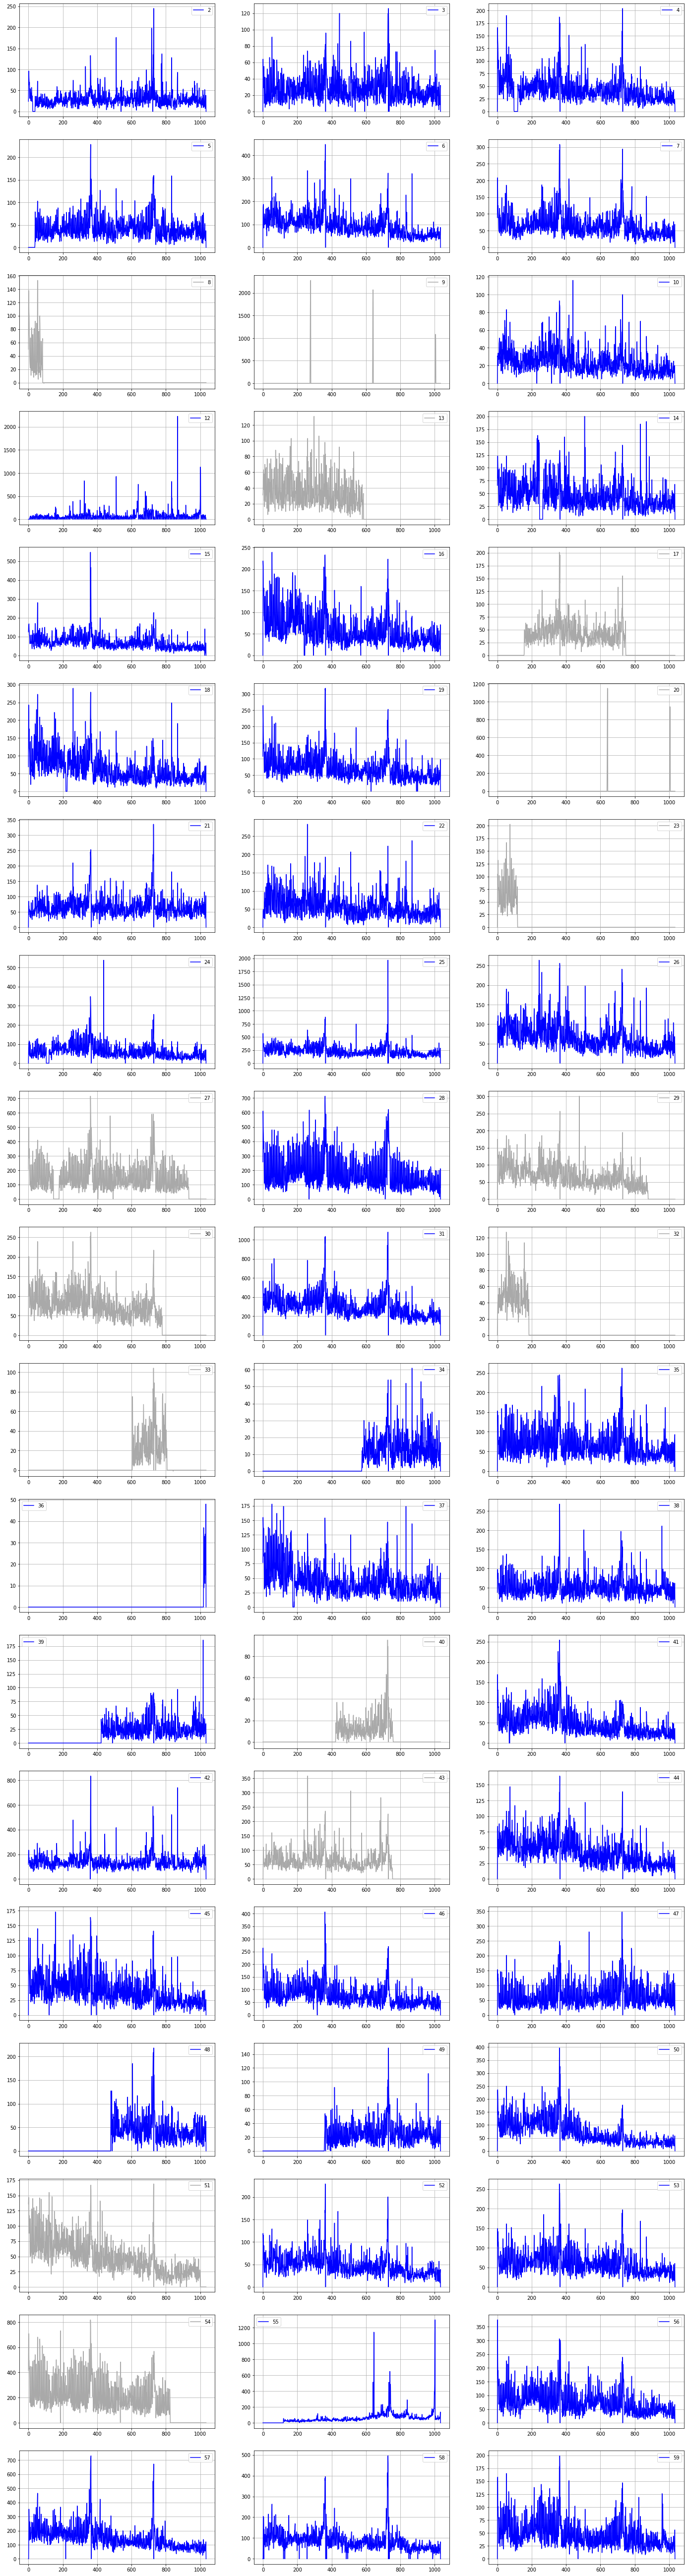

In [ ]:
# plot every one of the shops' sales by day, and see if there are any other interesting things ...
'''
Line Plot Inputs & Parameters
'''
n_shops = 60
shops_list = list(range(n_shops))
# remove the shops that were merged
shops_list.remove(0)
shops_list.remove(1)
shops_list.remove(11)

ax = []
n_plot_cols = 3
n_plot_rows = 19

fig = plt.figure(figsize=(8*n_plot_cols, 5*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1

#8, 23 into 55, 32, 33

###EDA of shops: look at sales by day for all shops, grouped and scaled
* Plot every one of the shops' sales by day, and see if there are any other interesting things ...
* But, this time, try applying a min-max scaler, after clipping values to 99.9th ptile (to reduce the impact of anomalous spikes on scaling)
* Also, group some of the plots together by their characteristic spikiness, negative slope, etc.

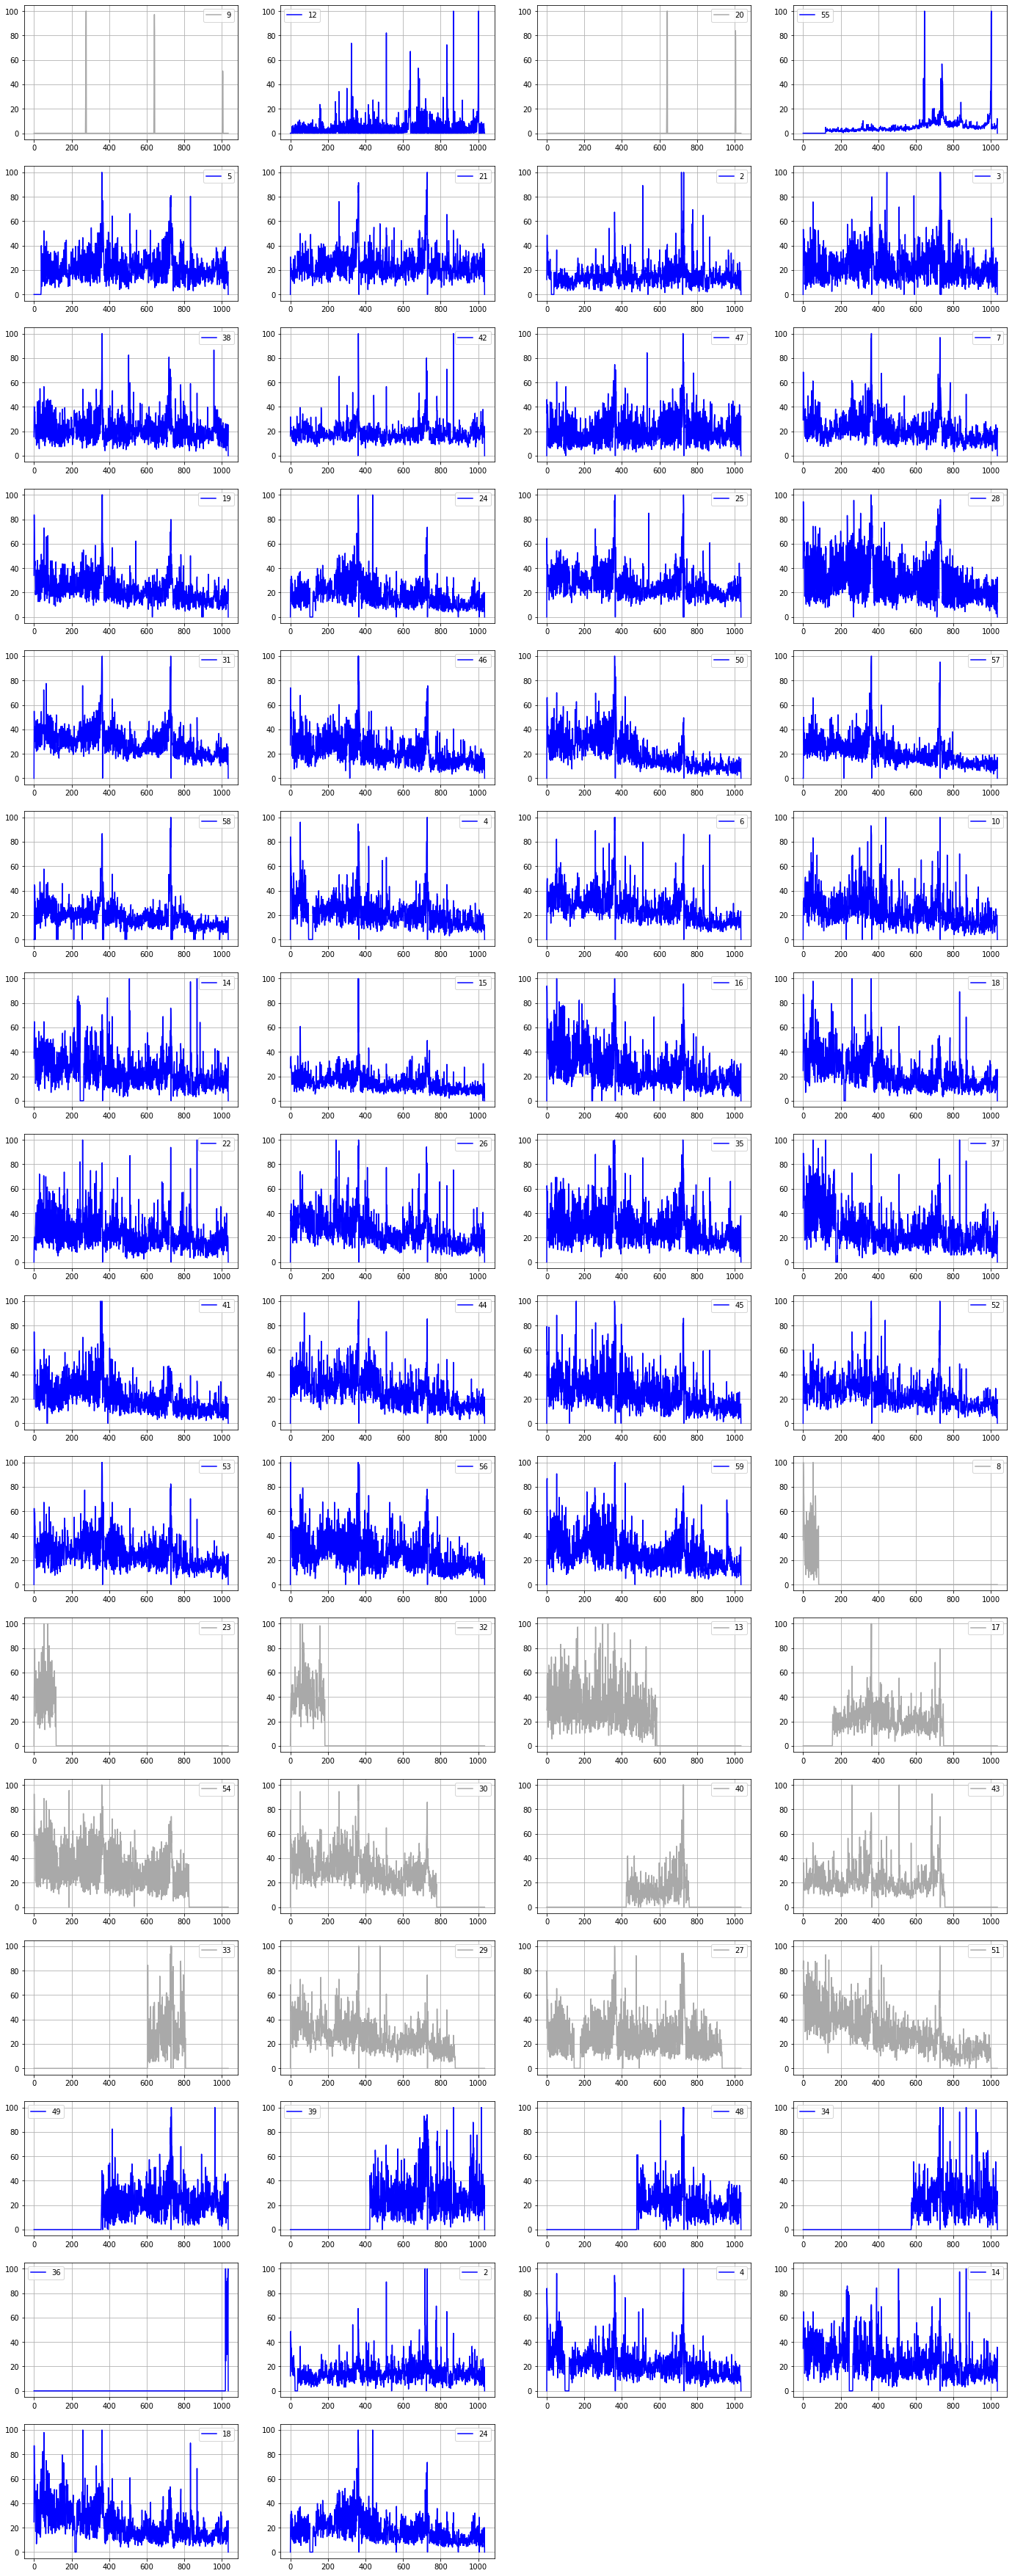

In [ ]:
# plot every one of the shops' sales by day, and see if there are any other interesting things ...
#     but, this time, try applying a min-max scaler, after clipping values to 99.9th ptile (to reduce the impact of anomalous spikes on scaling)
#     also, group some of the plots together by their characteristic spikiness, negative slope, etc.

# shop groups
extreme_spikes = [9, 12, 20, 55]       # so spiky that you can't tell if there is any slope
flat_spiky = [2, 3, 38, 42, 47]     # flat slope, spiky/noisy behavior
flat_ny = [5, 21]                   # flat slope, with dominant surges at New Year
neg_spiky = [4, 6, 10, 14, 15, 16, 18, 22, 26, 35, 37, 41, 44, 45, 52, 53, 56, 59]
neg_ny = [7, 19, 24, 25, 28, 31, 46, 50, 57, 58]
partial = [8, 23, 32, 13, 17, 54, 30, 40, 43, 33, 29, 27, 51, 49, 39, 48, 34, 36]  # shops that don't show sales over the full range of days in months 0 to 33
dropouts = [2, 4, 14, 18, 24]       # shops that have small but significant no-sales regions in the middle of their sales windows

shops_list = extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 62 shops in this list (dropouts are repeat plots)

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 4
n_plot_rows = 16

fig = plt.figure(figsize=(6*n_plot_cols, 4*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv_sc.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1


###EDA of shops: look again at spikes in online shops, particularly (untested) \#9 and 20:
* Are they irrelevant?
* They are so unlike other shops in sales behavior vs. time that it would be nice to delete them from training

In [ ]:
# Firstly, what items/categories and days are related to the spikes in sales in shops 9 and 20?:

spiky9_20 = tt[['day','DoM','month','price','sales','shop_id','item_id','item_name','it_test','item_category_id','item_category_name','it_cat_test']].query('(shop_id == 9)|(shop_id == 20)').copy(deep=True)
spiky9_20.price = spiky9_20.price.apply(lambda x: round(x) if (x > 10) else x)
spiky9_20.item_name = spiky9_20.item_name.apply(lambda x: x[:30])
spiky9_20.item_category_name = spiky9_20.item_category_name.apply(lambda x: x[:25])
print(f'Number of unique item_ids sold by shops 9 and 20 combined: {spiky9_20.item_id.nunique()}')
print(f'Number of unique item_ids sold by shop 9:  {spiky9_20[spiky9_20.shop_id == 9].item_id.nunique()}')
print(f'Number of unique item_ids sold by shop 20: {spiky9_20[spiky9_20.shop_id == 20].item_id.nunique()}\n')
print(spiky9_20, '\n')

# almost every sale is in October 2013, 2014, 2015, and sales reported only on days of month = 1,2,3,4,5,6  (with 1 sale each on day of month 14 and 22)
# 1664 different item IDs, although item_name[:30] only has 1394 unique values;  of the reported individual sales, 2511 have items that are not tested, and 3032 have items that are tested
# sales are primarily in the gifts-souvenirs categories, then pc/console games  .... 13 of the sales involved categories are not in the test set, whereas 5530 of the sales involved categories in the test set

# As essentially all sales from 9 and 20 are in October, and these 2 shops are not in the test set, the sales_train rows for these two shops are irrelevant on their own
#   We should keep them only if they form a significant fraction of the sales_train rows for a certain item or category that is in the test set --> look at Oct 2015, maybe also Oct 2014
#   or, if we can determine that lag=1 month for these shops 9, 20 is very helpful in predicting sales of other shops (in November) --> look at Oct/Nov 2014

print('Note: Month 9 = October 2013;  Month 21 = October 2014;  Month 33 = October 2015')

df1_styler = spiky9_20['DoM'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Day of Month')
df2_styler = spiky9_20['month'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Month Block Num')
df3_styler = spiky9_20['it_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Tested')
df4_styler = spiky9_20['item_id'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item ID')
df5_styler = spiky9_20['item_category_name'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Category Name')
df6_styler = spiky9_20['item_category_id'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Category ID')
df7_styler = spiky9_20['it_cat_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Category Tested')

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0" +
             df2_styler._repr_html_() + "\xa0\xa0\xa0" +
             df3_styler._repr_html_() + "\xa0\xa0\xa0" +
             df4_styler._repr_html_() + "\xa0\xa0\xa0" +
             df5_styler._repr_html_() + "\xa0\xa0\xa0" +
             df6_styler._repr_html_() + "\xa0\xa0\xa0" +
             df7_styler._repr_html_(), raw=True)

Number of unique item_ids sold by shops 9 and 20 combined: 1664
Number of unique item_ids sold by shop 9:  1404
Number of unique item_ids sold by shop 20: 746

          day  DoM  month  price  sales  shop_id  item_id                       item_name  it_test  item_category_id         item_category_name  it_cat_test
938244    275    3      9    599      7        9     1448    arma lll pc russian subtitle    False                28  Games PC - Additional pub         True
938245    275    3      9    299      6        9     1516  assassin creed iv black flag c    False                30  Games PC - Standard Editi         True
938246    275    3      9    249      1        9     1915     bestseller stalker pc jewel    False                30  Games PC - Standard Editi         True
938247    275    3      9    249      2        9     1916  bestseller sid meiers civiliza     True                30  Games PC - Standard Editi         True
938248    275    3      9    599      1        9     19

Day of Month DoM 
 
 4 
 1630 
 
 
 3 
 1362 
 
 
 5 
 1097 
 
 
 2 
 776 
 
 
 6 
 426 
 
 
 1 
 250 
 
 
 22 
 1 
 
 
 14 
 1 
 
     Month Block Num month 
 
 21 
 2362 
 
 
 33 
 1692 
 
 
 9 
 1488 
 
 
 27 
 1 
 
     Item Tested it_test 
 
 True 
 3032 
 
 
 False 
 2511 
 
     Item ID item_id 
 
 15213 
 16 
 
 
 15304 
 16 
 
 
 15261 
 15 
 
 
 11526 
 13 
 
 
 15279 
 13 
 
 
 9355 
 13 
 
 
 15262 
 13 
 
 
 15284 
 13 
 
 
 21119 
 12 
 
 
 15052 
 12 
 
 
 20735 
 12 
 
 
 20739 
 12 
 
 
 20350 
 12 
 
 
 20608 
 12 
 
 
 16264 
 11 
 
     Item Category Name item_category_name 
 
 Gifts - Attributes 
 1461 
 
 
 Gifts - Figures 
 878 
 
 
 Gifts - Soft Toys 
 589 
 
 
 Gifts - Souvenirs (weighe 
 452 
 
 
 Games PC - Standard Editi 
 379 
 
 
 Gifts - Souvenirs 
 346 
 
 
 Games - PS3 
 257 
 
 
 Books - Comics, Manga 
 198 
 
 
 Games - XBOX 360 
 195 
 
 
 Games PC - Additional pub 
 102 
 
 
 Gifts - Games (compact) 
 83 
 
 
 Games - PS4 
 70 
 
 
 Gifts - Board Games 
 56 
 
 
 Books - artbook, encyclop 
 55 
 
 
 Gifts - gadgets, robots, 
 45 
 
     Item Category ID item_category_id 
 
 61 
 1461 
 
 
 72 
 878 
 
 
 63 
 589 
 
 
 70 
 452 
 
 
 30 
 379 
 
 
 69 
 346 
 
 
 19 
 257 
 
 
 47 
 198 
 
 
 23 
 195 
 
 
 28 
 102 
 
 
 65 
 83 
 
 
 20 
 70 
 
 
 64 
 56 
 
 
 42 
 55 
 
 
 62 
 45 
 
     Item Category Tested it_cat_test 
 
 True 
 5530 
 
 
 False 
 13

In [ ]:
# Now, let's compare sales at shops 9 and 20 with all the other shops, by item --
#    Do other shops also sell the same items, or are 9 and 20 indespensible as the only shops to sell certain test items?

spiky9_20_items = spiky9_20[spiky9_20.it_test == True].item_id.unique()
tt_spiky_test_items = tt[tt.item_id.isin(spiky9_20_items)].copy(deep=True)
print(f'Number of unique items being explored: {tt_spiky_test_items.item_id.nunique()}\n')
spiky_items_allshops = tt_spiky_test_items.groupby(['month','item_id','item_category_id']).agg({'sales':'sum'}).reset_index()
spiky_items_shop9 = tt_spiky_test_items[tt_spiky_test_items.shop_id == 9].groupby(['month','item_id']).agg({'sales':'sum'}).reset_index().rename(columns={'sales':'sales9'})
spiky_items_shop20 = tt_spiky_test_items[tt_spiky_test_items.shop_id == 20].groupby(['month','item_id']).agg({'sales':'sum'}).reset_index().rename(columns={'sales':'sales20'})

spiky_items_allshops = spiky_items_allshops.merge(spiky_items_shop9, on=['month','item_id'], how='left').reset_index(drop=True)
spiky_items_allshops = spiky_items_allshops.merge(spiky_items_shop20, on=['month','item_id'], how='left').reset_index(drop=True).fillna(0)
spiky_items_allshops['minus9'] = spiky_items_allshops.sales - spiky_items_allshops.sales9
spiky_items_allshops['minus20'] = spiky_items_allshops.sales - spiky_items_allshops.sales20
print(f'df n_rows:  All Shops: {spiky_items_allshops.shape[0]}, Shop 9: {spiky_items_shop9.shape[0]}, Shop 20: {spiky_items_shop20.shape[0]}\n')
display(spiky_items_allshops.head())

# too many different items when looking by month... first let's compress to look at entire dataset and see if there are items only in 9 and 20 for the entire set,
#    then, we can look more closely at month-by-month numbers
sp_entire = spiky_items_allshops.groupby(['item_id','item_category_id']).agg({'sales':'sum','sales9':'sum','sales20':'sum','minus9':'sum','minus20':'sum'}).reset_index().copy(deep=True)
print(f'\ndf n_rows:  All Shops, Entire Train Set, Spiky Items from 9 and 20 in Test Set: {sp_entire.shape[0]}')
display(sp_entire.head())

display(sp_entire[sp_entire.sales9 > 0].sort_values(['minus9','item_id']).head(20))

# Some items in test set definitely are represented in train set only when associated with shops 9, 20
#   Let's gather item IDs / categories and names for the items that have > 90% of train rows coming from shops 9 or 20
sp_entire['need_shop9'] = sp_entire.sales9 > (0.9 * sp_entire.sales)
sp_entire['need_shop20'] = sp_entire.sales20 > (0.9 * sp_entire.sales)
sp_entire['need_shop9and20'] = (sp_entire.sales9 + sp_entire.sales20) > (0.9 * sp_entire.sales)
sp_entire.need_shop9and20 = sp_entire.apply(lambda row: (row.need_shop9and20 & (not row.need_shop9) & (not row.need_shop20)), axis=1)
display(sp_entire.head())
print(f'\nshape: {sp_entire.shape}, need_shop9 = {sp_entire.need_shop9.sum()}, need_shop20 = {sp_entire.need_shop20.sum()}, need_shop9and20 = {sp_entire.need_shop9and20.sum()}')

sp_need9_20 = sp_entire.query('need_shop9 | need_shop20 | need_shop9and20').copy(deep=True)
print(f'\nshape sp_need9_20 before merge: {sp_need9_20.shape}')
sp_need9_20 = sp_need9_20.merge(items_augmented[['item_id','item_name']], on='item_id', how='left')
sp_need9_20 = sp_need9_20.merge(item_categories_augmented[['item_category_id','en_cat_name']], on='item_category_id', how='left')
sp_need9_20.item_name = sp_need9_20.item_name.apply(lambda x: x[:30])
sp_need9_20.en_cat_name = sp_need9_20.en_cat_name.apply(lambda x: x[:25])
print(f'\nshape sp_need9_20 after merge: {sp_need9_20.shape}')
display(sp_need9_20.head(20))

#  meh... hard to say... probably easier to just run LGBM with and without the shops and see what happens


Number of unique items being explored: 758

df n_rows:  All Shops: 11253, Shop 9: 756, Shop 20: 437



month  item_id  item_category_id  sales  sales9  sales20  minus9  minus20
0      0     1467                19     39       0        0      39       39
1      0     1829                28    215       0        0     215      215
2      0     1837                23     37       0        0      37       37
3      0     1905                30    172       0        0     172      172
4      0     1916                30    258       0        0     258      258


df n_rows:  All Shops, Entire Train Set, Spiky Items from 9 and 20 in Test Set: 758


item_id  item_category_id  sales  sales9  sales20  minus9  minus20
0     1453                19    106       1        0     105      106
1     1467                19   1102       4        0    1098     1102
2     1483                23   1088      15        0    1073     1088
3     1485                19    792       5        0     787      792
4     1495                30   4860      35        0    4825     4860

item_id  item_category_id  sales  sales9  sales20  minus9  minus20
372    13647                69      3       3        0       0        3
558    17653                69      1       1        0       0        1
695    20999                61      1       1        0       0        1
701    21042                61      1       1        0       0        1
702    21045                61      1       1        0       0        1
725    21191                61      2       2        0       0        2
726    21197                61      1       1        0       0        1
355    13580                61      3       2        0       1        3
588    20336                72      2       1        1       1        1
592    20343                72      3       2        0       1        3
698    21010                61      2       1        0       1        2
704    21053                61      8       7        1       1        7
208     9205                61      6       4        0       2        6
356    13581                61      4       2        2       2        2
694    20998                61      3       1        2       2        1
718    21116                61      4       2        2       2        2
221     9329                70      4       1        1       3        3
354    13579                61      4       1        0       3        4
379    13667                69      8       5        0       3        8
586    20334                72      6       3        1       3        5

item_id  item_category_id  sales  sales9  sales20  minus9  minus20  need_shop9  need_shop20  need_shop9and20
0     1453                19    106       1        0     105      106       False        False            False
1     1467                19   1102       4        0    1098     1102       False        False            False
2     1483                23   1088      15        0    1073     1088       False        False            False
3     1485                19    792       5        0     787      792       False        False            False
4     1495                30   4860      35        0    4825     4860       False        False            False


shape: (758, 10), need_shop9 = 7, need_shop20 = 2, need_shop9and20 = 15

shape sp_need9_20 before merge: (24, 10)

shape sp_need9_20 after merge: (24, 12)


item_id  item_category_id  sales  sales9  sales20  minus9  minus20  need_shop9  need_shop20  need_shop9and20                       item_name                en_cat_name
0      9354                70     47      30       14      17       33       False        False             True  keychain metal gear solid v di  Gifts - Souvenirs (weighe
1     13581                61      4       2        2       2        2       False        False             True  purse adventure time jake diec         Gifts - Attributes
2     13647                69      3       3        0       0        3        True        False            False  mug battlefield hardline crimi          Gifts - Souvenirs
3     15499                63     12       5        6       7        6       False        False             True  soft toy pillow adventure time          Gifts - Soft Toys
4     17653                69      1       1        0       0        1        True        False            False            gift set wot warrior          Gifts - Souvenirs
5     19488                61      1       0        1       1        0       False         True            False  bag batman arkham knight black         Gifts - Attributes
6     20336                72      2       1        1       1        1       False        False             True  figurine adventure time cake p            Gifts - Figures
7     20998                61      3       1        2       2        1       False        False             True  t shirt assassin creed syndica         Gifts - Attributes
8     20999                61      1       1        0       0        1        True        False            False  t shirt assassin creed syndica         Gifts - Attributes
9     21042                61      1       1        0       0        1        True        False            False  t borderland claptrap assassin         Gifts - Attributes
10    21045                61      1       1        0       0        1        True        False            False        t borderland jack hero l         Gifts - Attributes
11    21046                61      1       0        1       1        0       False         True            False    shirt borderland jack hero m         Gifts - Attributes
12    21053                61      8       7        1       1        7       False        False             True  shirt call of duty black ops i         Gifts - Attributes
13    21116                61      4       2        2       2        2       False        False             True  shirt fallout vault boy face x         Gifts - Attributes
14    21123                61     10       5        5       5        5       False        False             True   shirt half life lambda logo l         Gifts - Attributes
15    21191                61      2       2        0       0        2        True        False            False       t payday 2 dallas mask xl         Gifts - Attributes
16    21197                61      1       1        0       0        1        True        False            False          t payday 2 wolf mask m         Gifts - Attributes
17    21207                61     13       7        6       6        7       False        False             True    shirt skyrim dragon symbol l         Gifts - Attributes
18    21208                61     12       5        7       7        5       False        False             True    shirt skyrim dragon symbol m         Gifts - Attributes
19    21213                61     12       6        5       6        7       False        False             True      shirt skyrim dragonborn xl         Gifts - Attributes

###EDA of shops: look again at spikes in online shops, smoothed by time
* See how spiky they are when we group by week, month, or by quarter

In [ ]:
# Group by month and shop_id to get each shop's sales by month
# Group by week and shop_id to get each shop's sales by week
# Group by quarter and shop_id to get each shop's sales by quarter
print(f'tt DataFrame: shape = {tt.shape}')
display(tt.head(3))
week_shop = tt.groupby(['week','shop_id']).agg({'sales':'sum'}).reset_index()
month_shop = tt.groupby(['month','shop_id']).agg({'sales':'sum'}).reset_index()
qtr_shop = tt.groupby(['qtr','shop_id']).agg({'sales':'sum'}).reset_index()
print(f'\nDataFrame Shape: grouped by week = {week_shop.shape}, grouped by month = {month_shop.shape}, grouped by qtr = {qtr_shop.shape}')
# display(week_shop.head())
# display(month_shop.head())
# display(qtr_shop.head())

shop_ids = qtr_shop.shop_id.unique()  # can be used for plotting

# Pivot the data to get plottable columns
week_shop_piv = week_shop.pivot(index='week',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
month_shop_piv = month_shop.pivot(index='month',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
qtr_shop_piv = qtr_shop.pivot(index='qtr',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
# display(week_shop_piv.head())
# display(month_shop_piv.head())
# display(qtr_shop_piv.head())

tt DataFrame: shape = (3150043, 23)


day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                                         item_name  it_test  item_category_id           item_category_name  it_cat_test item_cat3 item_cat4  \
0    0  Tue    1     0    0       2      0     99      1        2      991           3d action puzzle dinosaur tyrannosaurus    False                67          Gifts - Development         True     Gifts     Gifts   
1    0  Tue    1     0    0       2      0   2599      1        2     1472         assassin creed 3 xbox 360 russian version    False                23             Games - XBOX 360         True     Games      Xbox   
2    0  Tue    1     0    0       2      0    249      1        2     1905  bestseller grand theft auto san andreas pc jewel     True                30  Games PC - Standard Edition         True     Games        PC   

          shop_name sh_cat  sh_test district    city  
0  Adygea TC "Mega"   Mega     True    South  Adygea  
1  Adygea TC "Mega"   Mega     True    South  Adygea  
2  Adygea TC "Mega"   Mega     True    South  Adygea


DataFrame Shape: grouped by week = (6887, 3), grouped by month = (1628, 3), grouped by qtr = (611, 3)


Shop sales by week:



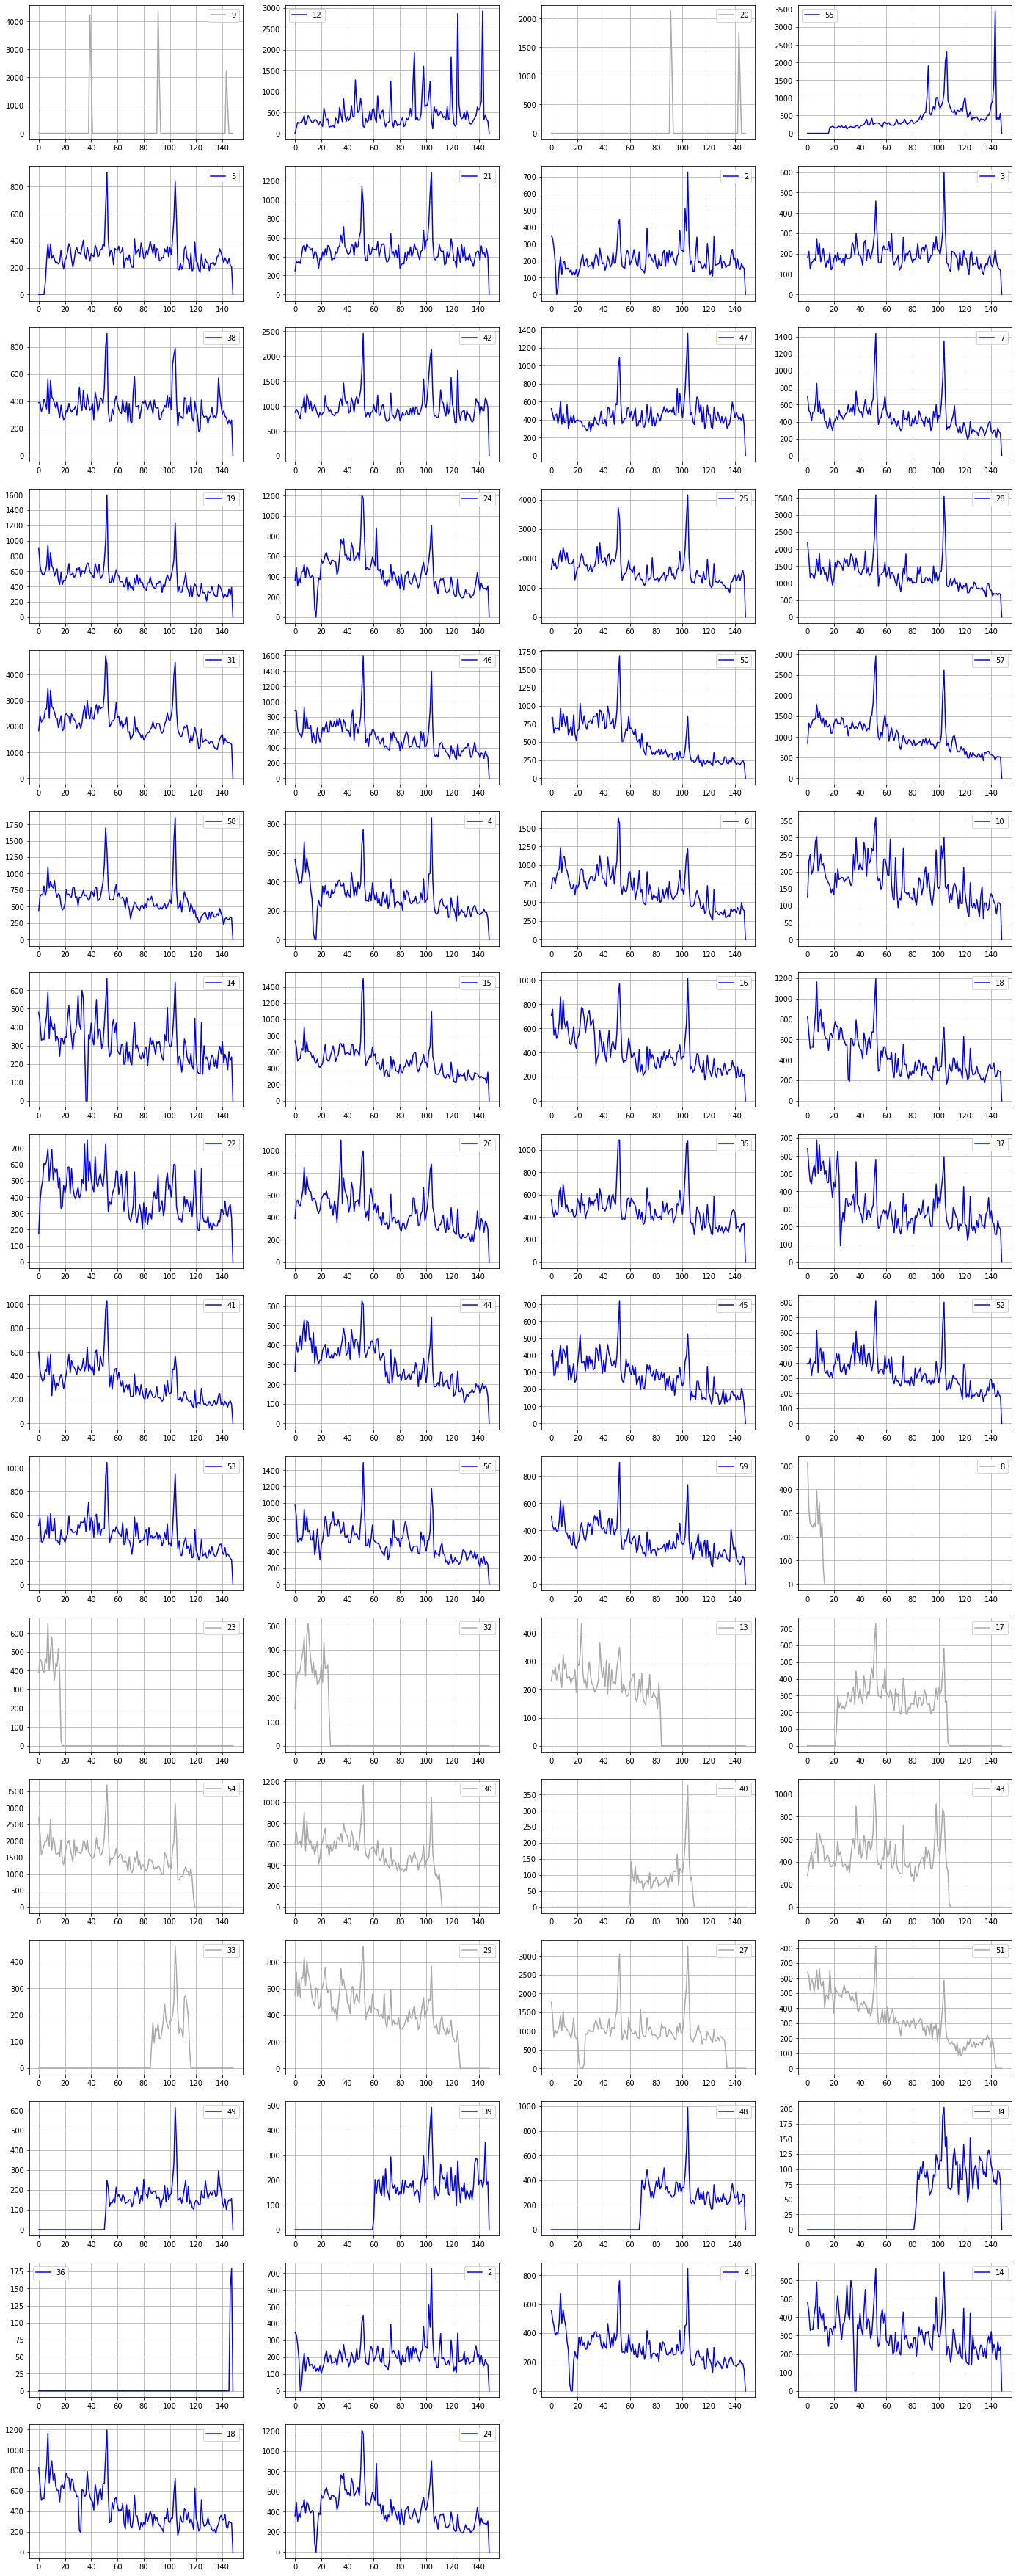

In [ ]:
# plot every one of the shops' sales by week, and see how it compares to shops by day from before
print("Shop sales by week:\n")
# Group some of the plots together by their characteristic spikiness, negative slope, etc.
# shop groups
extreme_spikes = [9, 12, 20, 55]       # so spiky that you can't tell if there is any slope
flat_spiky = [2, 3, 38, 42, 47]     # flat slope, spiky/noisy behavior
flat_ny = [5, 21]                   # flat slope, with dominant surges at New Year
neg_spiky = [4, 6, 10, 14, 15, 16, 18, 22, 26, 35, 37, 41, 44, 45, 52, 53, 56, 59]
neg_ny = [7, 19, 24, 25, 28, 31, 46, 50, 57, 58]
partial = [8, 23, 32, 13, 17, 54, 30, 40, 43, 33, 29, 27, 51, 49, 39, 48, 34, 36]  # shops that don't show sales over the full range of days in months 0 to 33
dropouts = [2, 4, 14, 18, 24]       # shops that have small but significant no-sales regions in the middle of their sales windows

shops_list = extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 62 shops in this list (dropouts are repeat plots)

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 4
n_plot_rows = 16

fig = plt.figure(figsize=(6*n_plot_cols, 4*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    week_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1

Shop sales by month:



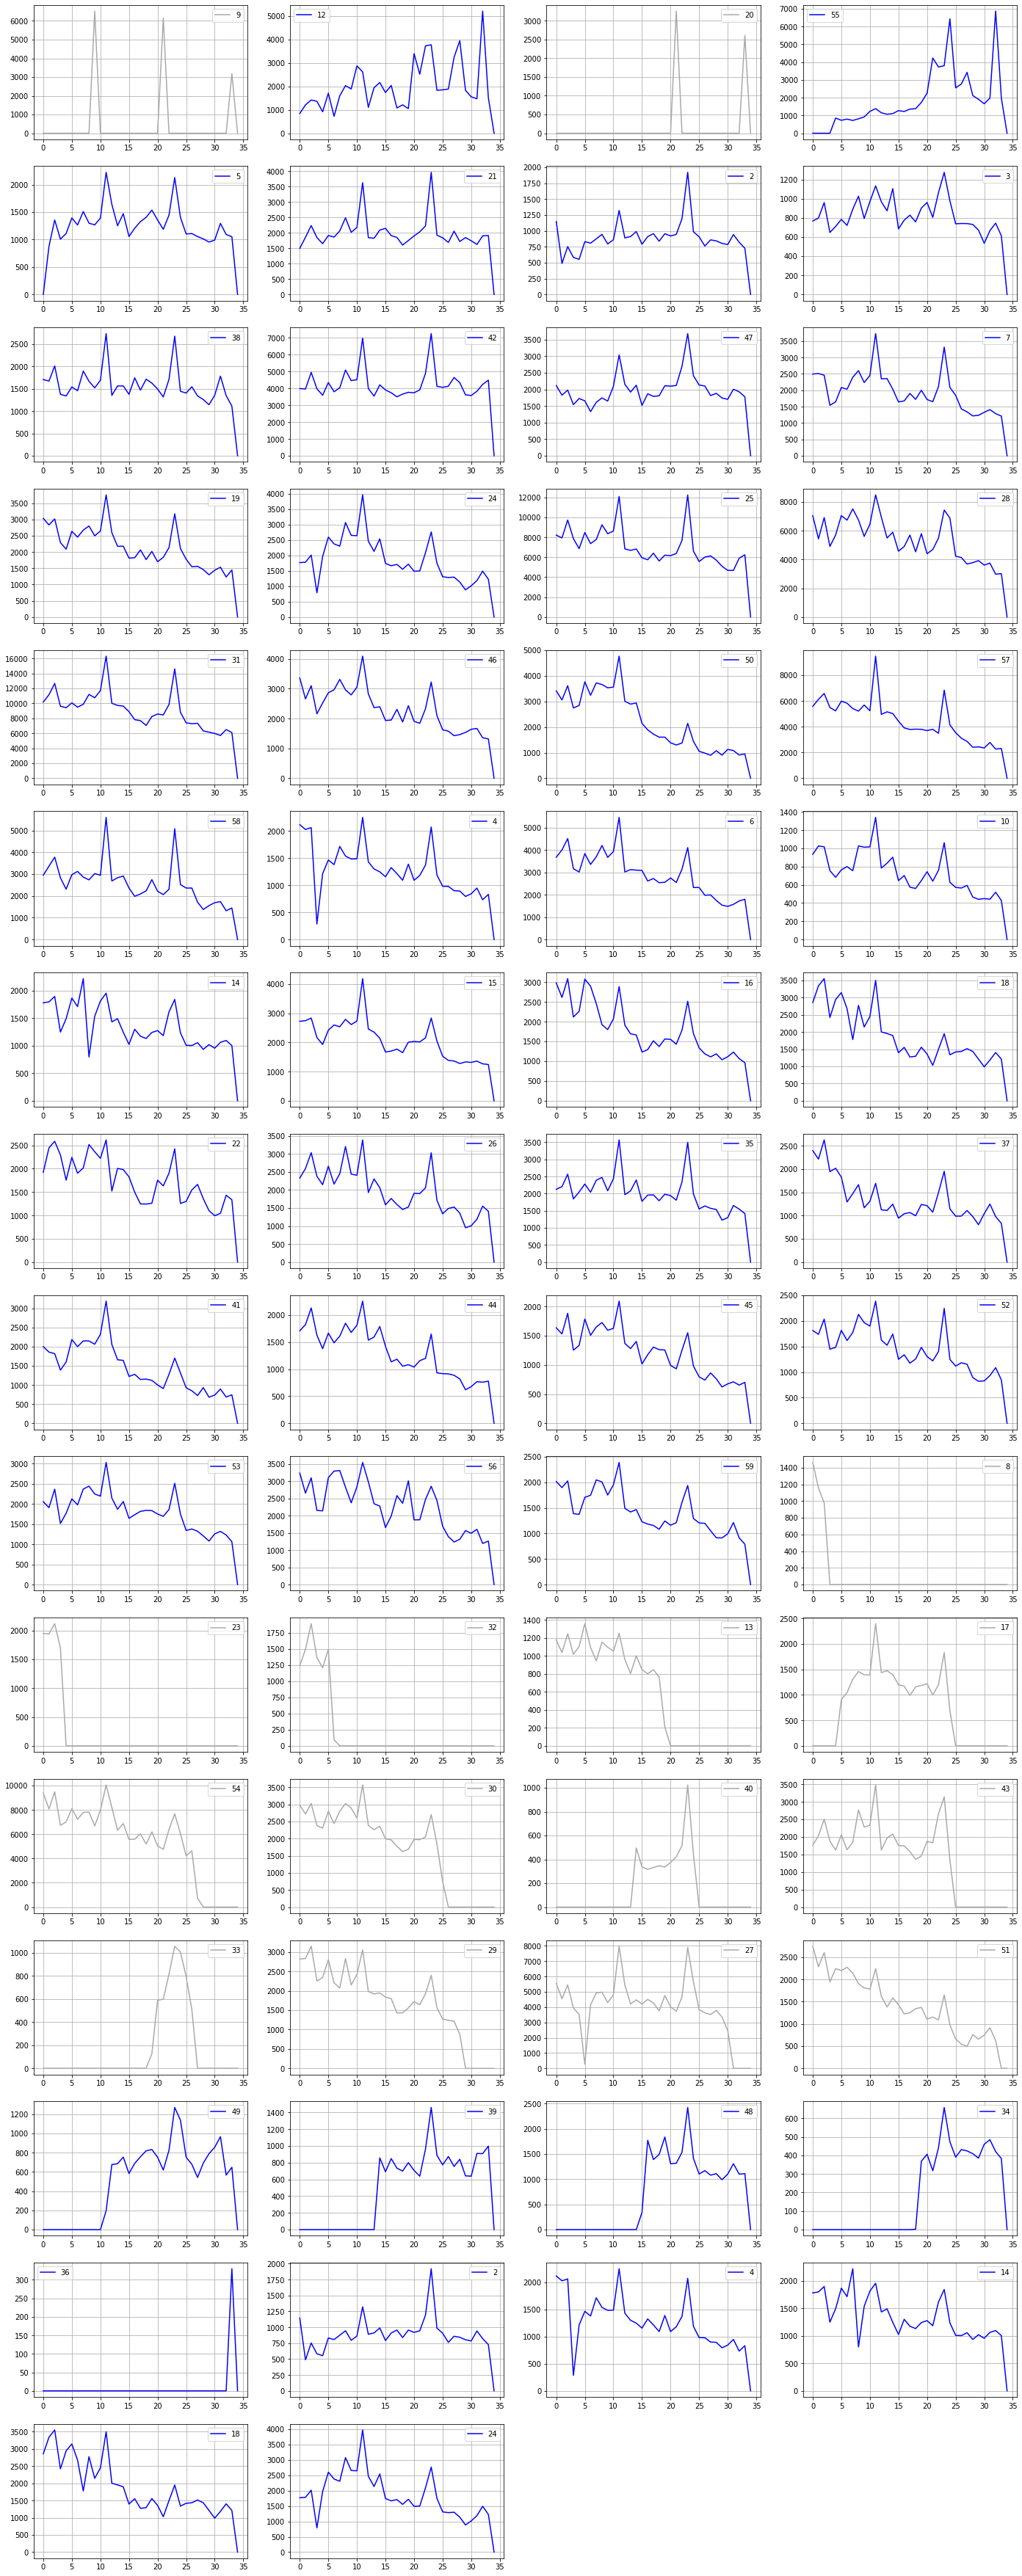

In [ ]:
# plot every one of the shops' sales by month, and see how it compares to shops by day from before
print("Shop sales by month:\n")
# Group some of the plots together by their characteristic spikiness, negative slope, etc.
# shop groups
extreme_spikes = [9, 12, 20, 55]       # so spiky that you can't tell if there is any slope
flat_spiky = [2, 3, 38, 42, 47]     # flat slope, spiky/noisy behavior
flat_ny = [5, 21]                   # flat slope, with dominant surges at New Year
neg_spiky = [4, 6, 10, 14, 15, 16, 18, 22, 26, 35, 37, 41, 44, 45, 52, 53, 56, 59]
neg_ny = [7, 19, 24, 25, 28, 31, 46, 50, 57, 58]
partial = [8, 23, 32, 13, 17, 54, 30, 40, 43, 33, 29, 27, 51, 49, 39, 48, 34, 36]  # shops that don't show sales over the full range of days in months 0 to 33
dropouts = [2, 4, 14, 18, 24]       # shops that have small but significant no-sales regions in the middle of their sales windows

shops_list = extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 62 shops in this list (dropouts are repeat plots)

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 4
n_plot_rows = 16

fig = plt.figure(figsize=(6*n_plot_cols, 4*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    month_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1

Shop sales by quarter:



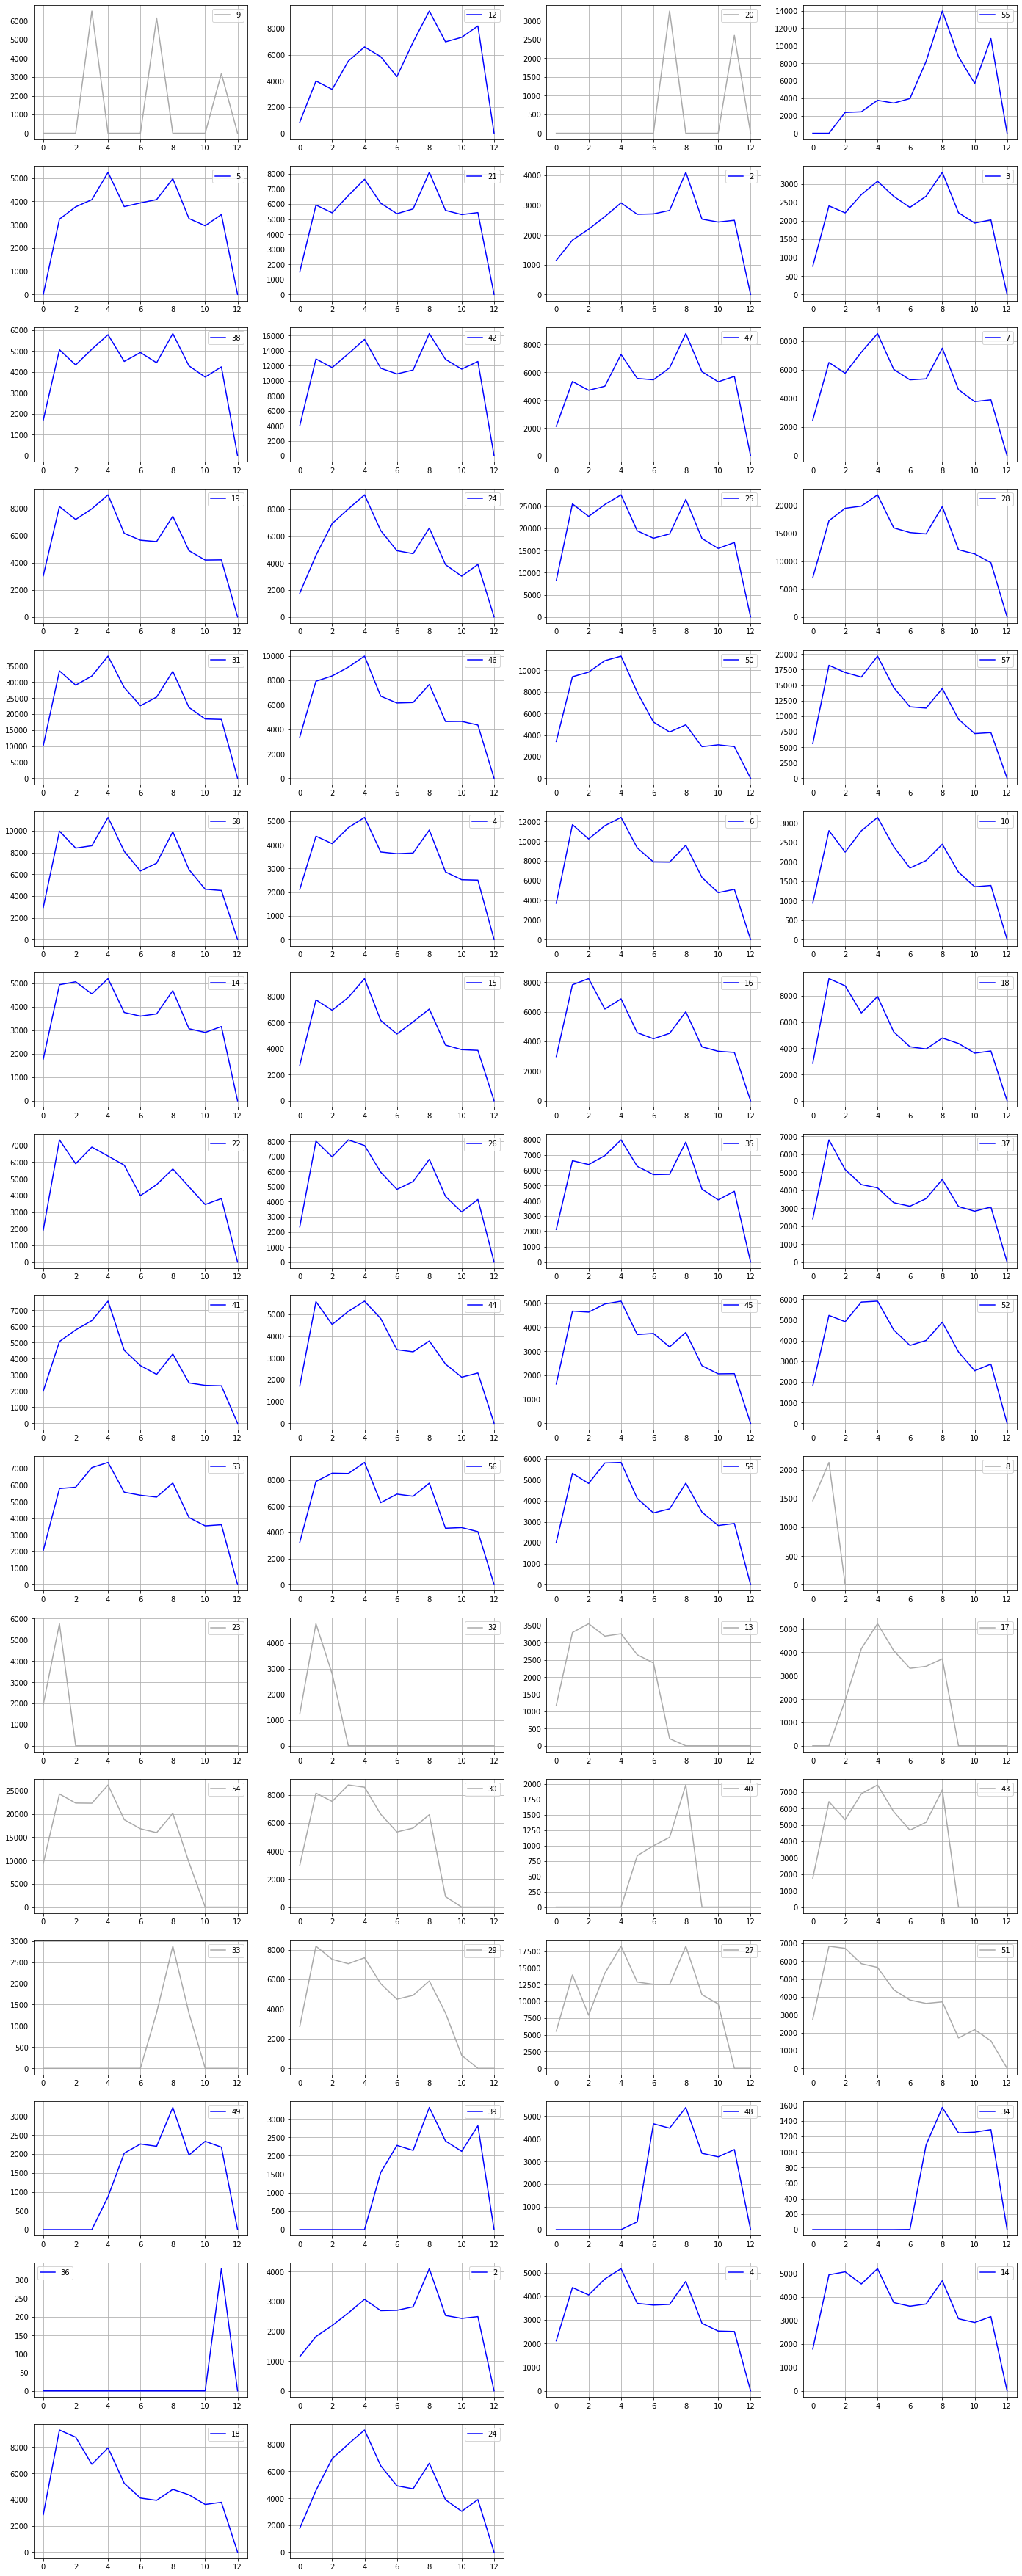

In [ ]:
# plot every one of the shops' sales by quarter, and see how it compares to shops by day from before
print("Shop sales by quarter:\n")
# Group some of the plots together by their characteristic spikiness, negative slope, etc.
# shop groups
extreme_spikes = [9, 12, 20, 55]       # so spiky that you can't tell if there is any slope
flat_spiky = [2, 3, 38, 42, 47]     # flat slope, spiky/noisy behavior
flat_ny = [5, 21]                   # flat slope, with dominant surges at New Year
neg_spiky = [4, 6, 10, 14, 15, 16, 18, 22, 26, 35, 37, 41, 44, 45, 52, 53, 56, 59]
neg_ny = [7, 19, 24, 25, 28, 31, 46, 50, 57, 58]
partial = [8, 23, 32, 13, 17, 54, 30, 40, 43, 33, 29, 27, 51, 49, 39, 48, 34, 36]  # shops that don't show sales over the full range of days in months 0 to 33
dropouts = [2, 4, 14, 18, 24]       # shops that have small but significant no-sales regions in the middle of their sales windows

shops_list = extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 62 shops in this list (dropouts are repeat plots)

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 4
n_plot_rows = 16

fig = plt.figure(figsize=(6*n_plot_cols, 4*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    qtr_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    plotcount += 1

# Seems to give a rather reasonable depiction of the sales, smoothing the spikes somewhat
# It might be more helpful to do a 6 week or a 2 or 3 month rolling average

###EDA of shops: what to do about short duration of shop 36 sales?
* Can we (should we?) augment to at least get a full month of data?
* Should we scale output prediction by amount of time shop 36 is open?

In [ ]:
# Can we assist training of shop 36, as it only has sales at the very end of the time period?
#  Let's consider 36 vs. 37 (both are shops from Novosibirsk) and other shops
siberian = [36,37,48] #[17, 18, 36, 37, 38, 48]
novo = tt[['day','DoM','month','price','sales','shop_id','item_id','item_name','it_test','item_category_id','item_category_name','it_cat_test']].copy(deep=True)
novo = novo[novo.shop_id.isin(siberian)]
novo.price = novo.price.apply(lambda x: round(x) if (x > 10) else x)
novo.item_name = novo.item_name.apply(lambda x: x[:30])
novo.item_category_name = novo.item_category_name.apply(lambda x: x[:25])
novo = novo.rename(columns={'DoM':'DoM','item_category_id':'icatID','it_cat_test':'ic_test'})
display(novo.head())
print('\n')

from IPython.display import display_html 

df1_styler = novo['DoM'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Day of Month')
df2_styler = novo['month'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Month Block')
df3_styler = novo['it_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Tested')
df4_styler = novo['item_id'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item ID')
df5_styler = novo['item_category_name'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Category Name')
df6_styler = novo['icatID'].value_counts().to_frame().iloc[:15,:].style.set_table_attributes("style='display:inline'").set_caption('Item Cat ID')
df7_styler = novo['ic_test'].value_counts().to_frame().style.set_table_attributes("style='display:inline'").set_caption('Item Cat Tested')

display_html(df1_styler._repr_html_() + "\xa0\xa0\xa0" +
             df2_styler._repr_html_() + "\xa0\xa0\xa0" +
             df3_styler._repr_html_() + "\xa0\xa0\xa0" +
             df4_styler._repr_html_() + "\xa0\xa0\xa0" +
             df5_styler._repr_html_() + "\xa0\xa0\xa0" +
             df6_styler._repr_html_() + "\xa0\xa0\xa0" +
             df7_styler._repr_html_(), raw=True)

day  DoM  month  price  sales  shop_id  item_id                       item_name  it_test  icatID         item_category_name  ic_test
900    0    1      0    399      1       37       98              1812 lancer ballad    False      40                Movie - DVD     True
901    0    1      0    199      1       37      560  1c education collection englis     True      77      Program - Educational     True
902    0    1      0    149      2       37      657  1c education collection simula    False      77      Program - Educational     True
903    0    1      0    599      1       37     1470  assassin creed 3 pc jewel russ    False      30  Games PC - Standard Editi     True
904    0    1      0   1249      1       37     1713  blackmores night knight in yor    False      58              Music - Vinyl     True

Day of Month DoM 
 
 1 
 17411 
 
 
 27 
 2249 
 
 
 2 
 2218 
 
 
 23 
 2201 
 
 
 28 
 2175 
 
 
 21 
 2106 
 
 
 26 
 2099 
 
 
 17 
 2061 
 
 
 6 
 2041 
 
 
 3 
 2031 
 
 
 22 
 2024 
 
 
 9 
 2002 
 
 
 19 
 1999 
 
 
 4 
 1983 
 
 
 20 
 1982 
 
 
 5 
 1981 
 
 
 10 
 1980 
 
 
 24 
 1972 
 
 
 7 
 1963 
 
 
 13 
 1958 
 
 
 30 
 1949 
 
 
 18 
 1933 
 
 
 8 
 1922 
 
 
 12 
 1903 
 
 
 14 
 1892 
 
 
 25 
 1890 
 
 
 11 
 1885 
 
 
 16 
 1844 
 
 
 29 
 1819 
 
 
 15 
 1785 
 
 
 31 
 1598 
 
     Month Block month 
 
 34 
 15300 
 
 
 23 
 3617 
 
 
 19 
 2537 
 
 
 22 
 2336 
 
 
 2 
 2330 
 
 
 31 
 2319 
 
 
 16 
 2313 
 
 
 24 
 2311 
 
 
 0 
 2241 
 
 
 18 
 2194 
 
 
 17 
 2178 
 
 
 21 
 2073 
 
 
 30 
 2017 
 
 
 1 
 1989 
 
 
 26 
 1989 
 
 
 20 
 1983 
 
 
 33 
 1949 
 
 
 25 
 1910 
 
 
 4 
 1884 
 
 
 32 
 1836 
 
 
 3 
 1818 
 
 
 29 
 1694 
 
 
 27 
 1685 
 
 
 28 
 1660 
 
 
 5 
 1507 
 
 
 11 
 1450 
 
 
 7 
 1279 
 
 
 8 
 1224 
 
 
 6 
 1182 
 
 
 15 
 1065 
 
 
 14 
 1036 
 
 
 12 
 1022 
 
 
 10 
 991 
 
 
 13 
 971 
 
 
 9 
 966 
 
     Item Tested it_test 
 
 True 
 52868 
 
 
 False 
 23988 
 
     Item ID item_id 
 
 20949 
 1170 
 
 
 17717 
 328 
 
 
 2808 
 248 
 
 
 6497 
 208 
 
 
 2308 
 191 
 
 
 6503 
 185 
 
 
 4351 
 168 
 
 
 4870 
 167 
 
 
 3734 
 161 
 
 
 4244 
 152 
 
 
 4181 
 146 
 
 
 6675 
 145 
 
 
 1855 
 131 
 
 
 3077 
 129 
 
 
 4248 
 127 
 
     Item Category Name item_category_name 
 
 Music - CD of local produ 
 12766 
 
 
 Games PC - Standard Editi 
 8984 
 
 
 Movie - DVD 
 8388 
 
 
 Movie - Blu-Ray 
 5212 
 
 
 Games - PS3 
 4919 
 
 
 Games - XBOX 360 
 4827 
 
 
 Games PC - Additional pub 
 3192 
 
 
 Games - PS4 
 2691 
 
 
 Gifts - Figures 
 2032 
 
 
 Gifts - Soft Toys 
 1397 
 
 
 Gifts - Games (compact) 
 1333 
 
 
 Movie - Blu-Ray 3D 
 1333 
 
 
 Gifts - Board Games 
 1185 
 
 
 Gifts - Bags, Albums, Mat 
 1170 
 
 
 Gifts - Souvenirs (weighe 
 1087 
 
     Item Cat ID icatID 
 
 55 
 12766 
 
 
 30 
 8984 
 
 
 40 
 8388 
 
 
 37 
 5212 
 
 
 19 
 4919 
 
 
 23 
 4827 
 
 
 28 
 3192 
 
 
 20 
 2691 
 
 
 72 
 2032 
 
 
 63 
 1397 
 
 
 38 
 1333 
 
 
 65 
 1333 
 
 
 64 
 1185 
 
 
 71 
 1170 
 
 
 70 
 1087 
 
     Item Cat Tested ic_test 
 
 True 
 76393 
 
 
 False 
 463

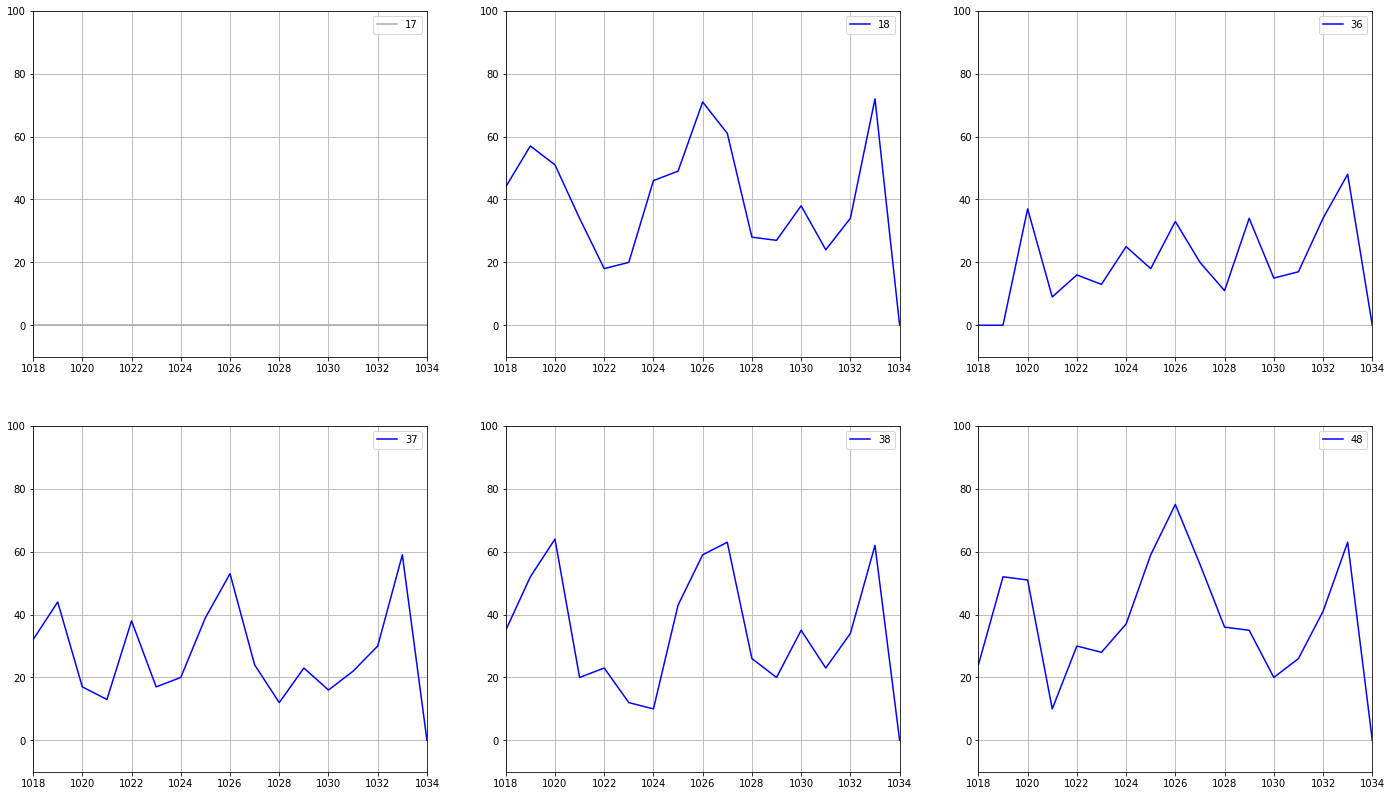

In [ ]:
# plot every one of the Siberian shops' sales by day, and see if there are any other interesting things that can help us augment shop 36 (active only last 2 weeks or so) ...

# Group some of the plots together by their characteristic spikiness, negative slope, etc.

# shop groups
siberian = [17, 18, 36, 37, 38, 48]
shops_list = siberian #extreme_spikes + flat_ny + flat_spiky + neg_ny + neg_spiky + partial + dropouts
# = 6 shops in this list

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 3
n_plot_rows = 2

fig = plt.figure(figsize=(8*n_plot_cols, 7*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    ax[-1].set_xlim(1018,1034)
    ax[-1].set_ylim(-10,100)
    plotcount += 1


###EDA of shops: clipping outliers that aren't so extreme that we need to delete them
* clip shop 24 spike around day 450
* clip shop 25 spike near 730
* clip shop 39 spike around day 1000

day  DoW  DoM  week  qtr  season  month  price  sales  shop_id  item_id                 item_name  it_test  item_category_id item_category_name  it_cat_test item_cat3 item_cat4                              shop_name  \
2907439  1017  Thu   15   145   11       3     33    199     57       39    11055      divergent bluray dvd     True                37    Movie - Blu-Ray         True    Movies    Movies  RostovNaDonu TRC "Megacenter Horizon"   
2907444  1017  Thu   15   145   11       3     33    199     30       39    16629           left bluray dvd     True                37    Movie - Blu-Ray         True    Movies    Movies  RostovNaDonu TRC "Megacenter Horizon"   
2907446  1017  Thu   15   145   11       3     33    199     33       39    17270  last boundary bluray dvd     True                37    Movie - Blu-Ray         True    Movies    Movies  RostovNaDonu TRC "Megacenter Horizon"   
2907449  1017  Thu   15   145   11       3     33    199     45       39    21811          shaka bluray dvd     True                37    Movie - Blu-Ray         True    Movies    Movies  RostovNaDonu TRC "Megacenter Horizon"   

        sh_cat  sh_test district           city  
2907439    SEC     True    South  Rostov-on-Don  
2907444    SEC     True    South  Rostov-on-Don  
2907446    SEC     True    South  Rostov-on-Don  
2907449    SEC     True    South  Rostov-on-Don

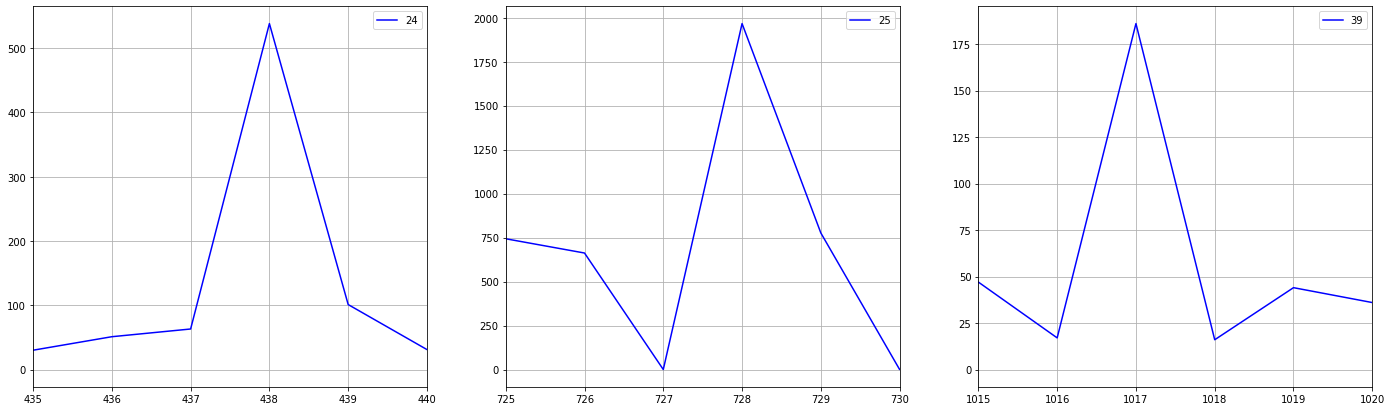

In [ ]:
# plot each of the shops to help identify the exact training row of interest

# df = tt.query('(shop_id == 24) | (shop_id == 25) | (shop_id == 39)').copy(deep=True)
df = tt.query('shop_id == 39').copy(deep=True)
# df = df.query('(day == 438) | (day == 728) | (day == 1017)')
df = df.query('day == 1017')
df = df.query('sales > 20')
display(df)
print('\n')

# shop groups
shops_list = [24,25,39]

'''
Line Plot Inputs & Parameters
'''
ax = []
n_plot_cols = 3
n_plot_rows = 1

fig = plt.figure(figsize=(8*n_plot_cols, 7*n_plot_rows))
plotcount = 1
for s in shops_list:
    pltcolor='blue'
    if not shops_augmented.at[s,'shop_tested']:
        pltcolor = 'darkgray'
    ax.append(fig.add_subplot(n_plot_rows,n_plot_cols,plotcount))
    day_shop_piv.plot(y=[s],kind='line',color=pltcolor,grid=True,ax=ax[-1])
    #ax[-1].set_xlim(950,1040)
    #ax[-1].set_ylim(-10,100)
    plotcount += 1

ax[0].set_xlim(435,440)
ax[1].set_xlim(725,730)
ax[2].set_xlim(1015,1020)
plt.show()


#Correlations

##Correlation shop-shop by item_id sales in full time period


In [ ]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 20
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 880         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 8
n_ids = len(shops_augmented)

group_time_period = 'item_id'
group_category = 'shop_id'
agg_column = 'sales'                # sum of this when grouping by the above
category_names = {'print':True, 'df':shops_augmented, 'column':'en_shop_name'}   # when printing out the final clusters, if print=True, use this dataframe and column to return the names (assuming row# = category id)

print(f'done: {strftime("%a %X %x")}\n')

done: Tue 21:26:25 06/16/20



In [ ]:
# look at correlation between shops by # sales of each item (summed over full time period, scaled with min/max minus 99th ptile clip)
dfshop_item = tt.groupby(['shop_id','item_id']).agg({'month':'mean', 'week':'mean','DoM':'mean','sales':'sum'}).reset_index()
dfshop_item = dfshop_item.pivot(index='item_id',columns='shop_id',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
# create a version of the table, using scaled versions of all categories, for easier comparison and normalized correlation
qt = dfshop_item.quantile(0.999)
sc = MinMaxScaler((0,100))
dfshop_item_sc = dfshop_item.copy(deep=True)
for sh in tt.shop_id.unique():
    dfshop_item_sc[sh] = dfshop_item_sc[sh].clip(0,qt[sh])
    dfshop_item_sc[sh] = sc.fit_transform(dfshop_item_sc[sh].to_numpy().reshape(-1,1))
dfshop_item_sc.index = dfshop_item_sc.item_id
dfshop_item_sc.drop('item_id',axis=1,inplace=True)
dfshop_item_sc.insert(0,0,0)
dfshop_item_sc.insert(1,1,0)
dfshop_item_sc.insert(11,11,0)
display(dfshop_item_sc.describe())
print('\n')
display(dfshop_item_sc.head())

0     1     2     3     4     5     6     7     8     9     10    11    12  ...    47    48      49    50    51    52    53    54    55    56    57    58    59
count 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169  ... 22169 22169   22169 22169 22169 22169 22169 22169 22169 22169 22169 22169 22169
mean      0     0 1.324 1.561 1.449 1.787 1.824 1.825 1.561 0.708 1.560     0 0.880  ... 1.774 1.488   1.645 2.160 2.406 1.563 1.664 3.021 0.650 2.437 2.613 2.094 1.522
std       0     0 6.083 6.314 5.809 6.304 5.791 6.543 7.153 5.166 5.984     0 4.777  ... 6.508 6.428   6.728 6.983 6.934 5.870 6.367 7.779 5.034 6.710 7.134 6.920 5.886
min       0     0     0     0     0     0     0     0     0     0     0     0     0  ...     0     0       0     0     0     0     0     0     0     0     0     0     0
25%       0     0     0     0     0     0     0     0     0     0     0     0     0  ...     0     0       0     0     0     0     0     0     0     0     0     0     0
50%       0     0     0     0     0     0 0.428     0     0     0     0     0     0  ...     0     0       0     0     0     0     0 0.782     0     0 0.400     0     0
75%       0     0     0     0 0.802 0.995 1.712 1.302     0     0 1.523     0 0.401  ... 1.274     0       0 1.335 2.321 0.736 0.651 2.738     0 2.206 2.400 1.112 0.740
max       0     0   100   100   100   100   100   100   100   100   100     0   100  ...   100   100 100.000   100   100   100   100   100   100   100   100   100   100

[8 rows x 60 columns]

0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53    54    55  56  57  58  59
item_id                                                      ...                                                        
0         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.391     0   0   0   0   0
1         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 1.867   0   0   0   0
2         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.782     0   0   0   0   0
3         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.782     0   0   0   0   0
4         0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 0.391     0   0   0   0   0

[5 rows x 60 columns]

In [ ]:
corr_method = 'pearson'
min_samples_corr = 4
si_corr_matrix = dfshop_item_sc.corr(method=corr_method, min_periods=min_samples_corr)

si_corr_matrix = round(si_corr_matrix * 1000)
si_corr_matrix = si_corr_matrix.apply(pd.to_numeric,  downcast='integer')

for i in range(si_corr_matrix.shape[0]):  #set diag to zeros
    si_corr_matrix.at[i,i] = 0
    
print(f'done: {strftime("%a %X %x")}\n')
print(dfshop_item_sc.shape)
print(si_corr_matrix.shape)
display(si_corr_matrix.head())

done: Tue 21:26:27 06/16/20

(22169, 60)
(60, 60)


0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
                                                       ...                                                    
0   0 nan nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
1 nan   0 nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
2 nan nan   0 840 810 812 783 853 270 385 785 nan 466  ... 865 770 769 806 617 760 805 659 -28 737 697 708 793
3 nan nan 840   0 846 871 814 873 335 392 813 nan 387  ... 882 753 751 851 674 793 867 775 -32 828 734 741 852
4 nan nan 810 846   0 866 834 910 401 380 861 nan 324  ... 835 692 673 854 751 860 894 728 -32 845 766 786 897

[5 rows x 60 columns]

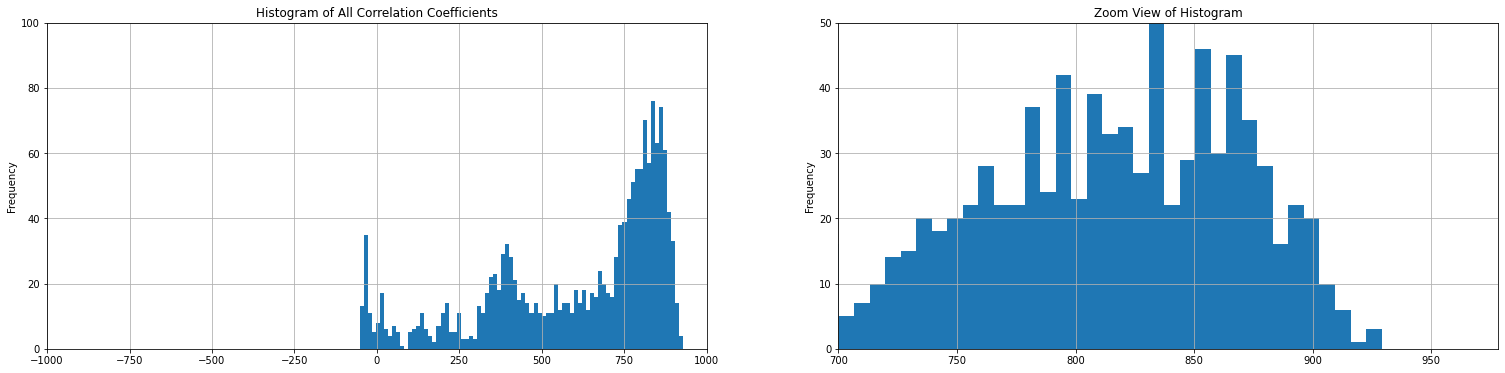

In [ ]:
# plot histogram to see distribution of correlation coefficients
# first, remove duplicates (upper right correlation coeffs = lower left, mirrored on diagonal) and diagonal; replace with NaN so won't be counted in histogram
cm = si_corr_matrix.copy(deep=True)
for rnum in range(si_corr_matrix.shape[0]):
    cm.iloc[rnum,0:rnum+1] = np.NaN
# now, stack the columns so we have a single column for easy feed into histogram plot method:
cm = cm.stack().reset_index(drop=True)

fig = plt.figure(figsize=(26,6)) 
axTotal = fig.add_subplot(1,2,1)
axTotal.set_title(f'Histogram of All Correlation Coefficients')
axZoom = fig.add_subplot(1,2,2)
axZoom.set_title(f'Zoom View of Histogram')

cm.plot(kind='hist', grid=True, bins=80, ax=axTotal)
cm.plot(kind='hist', grid=True, bins=150,  ax=axZoom)

axTotal.set_xlim(-1000,1000)
axTotal.set_ylim(0,100)
axZoom.set_xlim(700,)
axZoom.set_ylim(0,50)
done=True

<IPython.core.display.Javascript object>

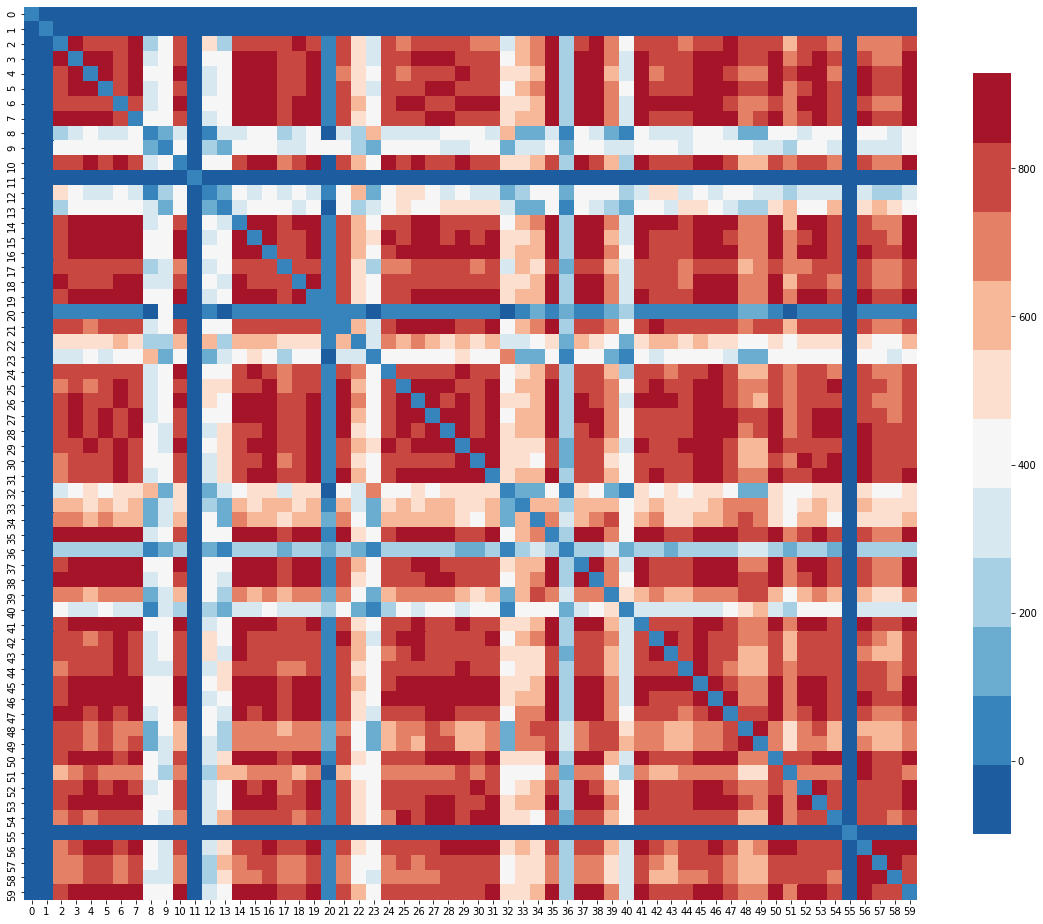

In [ ]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
si_corr_matrix_fill = si_corr_matrix.fillna(-99)
h = sns.heatmap(si_corr_matrix_fill,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

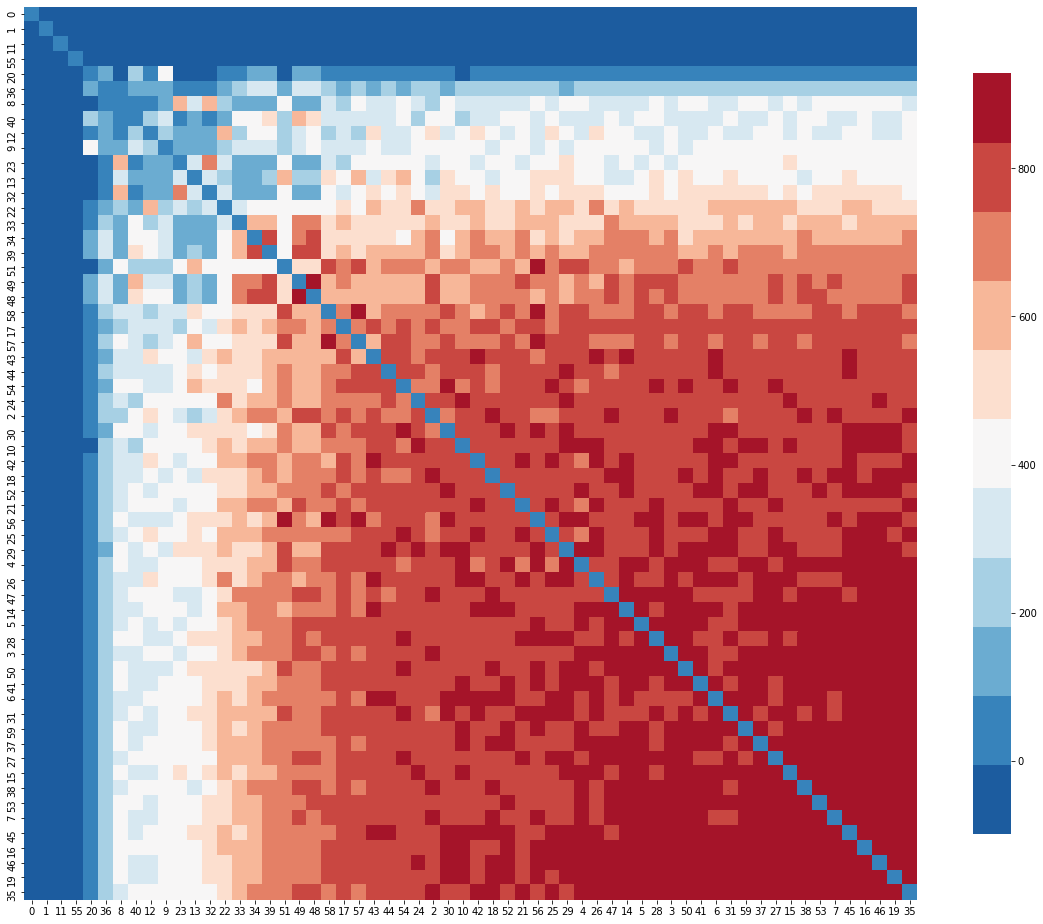

In [ ]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = si_corr_matrix_fill.copy(deep=True)#.reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [ ]:
# i think it might be best to somehow use 34 or 48 to generate missing values of 36

In [ ]:
corr_matrix_ids_masked = si_corr_matrix > correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
    
friendliest = corr_matrix_ids_masked.nunique() - 1  #(-1 to remove irrelevant "unique" cat code = 0)
if friendliest.values.sum() > 0:
    friendliest = friendliest.sort_values(ascending=False).reset_index(name='n_close_corr_cats')
    print(f'Top 10 categories having most number of correlated categories meeting the threshold criterion:\n{friendliest[:10]}\n')
else:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
#corr_matrix_ids_masked.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_ids_masked.iloc[57:62,59:84]

Top 10 categories having most number of correlated categories meeting the threshold criterion:
       n_close_corr_cats
0  53                 15
1  46                 13
2  35                 13
3  19                 12
4   7                 12
5  15                 10
6  38                 10
7  45                  9
8  41                  8
9  59                  8

done: Tue 21:26:31 06/16/20



59
      
57   0
58   0
59   0

In [ ]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
    cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
    cat_friends = cat_friends.explode('category2').reset_index(drop=True)
    cat_friends['weight'] = cat_friends.apply(lambda x: si_corr_matrix.at[x.category1,x.category2], axis=1)
    cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
    print(f'done: {strftime("%a %X %x")}\n')
    print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
    unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
    set_unique_nodes = set(unique_nodes)
    print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
    print(cat_friends.head(10))

    # edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
    # cat_friends = cat_friends[cat_friends.weight > edge_threshold]

    # import pandas df into weighted-edge graph:
    G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
    print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

done: Tue 21:26:31 06/16/20

Number of pairs meeting the threshold limit: 180
Number of unique category ids in the pairs meeting the threshold limit: 34

   category1 category2  weight
0          2        38     887
1          3        35     898
2          3        38     882
3          3        46     890
4          3        47     882
5          4         7     910
6          4        15     898
7          4        19     895
8          4        41     901
9          4        46     882

Weighted-edge graph G formation done: Tue 21:26:31 06/16/20



In [ ]:
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # employ a clustering method that utilizes the edge weights
    communities = community.asyn_lpa_communities(G, weight='weight', seed=44)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

done: Tue 21:26:31 06/16/20



In [ ]:
# extract information from the clustering algorithm's community grouping, and insert into df
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    num_communities = 0; community_items = set()
    comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
    for i,c in enumerate(communities):
        edgeweights = []; num_communities += 1
        community_items = community_items | set(c)
        nodelist = list(c); nnodes = len(nodelist)
        for m in range(nnodes-1):
            for n in range(m+1,nnodes):
                try:
                    edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
                except:
                    pass   
        comm_info['n_nodes'].append(nnodes)
        comm_info['cluster_members'].append(sorted(nodelist))
        comm_info['w_avg'].append(round(np.mean(edgeweights)))
        comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
        comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

    community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
    if category_names['print']:
        community_df['category_names'] = community_df.cluster_members.apply(lambda x: [category_names['df'].at[catid,category_names['column']] for catid in x])  # add column containing textual names of things in each cluster
    community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
    all_cluster_item_ids = community_df.cluster_members.sum()
    unique_cluster_item_ids = set(all_cluster_item_ids)

In [ ]:
# Display the results
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    print(community_df.describe())
    print("\n")

    print(f'done: {strftime("%a %X %x")}')
    print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
    print(f'Correlation Method: {corr_method}')
    print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
    #print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
    #print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
    print(f'Fill fillna(0) before computing correlations?: {fillna0}')
    print(f'Grouping time period: by {group_time_period}')
    print(f'Grouping category: by {group_category}')
    print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
    print(f'Number of community clusters identified in the graph: {num_communities}')
    print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
    print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
    print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
    print(community_df.head(10))

       n_nodes   w_avg      w_sum   w_max   w_min  w_std
count        4       4          4       4       4      4
mean     8.500 903.250 19,037.750 915.250     894  6.752
std     11.676  11.325 33,875.865  11.325  17.607  4.609
min          2     895        920     905     881      0
25%      2.750     898  2,252.750 906.500 885.500  6.010
50%          3     899  2,697.500 913.500 887.500  8.327
75%      8.750 904.250 19,482.500 922.250     896  9.069
max         26     920      69836     929     920 10.354


done: Tue 21:26:31 06/16/20

Correlation Threshold (1000x): 880
Correlation Method: pearson
Minimum number of periods for correlation calc: 4
Fill fillna(0) before computing correlations?: True
Grouping time period: by item_id
Grouping category: by shop_id
Aggregation column: sum of sales within a item_id for each shop_id
Number of community clusters identified in the graph: 4
Total number of ids in all suggested clusters): 34
Number of *unique* ids contained in all clusters: 34



##Correlation shop-shop by item_id sales for each month


In [ ]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 200
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 500         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 8
n_ids = len(shops_augmented)

group_time_period = 'month'
group_category = 'shop_id'
group_target = 'item_id'
agg_column = 'sales'                # sum of this when grouping by the above
category_names = {'print':True, 'df':shops_augmented, 'column':'en_shop_name'}   # when printing out the final clusters, if print=True, use this dataframe and column to return the names (assuming row# = category id)

print(f'done: {strftime("%a %X %x")}\n')

done: Tue 21:26:31 06/16/20



In [ ]:
# look at correlation between shops by # sales of each item (summed over full time period, scaled with min/max minus 999th ptile clip)
dfc = tt.groupby([group_category,group_target,group_time_period]).agg({agg_column:'sum'}).reset_index() #drop=True)
print(dfc.shape)
display(dfc.head())
#dfshop_item['target_time_tuple'] = dfshop_item.apply(lambda row: tuple((row.item_id,row.month)), axis=1) #str(row.item_id)+"_"+str(row.month), axis=1)
dfc['target_time_tuple'] = dfc.apply(lambda row: tuple((row[group_target],row[group_time_period])), axis=1)
print(dfc.shape)
display(dfc.head())
dfcp = dfc.pivot(index='target_time_tuple',columns=group_category,values=agg_column).reset_index().rename_axis("",axis=1).fillna(0)
print(dfcp.shape)
display(dfcp.head())
print('\n')
# create a version of the table, using scaled versions of all districts, for easier comparison and normalized correlation
qt = dfcp.quantile(0.999)
sc = MinMaxScaler((0,100))
dfcp_sc = dfcp.copy(deep=True)
for sh in tt.shop_id.unique():
    dfcp_sc[sh] = dfshop_item_sc[sh].clip(0,qt[sh])
    dfcp_sc[sh] = sc.fit_transform(dfcp_sc[sh].to_numpy().reshape(-1,1))
#dfcp_sc.index = dfcp_sc.item_id
dfcp_sc.drop('target_time_tuple',axis=1,inplace=True)
dfcp_sc.insert(0,0,0)
dfcp_sc.insert(1,1,0)
dfcp_sc.insert(11,11,0)
display(dfcp_sc.describe())
print('\n')
display(dfcp_sc.head())

(1823320, 4)


shop_id  item_id  month  sales
0        2       27      0      1
1        2       27     17      1
2        2       30      2      1
3        2       30      5      1
4        2       30     15      1

(1823320, 5)


shop_id  item_id  month  sales target_time_tuple
0        2       27      0      1       (27.0, 0.0)
1        2       27     17      1      (27.0, 17.0)
2        2       30      2      1       (30.0, 2.0)
3        2       30      5      1       (30.0, 5.0)
4        2       30     15      1      (30.0, 15.0)

(239011, 58)


target_time_tuple  2  3  4  5  6  7  8  9  10  12  13  14  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
0       (0.0, 20.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   1   0   0   0   0   0
1       (1.0, 15.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   2   0   0   0   0
2       (1.0, 18.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1   0   0   0   0
3       (1.0, 19.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1   0   0   0   0
4       (1.0, 20.0)  0  0  0  0  0  0  0  0   0   0   0   0  ...   0   0   0   0   0   0   0   0   1   0   0   0   0

[5 rows x 58 columns]

0      1      2      3      4      5      6      7      8      9      10     11    12  ...     47     48     49     50     51     52     53      54    55     56     57     58     59
count 239011 239011  22169  22169  22169  22169  22169  22169  22169  22169  22169 239011 22169  ...  22169  22169  22169  22169  22169  22169  22169   22169 22169  22169  22169  22169  22169
mean       0      0  8.043 11.405  8.719 12.164  6.659  9.624  8.602  2.857 13.483      0 2.303  ...  8.411 10.092 13.285  9.443 16.412  9.514  8.646   7.165 1.691 12.987  8.032  9.549  8.656
std        0      0 21.565 25.953 20.213 25.158 14.792 21.415 28.040 14.082 27.354      0 8.964  ... 19.736 25.693 31.111 20.380 28.685 20.399 20.524  15.107 9.678 23.224 16.788 21.006 20.138
min        0      0      0      0      0      0      0      0      0      0      0      0     0  ...      0      0      0      0      0      0      0       0     0      0      0      0      0
25%        0      0      0      0      0      0      0      0      0      0      0      0     0  ...      0      0      0      0      0      0      0       0     0      0      0      0      0
50%        0      0      0      0      0      0  1.783      0      0      0      0      0     0  ...      0      0      0      0      0      0      0   2.006     0      0  1.379      0      0
75%        0      0      0      0  6.685  9.951  7.133  9.297      0      0 21.756      0 1.215  ...  7.962      0      0  7.416 23.213  6.135  4.648   7.020     0 14.706  8.276  6.542  5.691
max        0      0    100    100    100    100    100    100    100    100    100      0   100  ...    100    100    100    100    100    100    100 100.000   100    100    100    100    100

[8 rows x 60 columns]

0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53    54    55  56  57  58  59
0   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 1.003     0   0   0   0   0
1   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0     0 6.439   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 2.006     0   0   0   0   0
3   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 2.006     0   0   0   0   0
4   0   0   0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0 1.003     0   0   0   0   0

[5 rows x 60 columns]

In [ ]:
# Make the correlation matrix, out of 239,011 rows of month,item pairs and 60 columns of shops
si_corr_matrix = dfcp_sc.corr(method=corr_method, min_periods=min_samples_corr)

si_corr_matrix = round(si_corr_matrix * 1000)
si_corr_matrix = si_corr_matrix.apply(pd.to_numeric,  downcast='integer')

for i in range(si_corr_matrix.shape[0]):  #set diag to zeros
    si_corr_matrix.at[i,i] = 0
    
print(f'done: {strftime("%a %X %x")}\n')
print(dfcp_sc.shape)
print(si_corr_matrix.shape)
display(si_corr_matrix.head())

done: Tue 21:27:23 06/16/20

(239011, 60)
(60, 60)


0   1   2   3   4   5   6   7   8   9   10  11  12  ...  47  48  49  50  51  52  53  54  55  56  57  58  59
                                                       ...                                                    
0   0 nan nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
1 nan   0 nan nan nan nan nan nan nan nan nan nan nan  ... nan nan nan nan nan nan nan nan nan nan nan nan nan
2 nan nan   0 717 754 696 693 762 182 342 640 nan 520  ... 797 602 589 726 545 710 730 609 -65 639 636 663 740
3 nan nan 717   0 769 784 715 790 235 270 721 nan 397  ... 782 629 627 785 645 737 794 680 -77 732 686 710 785
4 nan nan 754 769   0 784 786 855 279 296 726 nan 401  ... 819 612 595 827 688 814 859 712 -75 767 735 770 839

[5 rows x 60 columns]

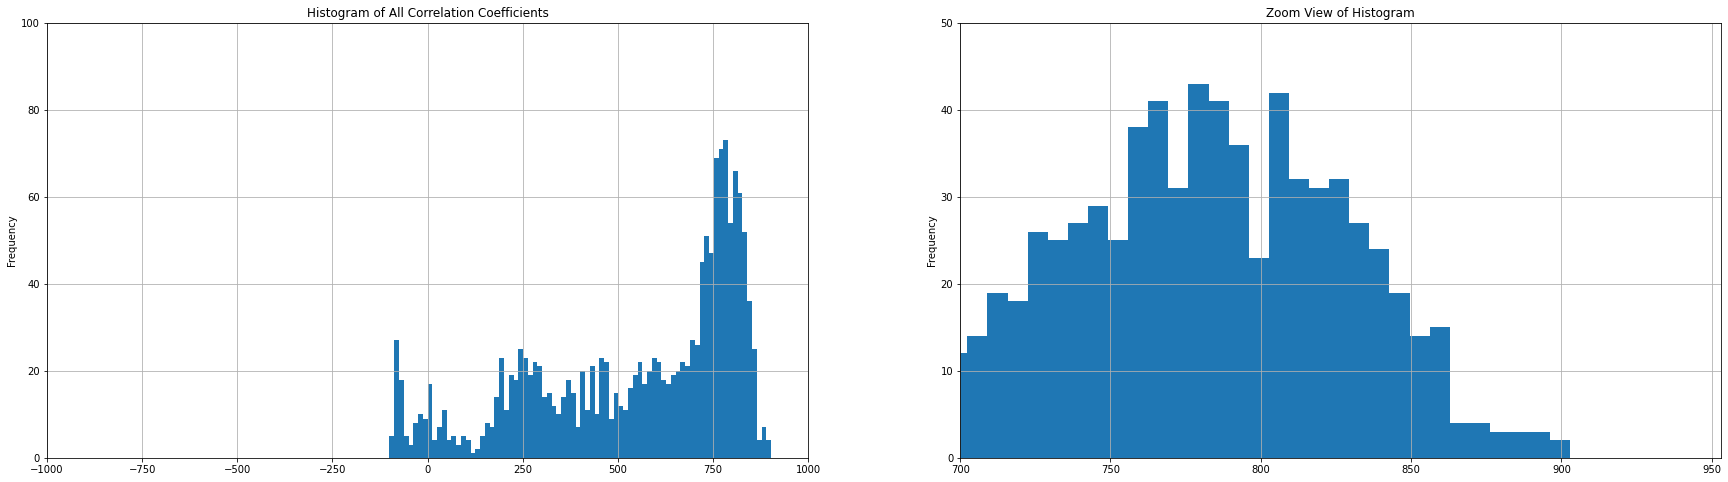

In [ ]:
# plot histogram to see distribution of correlation coefficients
# first, remove duplicates (upper right correlation coeffs = lower left, mirrored on diagonal) and diagonal; replace with NaN so won't be counted in histogram
cm = si_corr_matrix.copy(deep=True)
for rnum in range(si_corr_matrix.shape[0]):
    cm.iloc[rnum,0:rnum+1] = np.NaN
# now, stack the columns so we have a single column for easy feed into histogram plot method:
cm = cm.stack().reset_index(drop=True)

fig = plt.figure(figsize=(30,8)) 
axTotal = fig.add_subplot(1,2,1)
axTotal.set_title(f'Histogram of All Correlation Coefficients')
axZoom = fig.add_subplot(1,2,2)
axZoom.set_title(f'Zoom View of Histogram')

cm.plot(kind='hist', grid=True, bins=80, ax=axTotal)
cm.plot(kind='hist', grid=True, bins=150,  ax=axZoom)

axTotal.set_xlim(-1000,1000)
axTotal.set_ylim(0,100)
axZoom.set_xlim(700,)
axZoom.set_ylim(0,50)
done=True

<IPython.core.display.Javascript object>

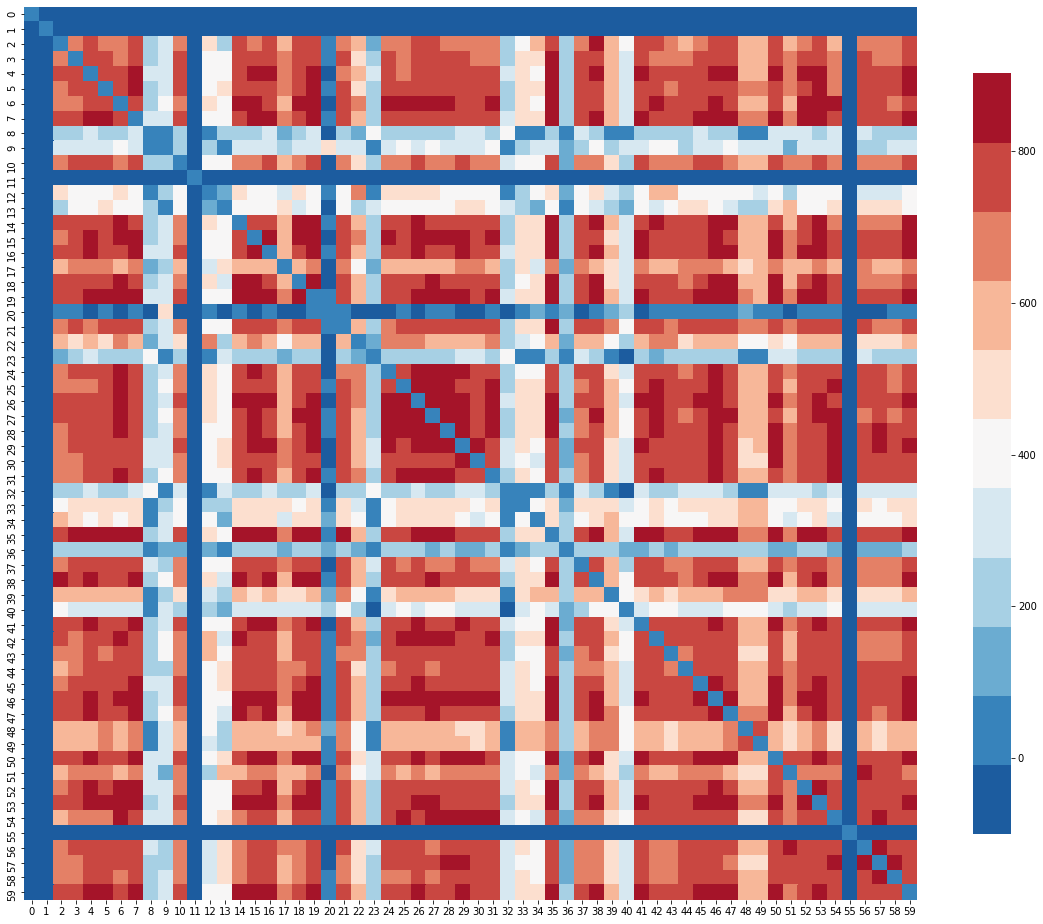

In [ ]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
si_corr_matrix_fill = si_corr_matrix.fillna(-99)
h = sns.heatmap(si_corr_matrix_fill,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

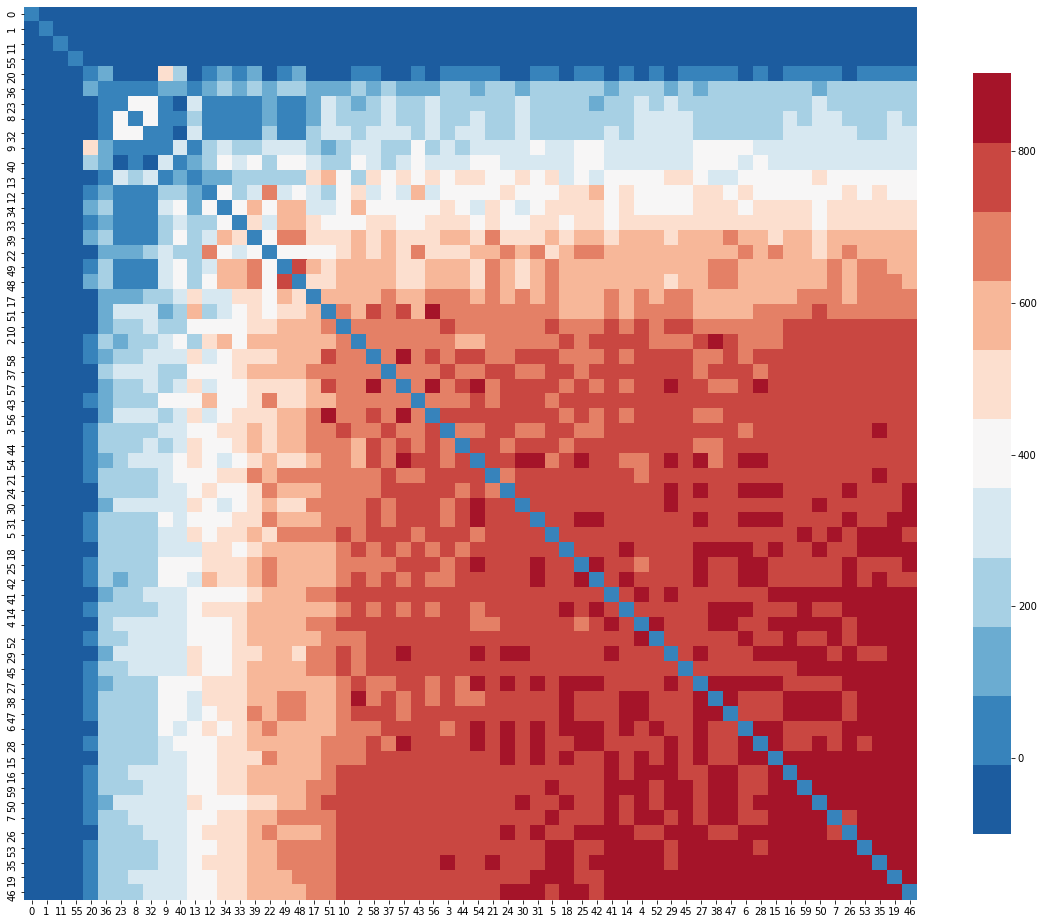

In [ ]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = si_corr_matrix_fill.copy(deep=True)#.reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [ ]:
corr_matrix_ids_masked = si_corr_matrix > 730 #correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
    
friendliest = corr_matrix_ids_masked.nunique() - 1  #(-1 to remove irrelevant "unique" cat code = 0)
if friendliest.values.sum() > 0:
    friendliest = friendliest.sort_values(ascending=False).reset_index(name='n_close_corr_cats')
    print(f'Top 10 categories having most number of correlated categories meeting the threshold criterion:\n{friendliest[:10]}\n')
else:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
#corr_matrix_ids_masked.head()

print(f'done: {strftime("%a %X %x")}\n')
#corr_matrix_ids_masked.iloc[57:62,59:84]

Top 10 categories having most number of correlated categories meeting the threshold criterion:
       n_close_corr_cats
0  59                 38
1  26                 38
2  46                 38
3  45                 37
4   7                 37
5  16                 37
6  19                 37
7  41                 37
8  15                 36
9  53                 36

done: Tue 21:27:26 06/16/20



In [ ]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
    cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
    cat_friends = cat_friends.explode('category2').reset_index(drop=True)
    cat_friends['weight'] = cat_friends.apply(lambda x: si_corr_matrix.at[x.category1,x.category2], axis=1)
    cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
    print(f'done: {strftime("%a %X %x")}\n')
    print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
    unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
    set_unique_nodes = set(unique_nodes)
    print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
    print(cat_friends.head(10))

    # edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
    # cat_friends = cat_friends[cat_friends.weight > edge_threshold]

    # import pandas df into weighted-edge graph:
    G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
    print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

done: Tue 21:27:26 06/16/20

Number of pairs meeting the threshold limit: 1220
Number of unique category ids in the pairs meeting the threshold limit: 42

   category1 category2  weight
0          2         4     754
1          2         7     762
2          2        14     750
3          2        16     756
4          2        18     791
5          2        26     748
6          2        27     734
7          2        35     756
8          2        38     817
9          2        41     752

Weighted-edge graph G formation done: Tue 21:27:26 06/16/20



In [ ]:
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # employ a clustering method that utilizes the edge weights
    communities = community.asyn_lpa_communities(G, weight='weight', seed=44)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

done: Tue 21:27:26 06/16/20



In [ ]:
# extract information from the clustering algorithm's community grouping, and insert into df
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    num_communities = 0; community_items = set()
    comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
    for i,c in enumerate(communities):
        edgeweights = []; num_communities += 1
        community_items = community_items | set(c)
        nodelist = list(c); nnodes = len(nodelist)
        for m in range(nnodes-1):
            for n in range(m+1,nnodes):
                try:
                    edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
                except:
                    pass   
        comm_info['n_nodes'].append(nnodes)
        comm_info['cluster_members'].append(sorted(nodelist))
        comm_info['w_avg'].append(round(np.mean(edgeweights)))
        comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
        comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

    community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
    if category_names['print']:
        community_df['category_names'] = community_df.cluster_members.apply(lambda x: [category_names['df'].at[catid,category_names['column']] for catid in x])  # add column containing textual names of things in each cluster
    community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
    all_cluster_item_ids = community_df.cluster_members.sum()
    unique_cluster_item_ids = set(all_cluster_item_ids)

In [ ]:
# Display the results
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    print(community_df.describe())
    print("\n")

    print(f'done: {strftime("%a %X %x")}')
    print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
    print(f'Correlation Method: {corr_method}')
    print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
    #print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
    #print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
    print(f'Fill fillna(0) before computing correlations?: {fillna0}')
    print(f'Grouping time period: by {group_time_period}')
    print(f'Grouping category: by {group_category}')
    print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
    print(f'Number of community clusters identified in the graph: {num_communities}')
    print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
    print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
    print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
    print(community_df.head(10))

       n_nodes   w_avg       w_sum   w_max   w_min  w_std
count        2       2           2       2       2      2
mean        21 771.500      242285     826     740 18.636
std     26.870  31.820 341,583.487 108.894  12.728 26.356
min          2     749         749     749     731      0
25%     11.500 760.250      121517 787.500 735.500  9.318
50%         21 771.500      242285     826     740 18.636
75%     30.500 782.750      363053 864.500 744.500 27.954
max         40     794      483821     903     749 37.273


done: Tue 21:27:27 06/16/20

Correlation Threshold (1000x): 500
Correlation Method: pearson
Minimum number of periods for correlation calc: 8
Fill fillna(0) before computing correlations?: True
Grouping time period: by month
Grouping category: by shop_id
Aggregation column: sum of sales within a month for each shop_id
Number of community clusters identified in the graph: 2
Total number of ids in all suggested clusters): 42
Number of *unique* ids contained in all clusters:

##Explore correlations related to sales amounts, for 
* individual categories (e.g. item_category_id #n vs. item_category_id #n+1)
* category pairs (e.g., sales in item_category_id #n vs. shop_id #m)
* lagged values (e.g., item_category_id #n vs. item_category_id #n lagged by x amount)
* * lagged values can be shifted by days, weeks, months, quarters

In [ ]:
# To Do:
'''
#####################
# START: correlations without NLP:  look at item_cnt_day numbers, and find which things to group to make decision tree algorithms more effective and predictive
#####################

How to best check sales correlations between elements/groups?
- clip daily sales at [0,20] before grouping
- use self-correlation with time lag to see what are the best lag features to use (maybe grouped by month first, with lags =1 to 15 and 
      grouped by shop_id(fastest) or item_cat_id or item or shop_item or shop-item_cat / pivot so shop or item number = column number)
- look at correlation between shops and between items and between shop-item and item_category_ids for different lags and for different items; see if we can reduce number of category_ids, or if we should increase

#####################
# END: correlations without NLP
#####################



#####################
# START: thoughts on adjustments to make to the NLP section of this ipynb, if we should wish to continue on this route...
#####################

re.findall isn't consistent... sometimes gives a list of an array of tuples (many of which are empty string, but a matching string will be in any one of the tuple positions... and, possibly more than one??), so x=[("",""," dvd","")] and x[0] gives the tuple, and x[0][0]=''
sometimes gives a list of a single string, so x[0] = 'abbyy' and x[0][0]='a'
--> maybe add an extra df column for ngrams to append, and merge it with the delim_item_strings after all 'cleaning' is done

explicitly concatenate the item category name as a n-gram string, with n the same for all categories (pad as needed); don't add it to string before separating

focus on any of the 84 categories that have the most items or the most spread in behavior... split apart the ones with odd behavior, or the ones that are sold by  a subset of shops consistently
(original train set: item_cat_id.counts()
(original train set: item_cat_id - item_cnt_day.value_counts()
(group by item_cat_id (agg: counts); then do shop_id.counts()
(group by month and item_cat_id; look at sum of sales by item_cat_id for last xx months, and characterize the various groups with min/max/std over past n months, for several n)
--> look after stripping the version numbers, etc. off the games and software, and create new groups based on only that??
--> can also try combining similar of the 84 categories (e.g., all playstations, or all xboxes, or all tickets/cards/...) and see if we have more consistent performance within a category
--> can also look at top 50 clusters created by NLP, and see how correlated their sales are, within a cluster, vs. uncorrelated outside a cluster

###
maybe create a combination category column like grouping certain shop-item pairs, or shop-item_category pairs, or shop_cat-item_cat pairing

####
look at most common n-grams for the cleaned/non-delimited item name
(start with n=15 and work backwards to n=1)
clean/replace as much as possible without overly distorting the item name
then:
for each n:
--> split clean string into consecutive n-grams and put them in df columns, where the # columns in df = largest number of n-grams for any of the item names (search to find longest name, and calculate how many columns are needed/used)
--> in each column, do count_values... perhaps do a combined unique() to get all the n-grams, then put into an array or series containing the n-gram string and the sum of value_counts over each column
--> sort by frequency, and choose the ? top 100 and ? bottom 100 (for sum>1)
--> convert some of the desired n-grams into n+x grams to reflect the relative importance?

#####################
# END: adjustments to make to the NLP section of this ipynb...
#####################
'''

print(f'done: {strftime("%a %X %x")}')

done: Tue 21:27:27 06/16/20


#2.x.1.x) Explore Correlation Type:
* **item_category_id** - **item_category_id** correlation 
* sales grouped by **week** (and **item_category_id**)
</br>

* Pearson correlation between sales of item categories for each week; threshold at a certain value (e.g., above 0.92) to indicate sufficient correlation to include.  Then, use neworkX and graph clustering to extract groups of tightly-clustered item_category_ids


In [ ]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 20
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 700         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 4
n_ids = len(item_categories_augmented)

group_time_period = 'day'
group_category = 'item_category_id'
agg_column = 'sales'                # sum of this when grouping by the above
category_names = {'print':True, 'df':item_categories_augmented, 'column':'en_cat_name'}   # when printing out the final clusters, if print=True, use this dataframe and column to return the names (assuming row# = category id)

print(f'done: {strftime("%a %X %x")}\n')

done: Tue 21:27:27 06/16/20



###create category vs. sales (by time_period) dataframe, on which to do correlation examination

In [ ]:
df_keep = [group_time_period,agg_column,group_category]
df_groupby = [group_time_period,group_category]
pivot_idx = group_time_period
pivot_cols = group_category
pivot_values = agg_column

# clipping daily shop-item pair sales as desired, then drop test month if desired, then group by time=group_time_period and by cat=group_category (dropping unnecessary columns)
# finally, pivot the dataframe so columns correspond to different categories, and rows correspond to different time periods
time_cat = tt.copy(deep=True)
time_cat.sales.clip(daily_sales_min_clip, daily_sales_max_clip, inplace=True)
if drop_test_month:
    time_cat = time_cat[time_cat.month < 34]
time_cat = time_cat[df_keep].groupby(df_groupby).sum().reset_index()
time_cat = time_cat.pivot(index = pivot_idx, columns = pivot_cols, values = pivot_values).reset_index(drop=True)

print(f'done: {strftime("%a %X %x")}\n')
print(f'Pivoted dataframe shape for sales per {group_category}, summed within each {group_time_period}: {time_cat.shape}\n')
print(time_cat.describe(),'\n')
time_cat.head()

done: Tue 21:27:28 06/16/20

Pivoted dataframe shape for sales per item_category_id, summed within each day: (1034, 84)

item_category_id  0   1      2      3     4     5      6      7      8      9   10    11     12  ...      71     72     73    74     75    76    77    78     79     80    81     82     83
count              3   2   1027   1031   610   977   1034    400    238    723   1   887    684  ...     947   1034   1032    56   1034   895   587   705    962    152   311    492    990
mean               1   1 19.178 29.033 3.967 7.615 19.887 13.475 36.248 16.282   1 7.268 17.975  ... 174.836 49.959 14.173 1.054 46.616 6.293 6.664 3.560 16.454 26.546 3.106 21.120 12.158
std                0   0 20.231 29.003 3.443 6.515 13.615 18.974 70.141 16.924 nan 7.957 36.583  ...  87.954 44.012  7.161 0.227 23.344 3.917 6.592 3.633 19.383 50.264 2.230 17.705 10.563
min                1   1      1      1     0     1      1      1      0      1   1     0      0  ...       1      4      1     

item_category_id  0   1   2   3   4   5   6   7   8   9   10  11  12  ...  71  72  73  74  75  76  77  78  79  80  81  82  83
0                nan nan  30   7  10  12  13 nan nan nan nan   5 nan  ...  23  12   3 nan  17 nan   4 nan   1 nan   1  16  35
1                nan nan 119  41  19  58  65 nan nan nan nan  26 nan  ...  40  31  13 nan  96 nan  31 nan   7 nan   9  71 113
2                nan nan  85  32  17  57  47 nan nan nan nan  26 nan  ...  11  47  26 nan 126 nan  30 nan   1 nan   7  41  64
3                nan nan  77  24  19  33  44 nan nan nan nan  30 nan  ...   4  17  14 nan 167 nan  16 nan   7 nan   8  62  32
4                nan nan  79  25  15  46  40 nan nan nan nan  21 nan  ...   2  37  15 nan 110 nan  18 nan   7 nan   7  57  38

[5 rows x 84 columns]

Plotted at: Tue 21:32:17 06/16/20



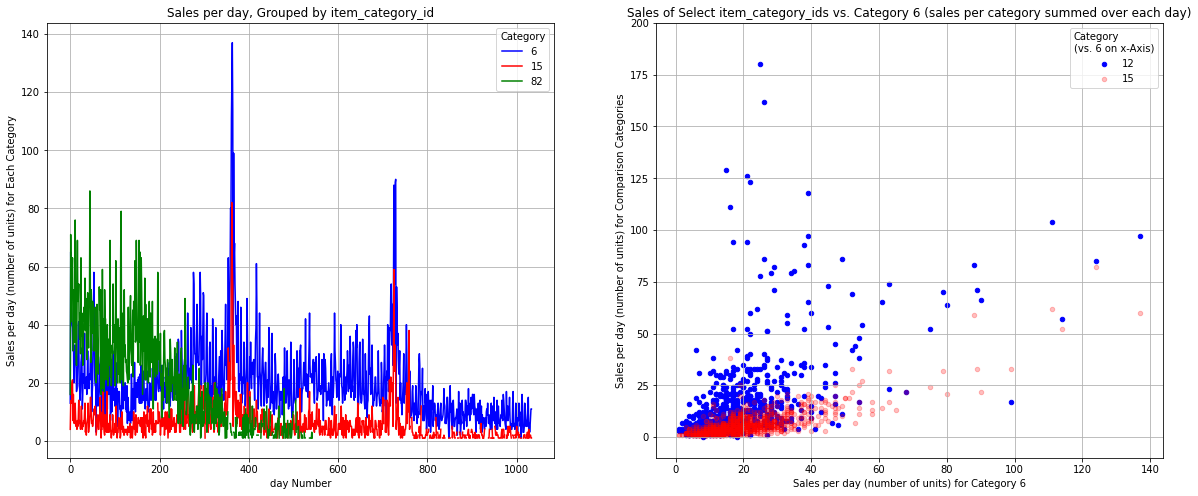

In [ ]:
#sns.pairplot(cat_cat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)
# pltcolors = ['blue','red','green','black','darkorange','darkorchid','teal', 'gold','olive','firebrick','gray','sienna','fuchsia','dodgerblue','cyan','lime','deeppink','violet','turquoise','tan']

# sanity check, just do a simple line plot and a simple scatter plot between a couple of items (they can be different pairs for each plot)

'''
Line Plot Inputs & Parameters
'''
categories_for_line_plot = [6,15,82]  # x-axis is index (time period)
line_colors = pltcolors[:len(categories_for_line_plot)]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = False

'''
Scatter Plot Inputs & Parameters
'''
x_scatter_plot_category = [6]
y_scatter_plot_categories = [12,15] #,70]
scatter_colors = ['blue','red']
scatter_alphas = [1.0, 0.25] #, 0.25]          # set transparency to see dots behind other dots
scatter_plot_x = False #(20,40) #False  # False uses auto-scale
scatter_plot_y = (-10,200)


print(f'Plotted at: {strftime("%a %X %x")}\n')

'''
Generate the Plots
'''
fig = plt.figure(figsize=(20,8)) 
axLine = fig.add_subplot(1,2,1)
axLine.set_title(f'Sales per {group_time_period}, Grouped by {group_category}')
axScatter = fig.add_subplot(1,2,2)
axScatter.set_title(f'Sales of Select {group_category}s vs. Category {x_scatter_plot_category[0]} (sales per category summed over each {group_time_period})')

time_cat.plot(y=categories_for_line_plot, kind='line',color=line_colors,grid=True, ax=axLine)

for sidx, s in enumerate(y_scatter_plot_categories):
    time_cat.plot.scatter(x=x_scatter_plot_category,y=s,color=scatter_colors[sidx], grid=True, ax=axScatter, label=str(s), alpha=scatter_alphas[sidx])

axLine.legend(title='Category')
axLine.set_ylabel(f'Sales per {group_time_period} (number of units) for Each Category')
axLine.set_xlabel(f'{group_time_period} Number')
axScatter.legend(title=f'Category\n(vs. {x_scatter_plot_category[0]} on x-Axis)')
axScatter.set_ylabel(f'Sales per {group_time_period} (number of units) for Comparison Categories')
axScatter.set_xlabel(f'Sales per {group_time_period} (number of units) for Category {x_scatter_plot_category[0]}')
if line_plot_x:
    axLine.set_xlim(line_plot_x)
if line_plot_y:
    axLine.set_ylim(line_plot_y)
if scatter_plot_x:
    axScatter.set_xlim(scatter_plot_x)
if scatter_plot_y:
    axScatter.set_ylim(scatter_plot_y)

codeDone = True   # suppresses the printing of matplotlib object above

###category vs. category  correlation matrix

In [ ]:
if fillna0:
    corr_matrix = time_cat.fillna(0).corr(method=corr_method, min_periods=min_samples_corr)
else:
    corr_matrix = time_cat.corr(method=corr_method, min_periods=min_samples_corr)

corr_matrix = round(corr_matrix * 1000)
corr_matrix = corr_matrix.apply(pd.to_numeric,  downcast='integer')
for i in range(corr_matrix.shape[0]):  #set diag to zeros
    corr_matrix.at[i,i] = 0
    
print(f'done: {strftime("%a %X %x")}\n')
corr_matrix.head()

done: Tue 21:32:34 06/16/20



item_category_id   0    1    2    3    4    5    6    7    8    9   10   11   12  ...   71   72   73   74   75   76   77   78   79   80   81   82   83
item_category_id                                                                  ...                                                                 
0                   0  407   16  -38   11   31  -21  -21  -12  -19  -2   12  -21  ...  -89  -46   92  -13   96  -70   86  -38  -37  -10   69   58   19
1                 407    0   31  -27   22   26   13  -17  -10  -11  -1   21  -17  ...  -72  -34   45  -10  106  -57   79  -31  -21   -8   72   84   18
2                  16   31    0  295  541  759  789  -95 -112 -241  -6  883  173  ...  319  246  201 -106  704 -182  414  -34 -208 -139  287  325  271
3                 -38  -27  295    0 -160  223  481  436   96  102 -26  300  768  ...  507  606 -208   82   73  351 -246  145  375   35 -293 -351   62
4                  11   22  541 -160    0  613  327 -224 -130 -273  16  439  -88  ...  -81 -170  342 -138  652 -408  696 -197 -342 -130  593  693  415

[5 rows x 84 columns]

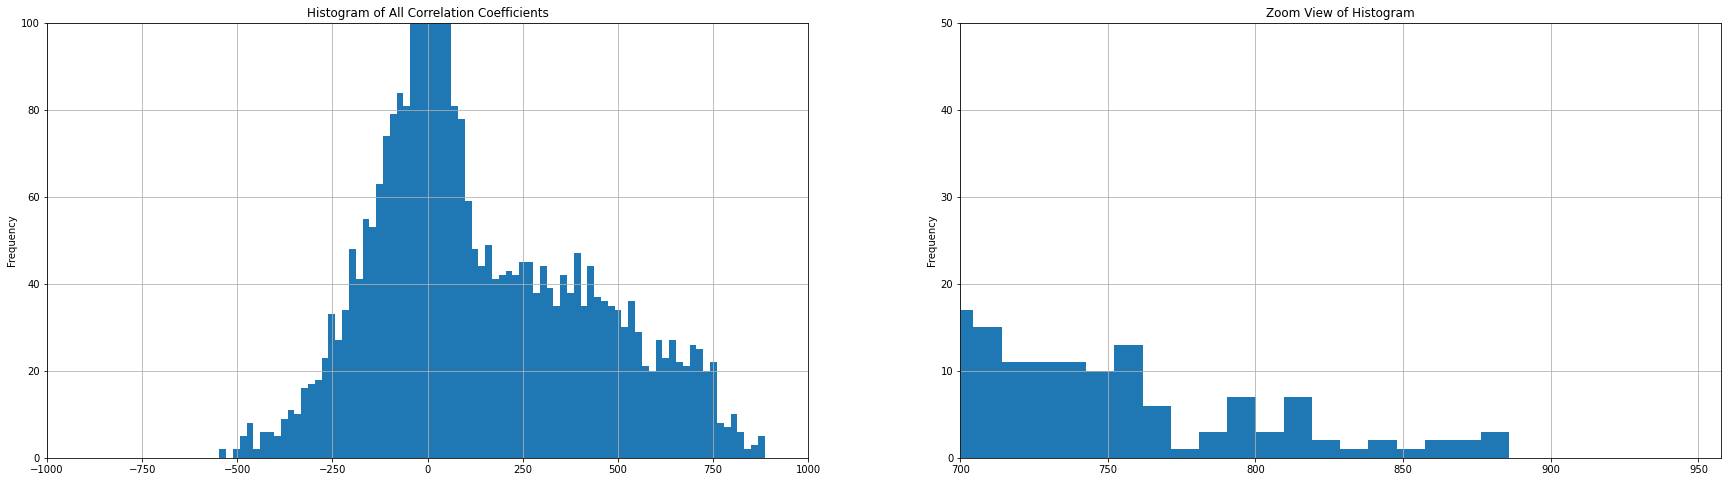

In [ ]:
# plot histogram to see distribution of correlation coefficients; can help with setting threshold
# first, remove duplicates (upper right correlation coeffs = lower left, mirrored on diagonal) and diagonal; replace with NaN so won't be counted in histogram
cm = corr_matrix.copy(deep=True)
for rnum in range(n_ids):
    cm.iloc[rnum,0:rnum+1] = np.NaN
# now, stack the columns so we have a single column for easy feed into histogram plot method:
cm = cm.stack().reset_index(drop=True)

fig = plt.figure(figsize=(30,8)) 
axTotal = fig.add_subplot(1,2,1)
axTotal.set_title(f'Histogram of All Correlation Coefficients')
axZoom = fig.add_subplot(1,2,2)
axZoom.set_title(f'Zoom View of Histogram')

cm.plot(kind='hist', grid=True, bins=80, ax=axTotal)
cm.plot(kind='hist', grid=True, bins=150,  ax=axZoom)

axTotal.set_xlim(-1000,1000)
axTotal.set_ylim(0,100)
axZoom.set_xlim(700,)
axZoom.set_ylim(0,50)
done=True

In [ ]:
corr_matrix_ids_masked = corr_matrix > correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
    
friendliest = corr_matrix_ids_masked.nunique() - 1  #(-1 to remove irrelevant "unique" cat code = 0)
if friendliest.values.sum() > 0:
    friendliest = friendliest.sort_values(ascending=False).reset_index(name='n_close_corr_cats')
    print(f'Top 10 categories having most number of correlated categories meeting the threshold criterion:\n{friendliest[:10]}\n')
else:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
#corr_matrix_ids_masked.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_ids_masked.iloc[57:62,59:84]

Top 10 categories having most number of correlated categories meeting the threshold criterion:
   item_category_id  n_close_corr_cats
0                21                 14
1                40                 14
2                62                 14
3                 2                 13
4                30                 12
5                55                 12
6                 6                 10
7                41                 10
8                75                  8
9                67                  8

done: Tue 21:32:36 06/16/20



item_category_id  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
item_category_id                                                                                                    
57                 0   0   0  58   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
58                 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
59                 0   0   0   0   0   0   0  60   0   0   0   0   0   0   0   0   0   0  60   0   0   0   0  60   0
60                 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
61                 0   0   0   0   0   0   0   0   0   0   0  62   0   0   0   0   0   0   0   0   0   0   0   0   0

###correlation matrix heatmaps

<IPython.core.display.Javascript object>

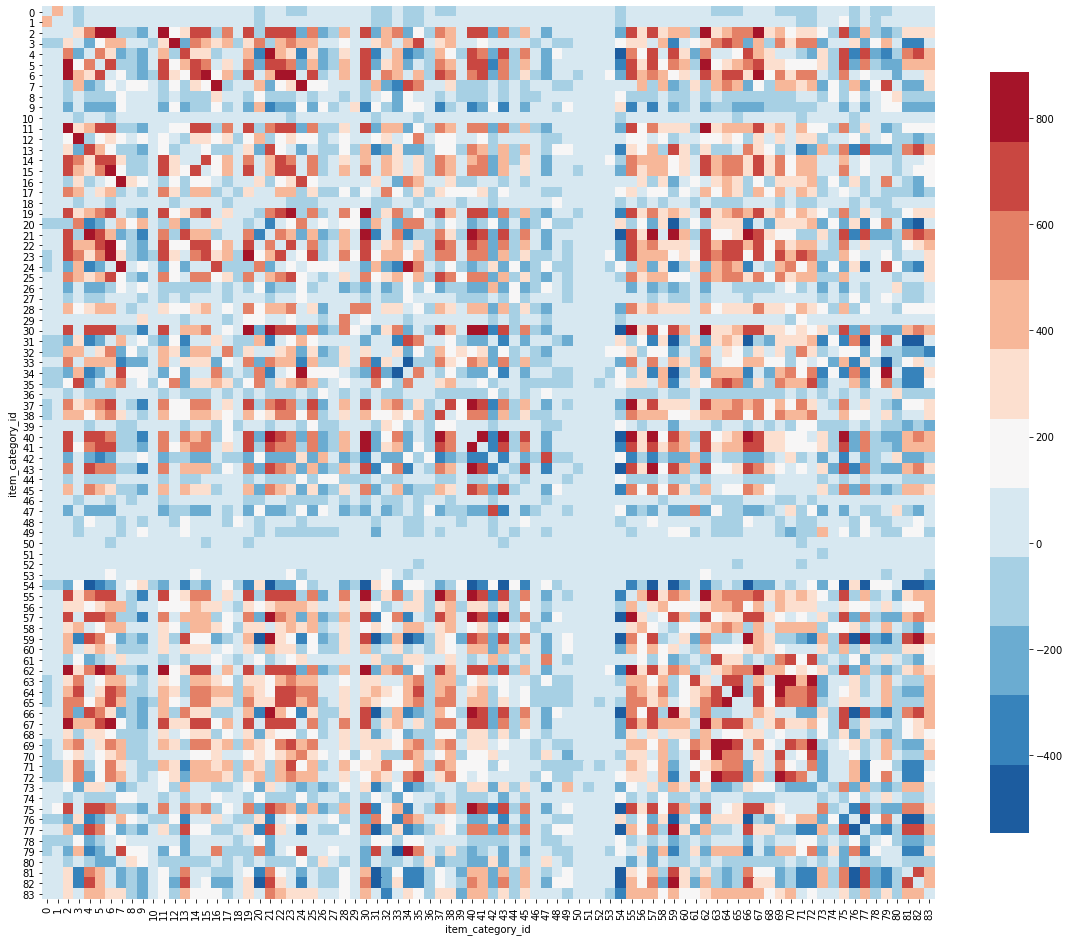

In [ ]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

h = sns.heatmap(corr_matrix,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

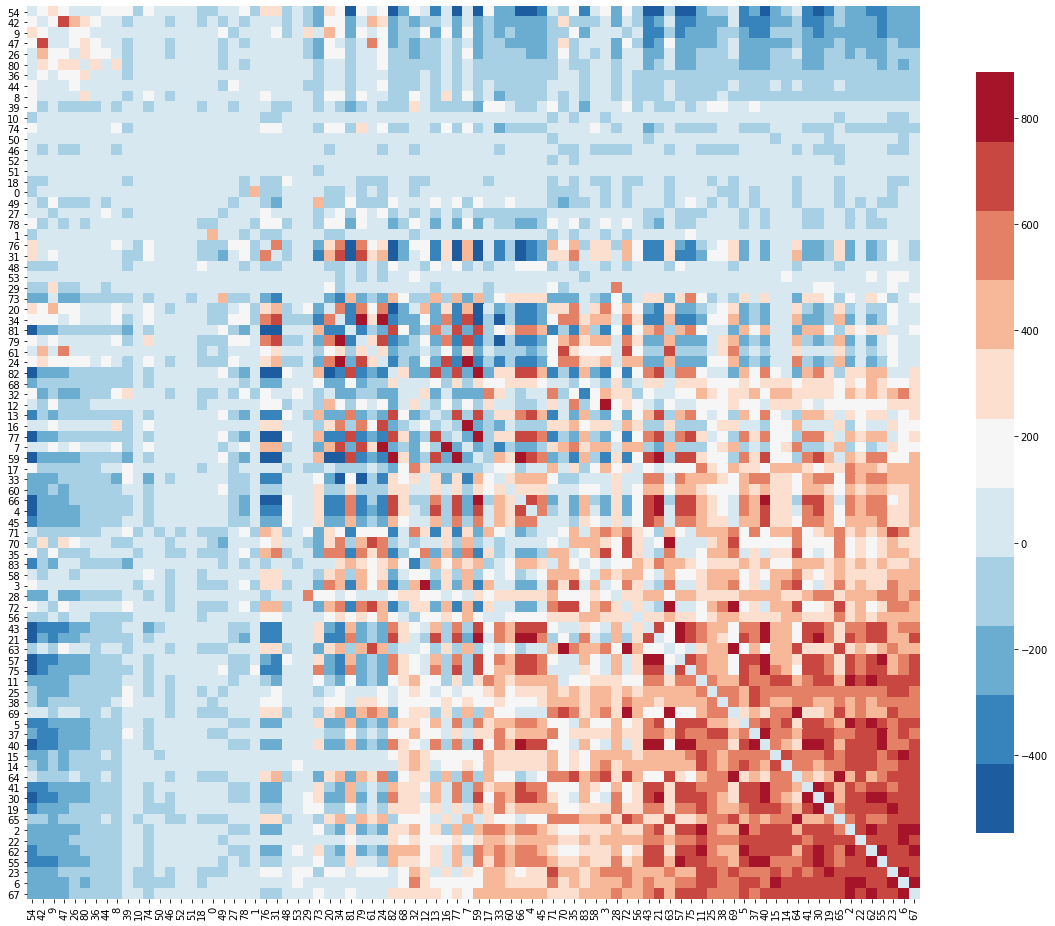

In [ ]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = corr_matrix.copy(deep=True).reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

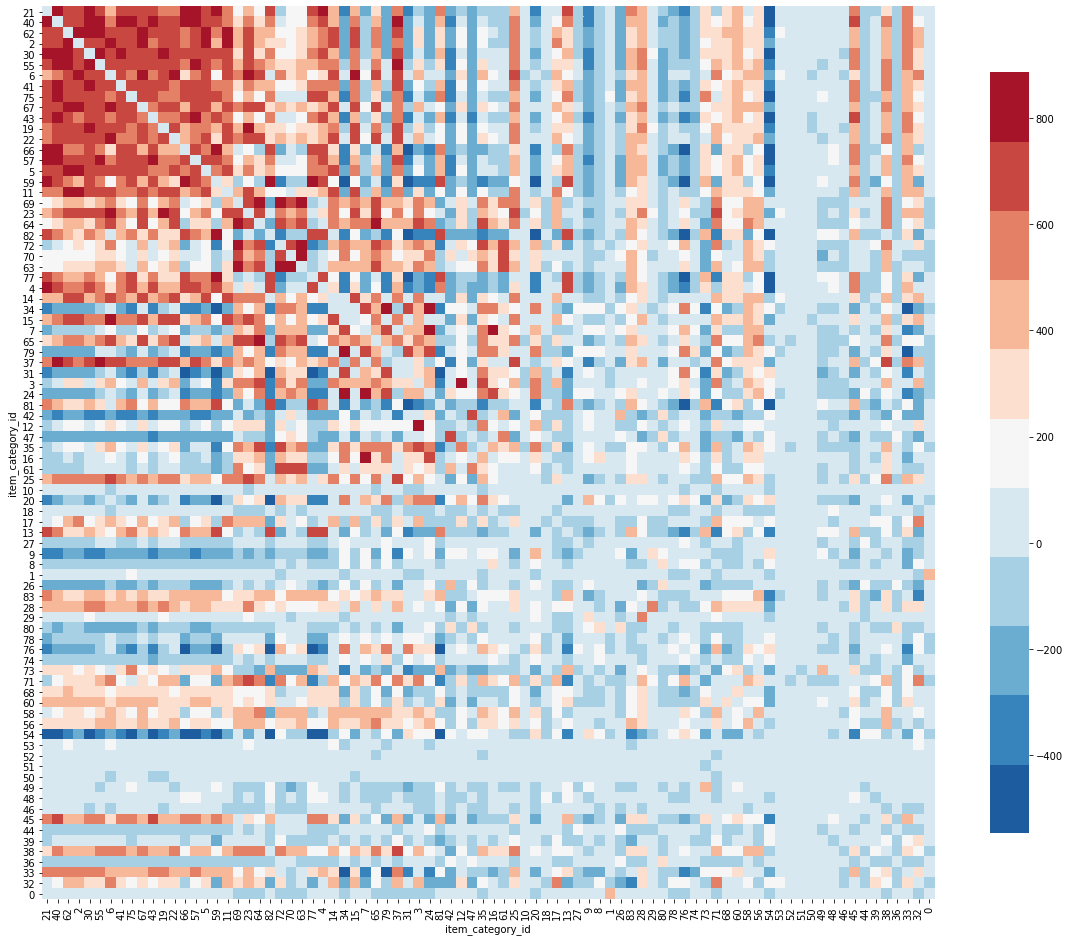

In [ ]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#   sort by: count of number of items correlated above the threshold
df = corr_matrix.copy(deep=True).reset_index(drop=True)
sortedidx = corr_matrix_ids_masked.nunique().sort_values(ascending=False).index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

###create networkX graph and perform clustering

In [ ]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
    cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
    cat_friends = cat_friends.explode('category2').reset_index(drop=True)
    cat_friends['weight'] = cat_friends.apply(lambda x: corr_matrix.at[x.category1,x.category2], axis=1)
    cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
    print(f'done: {strftime("%a %X %x")}\n')
    print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
    unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
    set_unique_nodes = set(unique_nodes)
    print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
    print(cat_friends.head(10))

    # edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
    # cat_friends = cat_friends[cat_friends.weight > edge_threshold]

    # import pandas df into weighted-edge graph:
    G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
    print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

done: Tue 21:32:42 06/16/20

Number of pairs meeting the threshold limit: 242
Number of unique category ids in the pairs meeting the threshold limit: 44

   category1 category2  weight
0          2         5     759
1          2         6     789
2          2        11     883
3          2        14     704
4          2        15     748
5          2        19     725
6          2        22     726
7          2        30     739
8          2        40     719
9          2        41     719

Weighted-edge graph G formation done: Tue 21:32:42 06/16/20



In [ ]:
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # employ a clustering method that utilizes the edge weights
    communities = community.asyn_lpa_communities(G, weight='weight', seed=42)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

done: Tue 21:32:42 06/16/20



In [ ]:
# extract information from the clustering algorithm's community grouping, and insert into df
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    num_communities = 0; community_items = set()
    comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
    for i,c in enumerate(communities):
        edgeweights = []; num_communities += 1
        community_items = community_items | set(c)
        nodelist = list(c); nnodes = len(nodelist)
        for m in range(nnodes-1):
            for n in range(m+1,nnodes):
                try:
                    edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
                except:
                    pass   
        comm_info['n_nodes'].append(nnodes)
        comm_info['cluster_members'].append(sorted(nodelist))
        comm_info['w_avg'].append(round(np.mean(edgeweights)))
        comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
        comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

    community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
    if category_names['print']:
        community_df['category_names'] = community_df.cluster_members.apply(lambda x: [category_names['df'].at[catid,category_names['column']] for catid in x])  # add column containing textual names of things in each cluster
    community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
    all_cluster_item_ids = community_df.cluster_members.sum()
    unique_cluster_item_ids = set(all_cluster_item_ids)

###results of graph clustering algorithm

In [ ]:
# Display the results
if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    print(community_df.describe())
    print("\n")

    print(f'done: {strftime("%a %X %x")}')
    print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
    print(f'Correlation Method: {corr_method}')
    print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
    print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
    print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
    print(f'Fill fillna(0) before computing correlations?: {fillna0}')
    print(f'Grouping time period: by {group_time_period}')
    print(f'Grouping category: by {group_category}')
    print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
    print(f'Number of community clusters identified in the graph: {num_communities}')
    print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
    print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
    print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
    print(community_df.head(10))

       n_nodes   w_avg      w_sum   w_max   w_min  w_std
count        6       6          6       6       6      6
mean     7.333 765.167 14,763.833 827.167 729.667 34.411
std      9.309  42.216 28,793.384  72.579  46.898 29.151
min          2     708        708     708     701      0
25%          3 752.750  1,546.500 789.750 703.500 16.500
50%          3     760  1,998.500     859     709 31.232
75%          6     771  7,462.750     878 728.750 46.667
max         26     838      73198     886     822 80.603


done: Tue 21:32:42 06/16/20

Correlation Threshold (1000x): 700
Correlation Method: pearson
Minimum number of periods for correlation calc: 4
Daily sales clip limits before grouping: 0, 20
Drop test month (= 34) before grouping?: True
Fill fillna(0) before computing correlations?: True
Grouping time period: by day
Grouping category: by item_category_id
Aggregation column: sum of sales within a day for each item_category_id
Number of community clusters identified in the graph: 6
To

In [ ]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

k=10
# what are the top-10 most correlated categories?
# remove everything under diagonal so we don't get duplicate results

if friendliest.values.sum() == 0:
    print('\n***********************************************')
    print('**  NO CATEGORIES MEET THE THRESHOLD LIMIT  ***')
    print('***********************************************\n')
else:
    # remove elements below the diagonal
    corr_diag = corr_matrix
    for rnum in range(n_ids):
        corr_diag.iloc[rnum,0:rnum] = 0
    corr_npy = corr_diag.to_numpy()
    cms_top_idxs = largest_indices(corr_npy, k)
    cms_top_vals = corr_npy[cms_top_idxs]
    top_k = pd.DataFrame({'cat1':cms_top_idxs[0], 'cat2':cms_top_idxs[1], 'corr':cms_top_vals})
    if category_names['print']:
        top_k['category_names'] = top_k.apply(lambda x: [category_names['df'].at[x.cat1,category_names['column']], category_names['df'].at[x.cat2,category_names['column']]], axis = 1) 

    print(f'done: {strftime("%a %X %x")}\n')

    print(f'Top {k} most-strongly-correlated pairs:')
    print(top_k)

done: Tue 21:32:42 06/16/20

Top 10 most-strongly-correlated pairs:
   cat1  cat2  corr                                          category_names
0    34    79   886         [Payment cards - Live! (Numeral), System Tools]
1     2    11   883                [Accessories - PS3, Game consoles - PS3]
2     2    62   878    [Accessories - PS3, Gifts - gadgets, robots, sports]
3    30    40   872              [Games PC - Standard Edition, Movie - DVD]
4    40    55   870           [Movie - DVD, Music - CD of local production]
5    64    65   863          [Gifts - Board Games, Gifts - Games (compact)]
6    62    67   860  [Gifts - gadgets, robots, sports, Gifts - Development]
7     7    16   855      [Accessories - XBOX ONE, Game consoles - XBOX ONE]
8    21    40   846                              [Games - PSP, Movie - DVD]
9    19    23   840                         [Games - PS3, Games - XBOX 360]


In [ ]:
lr=mgcd # dummy code to stop execution of "run after" menu option, so we don't go into all the stuff below

NameError: ignored

##2.x.1.1) Correlation Type:
###1. **item_category_id** - **item_category_id** correlation 
###2. sales grouped by **month** (and **item_category_id**)
</br>

* Pearson correlation between sales of item categories for each month; threshold at a certain value (e.g., above 0.92) to indicate sufficient correlation to include.  Then, use neworkX and graph clustering to extract groups of tightly-clustered item_category_ids


In [ ]:
# start by clipping daily shop-item pair sales at 0-20, then with grouping by month and by item_category_id;

month_itemcat = tt.copy(deep=True)
month_itemcat.sales.clip(0,20, inplace=True)
month_itemcat = month_itemcat[['month','sales','item_category_id']].groupby(['month','item_category_id']).sum().reset_index()
month_itemcat = month_itemcat.pivot(index = 'month', columns='item_category_id', values='sales').drop(34)

print(f'done: {strftime("%a %X %x")}\n')
print(f'Dataframe shape for sales per item_category_id, summed within each month: {month_itemcat.shape}\n')
print(month_itemcat.describe(),'\n')
month_itemcat.head()

In [ ]:
#sns.pairplot(month_itemcat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)
month_itemcat.plot.scatter(x=[3],y=[12],figsize=(10,10),grid=True) #12,3,20    # look at single columns vs. each other in a single scatter plot... item_category_ids 3 and 12 seem to be well correlated

###item_category_id correlation matrix and plot

In [ ]:
corr_matrix_cat0 = month_itemcat.corr(min_periods=8)

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0.head()

In [ ]:
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

h = sns.heatmap(corr_matrix_cat0,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [ ]:
corr_matrix_cat0b = round(corr_matrix_cat0.fillna(0) * 1000)
corr_matrix_cat0b = corr_matrix_cat0b.apply(pd.to_numeric,  downcast='integer')
for i in range(corr_matrix_cat0b.shape[0]):  #set diag to zeros
    corr_matrix_cat0b.at[i,i] = 0
#corr_matrix_cat0b.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0b.iloc[59:67,59:84]

In [ ]:
n_ids = len(item_categories_augmented)
corr_threshold = 920
corr_matrix_cat0c = corr_matrix_cat0b > corr_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_cat0c = corr_matrix_cat0c.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
#corr_matrix_cat0c.reset_index(drop=True,inplace=True)
#corr_matrix_cat0c = corr_matrix_cat0c.apply(lambda row: row.index * )
print(corr_matrix_cat0c.describe())
#corr_matrix_cat0c.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0c.iloc[59:67,59:84]

In [ ]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
cat_friends = pd.DataFrame({'item_category1':[x for x in range(n_ids) if corr_matrix_cat0c[x].sum()>0]})
cat_friends['item_category2'] = cat_friends.item_category1.apply(lambda x: [i-1 for i in corr_matrix_cat0c[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
cat_friends = cat_friends.explode('item_category2').reset_index(drop=True)
cat_friends['weight'] = cat_friends.apply(lambda x: corr_matrix_cat0b.at[x.item_category1,x.item_category2], axis=1)

print(f'done: {strftime("%a %X %x")}\n')
cat_friends.head()

In [ ]:
# create a graph with nodes = item category ids, and edge weights = correlation coeffs * 1000

edge_threshold = corr_threshold  # correlation*100 (edge weight) must be greater than this for two item_ids to be connected in the graph
cat_friends = cat_friends[cat_friends.weight > edge_threshold]

# import pandas df into weighted-edge graph:
G = nx.from_pandas_edgelist(cat_friends, 'item_category1', 'item_category2', ['weight'])
print(f'done: {strftime("%a %X %x")}\n')

In [ ]:
%%time
# employ a clustering method that utilizes the edge weights
communities = community.asyn_lpa_communities(G, weight='weight', seed=42)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

In [ ]:

num_communities = 0
community_items = set()
cluster_nodes = []
n_nodes = []
weight_avgs = []
weight_sums = []
weight_maxs = []
weight_mins = []
weight_stds = []
for i,c in enumerate(communities):
    num_communities += 1
    community_items = community_items | set(c)
    nodelist = list(c)
    n_nodes.append(len(nodelist))
    edgeweights = []
    for m in range(n_nodes[-1]-1):
        for n in range(m+1,n_nodes[-1]):
            try:
                edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
            except:
                pass
    cluster_nodes.append(sorted(nodelist))
    weight_avgs.append(round(np.mean(edgeweights)))
    weight_sums.append(np.sum(edgeweights))
    weight_maxs.append(np.max(edgeweights))
    weight_mins.append(np.min(edgeweights))
    weight_stds.append(np.std(edgeweights))

print(f'done: {strftime("%a %X %x")}\n')
print(f'Number of community clusters identified in the graph: {num_communities}')

In [ ]:
#weight_avgs = [round(x) for x in weight_avgs]
community_df = pd.DataFrame({'n_nodes':n_nodes,'w_avg':weight_avgs,'w_sum':weight_sums,'w_max':weight_maxs,'w_min':weight_mins,'w_std':weight_stds,'cluster_members':cluster_nodes})

print(f'done: {strftime("%a %X %x")}\n')
print(community_df.describe())
print("\n")
community_df.head(10)

In [ ]:
cluster_items = community_df[['n_nodes','cluster_members']].copy(deep=True).explode('cluster_members').reset_index(drop=True)
print(f'community_df length (= number of suggested clusters): {len(community_df)}')
print(f'cluster_items df length (= number of item_category_ids in suggested clusters): {len(cluster_items)}')
print(f'Number of *unique* item_category_ids contained in clusters: {cluster_items.cluster_members.nunique()}')
# for nn in [9,24,49]:
#     nn_community = community_df.query("n_nodes > @nn").copy(deep=True)
#     print(f'number of clusters with at least {nn+1} items as members: {len(nn_community)}')
#     print(nn_community.describe())
#     print('\n')
community_df['category_names'] = community_df.cluster_members.apply(lambda x: [item_categories_augmented.at[catid,'en_cat_name'] for catid in x])
community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)
community_df.head(10)

#Unused Code Snippets